In [2]:
import numpy as np
import pandas as pd
import warnings
import time
from time import time
warnings.filterwarnings('ignore')
from scipy import signal
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt
import math
import pickle
import statistics
import random
from sklearn.metrics.pairwise import cosine_similarity
from math import log
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import sktime as sktime
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sktime.datasets import load_from_tsfile_to_dataframe
from sktime.alignment.dtw_python import AlignerDTWfromDist
from sktime.dists_kernels.scipy_dist import ScipyDist
from sktime.dists_kernels.compose_from_align import DistFromAligner

## Form a dictionary

### 0. Preprocess the dataset

#### Convert MTS datasets into arrays and save them as pickle files for accessing later to measure DTWD distances

In [3]:
# Define a function to z-normalize a column
def z_normalize(column):
    mean = column.mean()
    std = column.std()
    z_normalized = (column - mean) / std
    return z_normalized

# Z-Normalized DTWD Distances
# Filter the DataFrame by numbers from the list
def filter_and_save_data(original_df, number_list):
    data_dict = {}
    for number in number_list:
        filtered_df = original_df[original_df['Subject']==number].reset_index()
        filtered_df = filtered_df.drop(columns=['Subject','index'])
        df_normalized = filtered_df.apply(z_normalize)
        data_dict[number] = np.array(df_normalized)
    return data_dict

#### Formulate a function to calculate DTWD distances between 2 MTS

In [4]:
def dtwd_distance_calc(array1, array2):
    # multivariate euclidean distance between vectors
    eucl_dist = ScipyDist()
    # dtw-d alignment = DTW alignment using multivariate euclidean distance
    dtw_d_align = AlignerDTWfromDist(eucl_dist)
    # dtw-d distance between time series = distance matrix of the ddtw aligner
    dtw_d_dist = DistFromAligner(dtw_d_align)
    distance = dtw_d_dist(array1, array2)
    return distance 

#### Construct the final result matrix with DTWD distances recorded for various different time series

In [5]:
def load_and_access_data(file_name,desired_number):
    with open(file_name, 'rb') as file:
        loaded_data_dict = pickle.load(file)
        desired_array = loaded_data_dict.get(desired_number) #Just added to see if the processing is done correctly
    return desired_array

In [6]:
def dtwd_dist_mat_form(number_list,pkl_filename):

    # Initialize result matrix
    result_matrix = np.zeros((len(number_list), len(number_list)))
    
    for i, number1 in enumerate(number_list):
        for j, number2 in enumerate(number_list):

            # Get stored arrays from the pickle file
            loaded_array_1 = load_and_access_data(pkl_filename,number1)
            loaded_array_2 = load_and_access_data(pkl_filename,number2)
            
            # Call dtwd_distance_calc function to calculate DTW distance
            distance = dtwd_distance_calc(loaded_array_1, loaded_array_2)
            
            display(f"Element [{i}, {j}] constructed. Progress: {i}/{len(number_list)} - {j}/{len(number_list)}")
            
            result_matrix[i, j] = distance
            
    result_df = pd.DataFrame(result_matrix, index=number_list, columns=number_list)
    return result_df

In [7]:
def dtwd_dist_calc_rest(number_list,pkl_filename,current_index):
    
    dtwd_dist_list = []
    for number in (number_list):
        # Get stored arrays from the pickle file
        loaded_array_1 = load_and_access_data(pkl_filename,number)
        loaded_array_2 = load_and_access_data(pkl_filename,current_index)
        distance = dtwd_distance_calc(loaded_array_1, loaded_array_2)
        distance_value = distance[0, 0]
        dtwd_dist_list.append(distance_value)
    mean_dist = (statistics.mean(dtwd_dist_list)).tolist()
    
    return mean_dist

### 1. Randomly sample subjects

In [8]:
# Read dataframe from the pickle file
normal_df = pd.read_pickle('normal_gait.pkl')

,time,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
0,0.045,199.100,87.340,91.806,24.090,20.702,87.670,88.352,63.778,163.900,78.243,112.420,49.995,13.750,103.565,144.408,79.530,662.838,745.811,1
1,0.145,196.889,86.020,91.575,23.914,20.911,87.450,89.276,64.372,163.273,77.550,112.420,49.445,13.750,104.390,143.836,79.530,660.407,744.194,1
2,0.245,191.488,83.600,89.232,24.090,20.911,87.901,90.860,64.570,162.019,77.781,112.420,50.820,13.750,105.490,146.410,79.530,652.652,748.220,1
3,0.345,201.476,88.220,94.182,24.618,20.493,88.594,85.646,63.976,162.228,77.550,112.145,50.820,13.750,103.312,140.327,77.341,667.205,737.473,1
4,0.445,262.999,119.361,115.676,28.391,19.030,92.884,70.444,59.917,157.157,75.163,103.895,50.545,10.175,86.218,102.905,56.991,768.702,643.049,1


In [9]:
normal_df = normal_df.drop(columns='time')

,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
0,199.100,87.340,91.806,24.090,20.702,87.670,88.352,63.778,163.900,78.243,112.420,49.995,13.750,103.565,144.408,79.530,662.838,745.811,1
1,196.889,86.020,91.575,23.914,20.911,87.450,89.276,64.372,163.273,77.550,112.420,49.445,13.750,104.390,143.836,79.530,660.407,744.194,1
2,191.488,83.600,89.232,24.090,20.911,87.901,90.860,64.570,162.019,77.781,112.420,50.820,13.750,105.490,146.410,79.530,652.652,748.220,1
3,201.476,88.220,94.182,24.618,20.493,88.594,85.646,63.976,162.228,77.550,112.145,50.820,13.750,103.312,140.327,77.341,667.205,737.473,1
4,262.999,119.361,115.676,28.391,19.030,92.884,70.444,59.917,157.157,75.163,103.895,50.545,10.175,86.218,102.905,56.991,768.702,643.049,1


In [10]:
# Randomly sample 1/3rd MTS from the dataset
n_unique_sub =  (normal_df['Subject']).nunique()
subjects_list = (normal_df['Subject']).unique()
num_random_numbers = 36
random_seed = 42
random.seed(random_seed)
random_subjects = random.sample(subjects_list.tolist(), num_random_numbers)

In [13]:
rest_indices = [x for x in subjects_list if x not in random_subjects]

[5,
 7,
 8,
 9,
 16,
 17,
 19,
 20,
 21,
 23,
 24,
 25,
 26,
 30,
 31,
 34,
 37,
 40,
 43,
 44,
 47,
 48,
 49,
 50,
 52,
 53,
 54,
 56,
 57,
 58,
 61,
 63,
 64,
 65,
 69,
 71]

In [14]:
sample_df = normal_df[normal_df['Subject'].isin(random_subjects)] #build sample df based on randomly chosen subjects

,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
0,199.100,87.340,91.806,24.090,20.702,87.670,88.352,63.778,163.900,78.243,112.420,49.995,13.750,103.565,144.408,79.530,662.838,745.811,1
1,196.889,86.020,91.575,23.914,20.911,87.450,89.276,64.372,163.273,77.550,112.420,49.445,13.750,104.390,143.836,79.530,660.407,744.194,1
2,191.488,83.600,89.232,24.090,20.911,87.901,90.860,64.570,162.019,77.781,112.420,50.820,13.750,105.490,146.410,79.530,652.652,748.220,1
3,201.476,88.220,94.182,24.618,20.493,88.594,85.646,63.976,162.228,77.550,112.145,50.820,13.750,103.312,140.327,77.341,667.205,737.473,1
4,262.999,119.361,115.676,28.391,19.030,92.884,70.444,59.917,157.157,75.163,103.895,50.545,10.175,86.218,102.905,56.991,768.702,643.049,1


#### 1.1 Normalize MTS

In [15]:
# Save arrays
original_df = normal_df
number_list = subjects_list
normalized_dict = filter_and_save_data(original_df, number_list)  # Call the function: Filter, transpose, and save

{1: array([[ 0.5965505 ,  0.22089066,  0.7491289 , ...,  0.76460278,
          0.31716584,  0.38025476],
        [ 0.58027294,  0.20525166,  0.74513937, ...,  0.76460278,
          0.31174326,  0.37688503],
        [ 0.54051034,  0.17658015,  0.7046741 , ...,  0.76460278,
          0.29444499,  0.38527496],
        ...,
        [-0.86923967, -0.81389002, -0.83642575, ...,  0.49178362,
         -1.16135794,  0.99015227],
        [-0.86923967, -0.81389002, -0.83642575, ...,  1.09995264,
         -1.16135794,  1.11492384],
        [ 1.00083504,  0.3229786 ,  0.18291065, ...,  2.07105709,
         -0.16372884,  0.69033324]]),
 2: array([[ 1.37022432,  1.18764542,  0.3952618 , ...,  0.64932331,
          0.88208976, -0.11013788],
        [ 1.53740948,  1.56846777,  0.40694804, ...,  0.11815428,
          1.08890728, -0.61132689],
        [ 1.65854825,  1.91580646,  0.39287144, ..., -0.77590138,
          1.26041597, -1.13641667],
        ...,
        [-0.85016891, -0.82104845, -0.81851292, 

In [16]:
# Prepare the control DTW pickle file
file_name = 'normalized_df_1.pickle'

# Save the dictionary as a pickle file
with open(file_name, 'wb') as file:
    pickle.dump(normalized_dict, file)

In [17]:
# Specify the path to your pickle file
pickle_file_path = 'normalized_df_1.pickle'

# Open the pickle file in binary mode (rb stands for read binary)
with open(pickle_file_path, 'rb') as file:
    # Load the data from the pickle file
    final_normal_df = pickle.load(file)

{1: array([[ 0.5965505 ,  0.22089066,  0.7491289 , ...,  0.76460278,
          0.31716584,  0.38025476],
        [ 0.58027294,  0.20525166,  0.74513937, ...,  0.76460278,
          0.31174326,  0.37688503],
        [ 0.54051034,  0.17658015,  0.7046741 , ...,  0.76460278,
          0.29444499,  0.38527496],
        ...,
        [-0.86923967, -0.81389002, -0.83642575, ...,  0.49178362,
         -1.16135794,  0.99015227],
        [-0.86923967, -0.81389002, -0.83642575, ...,  1.09995264,
         -1.16135794,  1.11492384],
        [ 1.00083504,  0.3229786 ,  0.18291065, ...,  2.07105709,
         -0.16372884,  0.69033324]]),
 2: array([[ 1.37022432,  1.18764542,  0.3952618 , ...,  0.64932331,
          0.88208976, -0.11013788],
        [ 1.53740948,  1.56846777,  0.40694804, ...,  0.11815428,
          1.08890728, -0.61132689],
        [ 1.65854825,  1.91580646,  0.39287144, ..., -0.77590138,
          1.26041597, -1.13641667],
        ...,
        [-0.85016891, -0.82104845, -0.81851292, 

### 2. Generate DTW_D matrix from sampled MTS

In [18]:
number_list = random_subjects
# display(number_list)
initial_DTW_matrix = dtwd_dist_mat_form(number_list,'normalized_df_1.pickle')

'Element [0, 0] constructed. Progress: 0/36 - 0/36'

'Element [0, 1] constructed. Progress: 0/36 - 1/36'

'Element [0, 2] constructed. Progress: 0/36 - 2/36'

'Element [0, 3] constructed. Progress: 0/36 - 3/36'

'Element [0, 4] constructed. Progress: 0/36 - 4/36'

'Element [0, 5] constructed. Progress: 0/36 - 5/36'

'Element [0, 6] constructed. Progress: 0/36 - 6/36'

'Element [0, 7] constructed. Progress: 0/36 - 7/36'

'Element [0, 8] constructed. Progress: 0/36 - 8/36'

'Element [0, 9] constructed. Progress: 0/36 - 9/36'

'Element [0, 10] constructed. Progress: 0/36 - 10/36'

'Element [0, 11] constructed. Progress: 0/36 - 11/36'

'Element [0, 12] constructed. Progress: 0/36 - 12/36'

'Element [0, 13] constructed. Progress: 0/36 - 13/36'

'Element [0, 14] constructed. Progress: 0/36 - 14/36'

'Element [0, 15] constructed. Progress: 0/36 - 15/36'

'Element [0, 16] constructed. Progress: 0/36 - 16/36'

'Element [0, 17] constructed. Progress: 0/36 - 17/36'

'Element [0, 18] constructed. Progress: 0/36 - 18/36'

'Element [0, 19] constructed. Progress: 0/36 - 19/36'

'Element [0, 20] constructed. Progress: 0/36 - 20/36'

'Element [0, 21] constructed. Progress: 0/36 - 21/36'

'Element [0, 22] constructed. Progress: 0/36 - 22/36'

'Element [0, 23] constructed. Progress: 0/36 - 23/36'

'Element [0, 24] constructed. Progress: 0/36 - 24/36'

'Element [0, 25] constructed. Progress: 0/36 - 25/36'

'Element [0, 26] constructed. Progress: 0/36 - 26/36'

'Element [0, 27] constructed. Progress: 0/36 - 27/36'

'Element [0, 28] constructed. Progress: 0/36 - 28/36'

'Element [0, 29] constructed. Progress: 0/36 - 29/36'

'Element [0, 30] constructed. Progress: 0/36 - 30/36'

'Element [0, 31] constructed. Progress: 0/36 - 31/36'

'Element [0, 32] constructed. Progress: 0/36 - 32/36'

'Element [0, 33] constructed. Progress: 0/36 - 33/36'

'Element [0, 34] constructed. Progress: 0/36 - 34/36'

'Element [0, 35] constructed. Progress: 0/36 - 35/36'

'Element [1, 0] constructed. Progress: 1/36 - 0/36'

'Element [1, 1] constructed. Progress: 1/36 - 1/36'

'Element [1, 2] constructed. Progress: 1/36 - 2/36'

'Element [1, 3] constructed. Progress: 1/36 - 3/36'

'Element [1, 4] constructed. Progress: 1/36 - 4/36'

'Element [1, 5] constructed. Progress: 1/36 - 5/36'

'Element [1, 6] constructed. Progress: 1/36 - 6/36'

'Element [1, 7] constructed. Progress: 1/36 - 7/36'

'Element [1, 8] constructed. Progress: 1/36 - 8/36'

'Element [1, 9] constructed. Progress: 1/36 - 9/36'

'Element [1, 10] constructed. Progress: 1/36 - 10/36'

'Element [1, 11] constructed. Progress: 1/36 - 11/36'

'Element [1, 12] constructed. Progress: 1/36 - 12/36'

'Element [1, 13] constructed. Progress: 1/36 - 13/36'

'Element [1, 14] constructed. Progress: 1/36 - 14/36'

'Element [1, 15] constructed. Progress: 1/36 - 15/36'

'Element [1, 16] constructed. Progress: 1/36 - 16/36'

'Element [1, 17] constructed. Progress: 1/36 - 17/36'

'Element [1, 18] constructed. Progress: 1/36 - 18/36'

'Element [1, 19] constructed. Progress: 1/36 - 19/36'

'Element [1, 20] constructed. Progress: 1/36 - 20/36'

'Element [1, 21] constructed. Progress: 1/36 - 21/36'

'Element [1, 22] constructed. Progress: 1/36 - 22/36'

'Element [1, 23] constructed. Progress: 1/36 - 23/36'

'Element [1, 24] constructed. Progress: 1/36 - 24/36'

'Element [1, 25] constructed. Progress: 1/36 - 25/36'

'Element [1, 26] constructed. Progress: 1/36 - 26/36'

'Element [1, 27] constructed. Progress: 1/36 - 27/36'

'Element [1, 28] constructed. Progress: 1/36 - 28/36'

'Element [1, 29] constructed. Progress: 1/36 - 29/36'

'Element [1, 30] constructed. Progress: 1/36 - 30/36'

'Element [1, 31] constructed. Progress: 1/36 - 31/36'

'Element [1, 32] constructed. Progress: 1/36 - 32/36'

'Element [1, 33] constructed. Progress: 1/36 - 33/36'

'Element [1, 34] constructed. Progress: 1/36 - 34/36'

'Element [1, 35] constructed. Progress: 1/36 - 35/36'

'Element [2, 0] constructed. Progress: 2/36 - 0/36'

'Element [2, 1] constructed. Progress: 2/36 - 1/36'

'Element [2, 2] constructed. Progress: 2/36 - 2/36'

'Element [2, 3] constructed. Progress: 2/36 - 3/36'

'Element [2, 4] constructed. Progress: 2/36 - 4/36'

'Element [2, 5] constructed. Progress: 2/36 - 5/36'

'Element [2, 6] constructed. Progress: 2/36 - 6/36'

'Element [2, 7] constructed. Progress: 2/36 - 7/36'

'Element [2, 8] constructed. Progress: 2/36 - 8/36'

'Element [2, 9] constructed. Progress: 2/36 - 9/36'

'Element [2, 10] constructed. Progress: 2/36 - 10/36'

'Element [2, 11] constructed. Progress: 2/36 - 11/36'

'Element [2, 12] constructed. Progress: 2/36 - 12/36'

'Element [2, 13] constructed. Progress: 2/36 - 13/36'

'Element [2, 14] constructed. Progress: 2/36 - 14/36'

'Element [2, 15] constructed. Progress: 2/36 - 15/36'

'Element [2, 16] constructed. Progress: 2/36 - 16/36'

'Element [2, 17] constructed. Progress: 2/36 - 17/36'

'Element [2, 18] constructed. Progress: 2/36 - 18/36'

'Element [2, 19] constructed. Progress: 2/36 - 19/36'

'Element [2, 20] constructed. Progress: 2/36 - 20/36'

'Element [2, 21] constructed. Progress: 2/36 - 21/36'

'Element [2, 22] constructed. Progress: 2/36 - 22/36'

'Element [2, 23] constructed. Progress: 2/36 - 23/36'

'Element [2, 24] constructed. Progress: 2/36 - 24/36'

'Element [2, 25] constructed. Progress: 2/36 - 25/36'

'Element [2, 26] constructed. Progress: 2/36 - 26/36'

'Element [2, 27] constructed. Progress: 2/36 - 27/36'

'Element [2, 28] constructed. Progress: 2/36 - 28/36'

'Element [2, 29] constructed. Progress: 2/36 - 29/36'

'Element [2, 30] constructed. Progress: 2/36 - 30/36'

'Element [2, 31] constructed. Progress: 2/36 - 31/36'

'Element [2, 32] constructed. Progress: 2/36 - 32/36'

'Element [2, 33] constructed. Progress: 2/36 - 33/36'

'Element [2, 34] constructed. Progress: 2/36 - 34/36'

'Element [2, 35] constructed. Progress: 2/36 - 35/36'

'Element [3, 0] constructed. Progress: 3/36 - 0/36'

'Element [3, 1] constructed. Progress: 3/36 - 1/36'

'Element [3, 2] constructed. Progress: 3/36 - 2/36'

'Element [3, 3] constructed. Progress: 3/36 - 3/36'

'Element [3, 4] constructed. Progress: 3/36 - 4/36'

'Element [3, 5] constructed. Progress: 3/36 - 5/36'

'Element [3, 6] constructed. Progress: 3/36 - 6/36'

'Element [3, 7] constructed. Progress: 3/36 - 7/36'

'Element [3, 8] constructed. Progress: 3/36 - 8/36'

'Element [3, 9] constructed. Progress: 3/36 - 9/36'

'Element [3, 10] constructed. Progress: 3/36 - 10/36'

'Element [3, 11] constructed. Progress: 3/36 - 11/36'

'Element [3, 12] constructed. Progress: 3/36 - 12/36'

'Element [3, 13] constructed. Progress: 3/36 - 13/36'

'Element [3, 14] constructed. Progress: 3/36 - 14/36'

'Element [3, 15] constructed. Progress: 3/36 - 15/36'

'Element [3, 16] constructed. Progress: 3/36 - 16/36'

'Element [3, 17] constructed. Progress: 3/36 - 17/36'

'Element [3, 18] constructed. Progress: 3/36 - 18/36'

'Element [3, 19] constructed. Progress: 3/36 - 19/36'

'Element [3, 20] constructed. Progress: 3/36 - 20/36'

'Element [3, 21] constructed. Progress: 3/36 - 21/36'

'Element [3, 22] constructed. Progress: 3/36 - 22/36'

'Element [3, 23] constructed. Progress: 3/36 - 23/36'

'Element [3, 24] constructed. Progress: 3/36 - 24/36'

'Element [3, 25] constructed. Progress: 3/36 - 25/36'

'Element [3, 26] constructed. Progress: 3/36 - 26/36'

'Element [3, 27] constructed. Progress: 3/36 - 27/36'

'Element [3, 28] constructed. Progress: 3/36 - 28/36'

'Element [3, 29] constructed. Progress: 3/36 - 29/36'

'Element [3, 30] constructed. Progress: 3/36 - 30/36'

'Element [3, 31] constructed. Progress: 3/36 - 31/36'

'Element [3, 32] constructed. Progress: 3/36 - 32/36'

'Element [3, 33] constructed. Progress: 3/36 - 33/36'

'Element [3, 34] constructed. Progress: 3/36 - 34/36'

'Element [3, 35] constructed. Progress: 3/36 - 35/36'

'Element [4, 0] constructed. Progress: 4/36 - 0/36'

'Element [4, 1] constructed. Progress: 4/36 - 1/36'

'Element [4, 2] constructed. Progress: 4/36 - 2/36'

'Element [4, 3] constructed. Progress: 4/36 - 3/36'

'Element [4, 4] constructed. Progress: 4/36 - 4/36'

'Element [4, 5] constructed. Progress: 4/36 - 5/36'

'Element [4, 6] constructed. Progress: 4/36 - 6/36'

'Element [4, 7] constructed. Progress: 4/36 - 7/36'

'Element [4, 8] constructed. Progress: 4/36 - 8/36'

'Element [4, 9] constructed. Progress: 4/36 - 9/36'

'Element [4, 10] constructed. Progress: 4/36 - 10/36'

'Element [4, 11] constructed. Progress: 4/36 - 11/36'

'Element [4, 12] constructed. Progress: 4/36 - 12/36'

'Element [4, 13] constructed. Progress: 4/36 - 13/36'

'Element [4, 14] constructed. Progress: 4/36 - 14/36'

'Element [4, 15] constructed. Progress: 4/36 - 15/36'

'Element [4, 16] constructed. Progress: 4/36 - 16/36'

'Element [4, 17] constructed. Progress: 4/36 - 17/36'

'Element [4, 18] constructed. Progress: 4/36 - 18/36'

'Element [4, 19] constructed. Progress: 4/36 - 19/36'

'Element [4, 20] constructed. Progress: 4/36 - 20/36'

'Element [4, 21] constructed. Progress: 4/36 - 21/36'

'Element [4, 22] constructed. Progress: 4/36 - 22/36'

'Element [4, 23] constructed. Progress: 4/36 - 23/36'

'Element [4, 24] constructed. Progress: 4/36 - 24/36'

'Element [4, 25] constructed. Progress: 4/36 - 25/36'

'Element [4, 26] constructed. Progress: 4/36 - 26/36'

'Element [4, 27] constructed. Progress: 4/36 - 27/36'

'Element [4, 28] constructed. Progress: 4/36 - 28/36'

'Element [4, 29] constructed. Progress: 4/36 - 29/36'

'Element [4, 30] constructed. Progress: 4/36 - 30/36'

'Element [4, 31] constructed. Progress: 4/36 - 31/36'

'Element [4, 32] constructed. Progress: 4/36 - 32/36'

'Element [4, 33] constructed. Progress: 4/36 - 33/36'

'Element [4, 34] constructed. Progress: 4/36 - 34/36'

'Element [4, 35] constructed. Progress: 4/36 - 35/36'

'Element [5, 0] constructed. Progress: 5/36 - 0/36'

'Element [5, 1] constructed. Progress: 5/36 - 1/36'

'Element [5, 2] constructed. Progress: 5/36 - 2/36'

'Element [5, 3] constructed. Progress: 5/36 - 3/36'

'Element [5, 4] constructed. Progress: 5/36 - 4/36'

'Element [5, 5] constructed. Progress: 5/36 - 5/36'

'Element [5, 6] constructed. Progress: 5/36 - 6/36'

'Element [5, 7] constructed. Progress: 5/36 - 7/36'

'Element [5, 8] constructed. Progress: 5/36 - 8/36'

'Element [5, 9] constructed. Progress: 5/36 - 9/36'

'Element [5, 10] constructed. Progress: 5/36 - 10/36'

'Element [5, 11] constructed. Progress: 5/36 - 11/36'

'Element [5, 12] constructed. Progress: 5/36 - 12/36'

'Element [5, 13] constructed. Progress: 5/36 - 13/36'

'Element [5, 14] constructed. Progress: 5/36 - 14/36'

'Element [5, 15] constructed. Progress: 5/36 - 15/36'

'Element [5, 16] constructed. Progress: 5/36 - 16/36'

'Element [5, 17] constructed. Progress: 5/36 - 17/36'

'Element [5, 18] constructed. Progress: 5/36 - 18/36'

'Element [5, 19] constructed. Progress: 5/36 - 19/36'

'Element [5, 20] constructed. Progress: 5/36 - 20/36'

'Element [5, 21] constructed. Progress: 5/36 - 21/36'

'Element [5, 22] constructed. Progress: 5/36 - 22/36'

'Element [5, 23] constructed. Progress: 5/36 - 23/36'

'Element [5, 24] constructed. Progress: 5/36 - 24/36'

'Element [5, 25] constructed. Progress: 5/36 - 25/36'

'Element [5, 26] constructed. Progress: 5/36 - 26/36'

'Element [5, 27] constructed. Progress: 5/36 - 27/36'

'Element [5, 28] constructed. Progress: 5/36 - 28/36'

'Element [5, 29] constructed. Progress: 5/36 - 29/36'

'Element [5, 30] constructed. Progress: 5/36 - 30/36'

'Element [5, 31] constructed. Progress: 5/36 - 31/36'

'Element [5, 32] constructed. Progress: 5/36 - 32/36'

'Element [5, 33] constructed. Progress: 5/36 - 33/36'

'Element [5, 34] constructed. Progress: 5/36 - 34/36'

'Element [5, 35] constructed. Progress: 5/36 - 35/36'

'Element [6, 0] constructed. Progress: 6/36 - 0/36'

'Element [6, 1] constructed. Progress: 6/36 - 1/36'

'Element [6, 2] constructed. Progress: 6/36 - 2/36'

'Element [6, 3] constructed. Progress: 6/36 - 3/36'

'Element [6, 4] constructed. Progress: 6/36 - 4/36'

'Element [6, 5] constructed. Progress: 6/36 - 5/36'

'Element [6, 6] constructed. Progress: 6/36 - 6/36'

'Element [6, 7] constructed. Progress: 6/36 - 7/36'

'Element [6, 8] constructed. Progress: 6/36 - 8/36'

'Element [6, 9] constructed. Progress: 6/36 - 9/36'

'Element [6, 10] constructed. Progress: 6/36 - 10/36'

'Element [6, 11] constructed. Progress: 6/36 - 11/36'

'Element [6, 12] constructed. Progress: 6/36 - 12/36'

'Element [6, 13] constructed. Progress: 6/36 - 13/36'

'Element [6, 14] constructed. Progress: 6/36 - 14/36'

'Element [6, 15] constructed. Progress: 6/36 - 15/36'

'Element [6, 16] constructed. Progress: 6/36 - 16/36'

'Element [6, 17] constructed. Progress: 6/36 - 17/36'

'Element [6, 18] constructed. Progress: 6/36 - 18/36'

'Element [6, 19] constructed. Progress: 6/36 - 19/36'

'Element [6, 20] constructed. Progress: 6/36 - 20/36'

'Element [6, 21] constructed. Progress: 6/36 - 21/36'

'Element [6, 22] constructed. Progress: 6/36 - 22/36'

'Element [6, 23] constructed. Progress: 6/36 - 23/36'

'Element [6, 24] constructed. Progress: 6/36 - 24/36'

'Element [6, 25] constructed. Progress: 6/36 - 25/36'

'Element [6, 26] constructed. Progress: 6/36 - 26/36'

'Element [6, 27] constructed. Progress: 6/36 - 27/36'

'Element [6, 28] constructed. Progress: 6/36 - 28/36'

'Element [6, 29] constructed. Progress: 6/36 - 29/36'

'Element [6, 30] constructed. Progress: 6/36 - 30/36'

'Element [6, 31] constructed. Progress: 6/36 - 31/36'

'Element [6, 32] constructed. Progress: 6/36 - 32/36'

'Element [6, 33] constructed. Progress: 6/36 - 33/36'

'Element [6, 34] constructed. Progress: 6/36 - 34/36'

'Element [6, 35] constructed. Progress: 6/36 - 35/36'

'Element [7, 0] constructed. Progress: 7/36 - 0/36'

'Element [7, 1] constructed. Progress: 7/36 - 1/36'

'Element [7, 2] constructed. Progress: 7/36 - 2/36'

'Element [7, 3] constructed. Progress: 7/36 - 3/36'

'Element [7, 4] constructed. Progress: 7/36 - 4/36'

'Element [7, 5] constructed. Progress: 7/36 - 5/36'

'Element [7, 6] constructed. Progress: 7/36 - 6/36'

'Element [7, 7] constructed. Progress: 7/36 - 7/36'

'Element [7, 8] constructed. Progress: 7/36 - 8/36'

'Element [7, 9] constructed. Progress: 7/36 - 9/36'

'Element [7, 10] constructed. Progress: 7/36 - 10/36'

'Element [7, 11] constructed. Progress: 7/36 - 11/36'

'Element [7, 12] constructed. Progress: 7/36 - 12/36'

'Element [7, 13] constructed. Progress: 7/36 - 13/36'

'Element [7, 14] constructed. Progress: 7/36 - 14/36'

'Element [7, 15] constructed. Progress: 7/36 - 15/36'

'Element [7, 16] constructed. Progress: 7/36 - 16/36'

'Element [7, 17] constructed. Progress: 7/36 - 17/36'

'Element [7, 18] constructed. Progress: 7/36 - 18/36'

'Element [7, 19] constructed. Progress: 7/36 - 19/36'

'Element [7, 20] constructed. Progress: 7/36 - 20/36'

'Element [7, 21] constructed. Progress: 7/36 - 21/36'

'Element [7, 22] constructed. Progress: 7/36 - 22/36'

'Element [7, 23] constructed. Progress: 7/36 - 23/36'

'Element [7, 24] constructed. Progress: 7/36 - 24/36'

'Element [7, 25] constructed. Progress: 7/36 - 25/36'

'Element [7, 26] constructed. Progress: 7/36 - 26/36'

'Element [7, 27] constructed. Progress: 7/36 - 27/36'

'Element [7, 28] constructed. Progress: 7/36 - 28/36'

'Element [7, 29] constructed. Progress: 7/36 - 29/36'

'Element [7, 30] constructed. Progress: 7/36 - 30/36'

'Element [7, 31] constructed. Progress: 7/36 - 31/36'

'Element [7, 32] constructed. Progress: 7/36 - 32/36'

'Element [7, 33] constructed. Progress: 7/36 - 33/36'

'Element [7, 34] constructed. Progress: 7/36 - 34/36'

'Element [7, 35] constructed. Progress: 7/36 - 35/36'

'Element [8, 0] constructed. Progress: 8/36 - 0/36'

'Element [8, 1] constructed. Progress: 8/36 - 1/36'

'Element [8, 2] constructed. Progress: 8/36 - 2/36'

'Element [8, 3] constructed. Progress: 8/36 - 3/36'

'Element [8, 4] constructed. Progress: 8/36 - 4/36'

'Element [8, 5] constructed. Progress: 8/36 - 5/36'

'Element [8, 6] constructed. Progress: 8/36 - 6/36'

'Element [8, 7] constructed. Progress: 8/36 - 7/36'

'Element [8, 8] constructed. Progress: 8/36 - 8/36'

'Element [8, 9] constructed. Progress: 8/36 - 9/36'

'Element [8, 10] constructed. Progress: 8/36 - 10/36'

'Element [8, 11] constructed. Progress: 8/36 - 11/36'

'Element [8, 12] constructed. Progress: 8/36 - 12/36'

'Element [8, 13] constructed. Progress: 8/36 - 13/36'

'Element [8, 14] constructed. Progress: 8/36 - 14/36'

'Element [8, 15] constructed. Progress: 8/36 - 15/36'

'Element [8, 16] constructed. Progress: 8/36 - 16/36'

'Element [8, 17] constructed. Progress: 8/36 - 17/36'

'Element [8, 18] constructed. Progress: 8/36 - 18/36'

'Element [8, 19] constructed. Progress: 8/36 - 19/36'

'Element [8, 20] constructed. Progress: 8/36 - 20/36'

'Element [8, 21] constructed. Progress: 8/36 - 21/36'

'Element [8, 22] constructed. Progress: 8/36 - 22/36'

'Element [8, 23] constructed. Progress: 8/36 - 23/36'

'Element [8, 24] constructed. Progress: 8/36 - 24/36'

'Element [8, 25] constructed. Progress: 8/36 - 25/36'

'Element [8, 26] constructed. Progress: 8/36 - 26/36'

'Element [8, 27] constructed. Progress: 8/36 - 27/36'

'Element [8, 28] constructed. Progress: 8/36 - 28/36'

'Element [8, 29] constructed. Progress: 8/36 - 29/36'

'Element [8, 30] constructed. Progress: 8/36 - 30/36'

'Element [8, 31] constructed. Progress: 8/36 - 31/36'

'Element [8, 32] constructed. Progress: 8/36 - 32/36'

'Element [8, 33] constructed. Progress: 8/36 - 33/36'

'Element [8, 34] constructed. Progress: 8/36 - 34/36'

'Element [8, 35] constructed. Progress: 8/36 - 35/36'

'Element [9, 0] constructed. Progress: 9/36 - 0/36'

'Element [9, 1] constructed. Progress: 9/36 - 1/36'

'Element [9, 2] constructed. Progress: 9/36 - 2/36'

'Element [9, 3] constructed. Progress: 9/36 - 3/36'

'Element [9, 4] constructed. Progress: 9/36 - 4/36'

'Element [9, 5] constructed. Progress: 9/36 - 5/36'

'Element [9, 6] constructed. Progress: 9/36 - 6/36'

'Element [9, 7] constructed. Progress: 9/36 - 7/36'

'Element [9, 8] constructed. Progress: 9/36 - 8/36'

'Element [9, 9] constructed. Progress: 9/36 - 9/36'

'Element [9, 10] constructed. Progress: 9/36 - 10/36'

'Element [9, 11] constructed. Progress: 9/36 - 11/36'

'Element [9, 12] constructed. Progress: 9/36 - 12/36'

'Element [9, 13] constructed. Progress: 9/36 - 13/36'

'Element [9, 14] constructed. Progress: 9/36 - 14/36'

'Element [9, 15] constructed. Progress: 9/36 - 15/36'

'Element [9, 16] constructed. Progress: 9/36 - 16/36'

'Element [9, 17] constructed. Progress: 9/36 - 17/36'

'Element [9, 18] constructed. Progress: 9/36 - 18/36'

'Element [9, 19] constructed. Progress: 9/36 - 19/36'

'Element [9, 20] constructed. Progress: 9/36 - 20/36'

'Element [9, 21] constructed. Progress: 9/36 - 21/36'

'Element [9, 22] constructed. Progress: 9/36 - 22/36'

'Element [9, 23] constructed. Progress: 9/36 - 23/36'

'Element [9, 24] constructed. Progress: 9/36 - 24/36'

'Element [9, 25] constructed. Progress: 9/36 - 25/36'

'Element [9, 26] constructed. Progress: 9/36 - 26/36'

'Element [9, 27] constructed. Progress: 9/36 - 27/36'

'Element [9, 28] constructed. Progress: 9/36 - 28/36'

'Element [9, 29] constructed. Progress: 9/36 - 29/36'

'Element [9, 30] constructed. Progress: 9/36 - 30/36'

'Element [9, 31] constructed. Progress: 9/36 - 31/36'

'Element [9, 32] constructed. Progress: 9/36 - 32/36'

'Element [9, 33] constructed. Progress: 9/36 - 33/36'

'Element [9, 34] constructed. Progress: 9/36 - 34/36'

'Element [9, 35] constructed. Progress: 9/36 - 35/36'

'Element [10, 0] constructed. Progress: 10/36 - 0/36'

'Element [10, 1] constructed. Progress: 10/36 - 1/36'

'Element [10, 2] constructed. Progress: 10/36 - 2/36'

'Element [10, 3] constructed. Progress: 10/36 - 3/36'

'Element [10, 4] constructed. Progress: 10/36 - 4/36'

'Element [10, 5] constructed. Progress: 10/36 - 5/36'

'Element [10, 6] constructed. Progress: 10/36 - 6/36'

'Element [10, 7] constructed. Progress: 10/36 - 7/36'

'Element [10, 8] constructed. Progress: 10/36 - 8/36'

'Element [10, 9] constructed. Progress: 10/36 - 9/36'

'Element [10, 10] constructed. Progress: 10/36 - 10/36'

'Element [10, 11] constructed. Progress: 10/36 - 11/36'

'Element [10, 12] constructed. Progress: 10/36 - 12/36'

'Element [10, 13] constructed. Progress: 10/36 - 13/36'

'Element [10, 14] constructed. Progress: 10/36 - 14/36'

'Element [10, 15] constructed. Progress: 10/36 - 15/36'

'Element [10, 16] constructed. Progress: 10/36 - 16/36'

'Element [10, 17] constructed. Progress: 10/36 - 17/36'

'Element [10, 18] constructed. Progress: 10/36 - 18/36'

'Element [10, 19] constructed. Progress: 10/36 - 19/36'

'Element [10, 20] constructed. Progress: 10/36 - 20/36'

'Element [10, 21] constructed. Progress: 10/36 - 21/36'

'Element [10, 22] constructed. Progress: 10/36 - 22/36'

'Element [10, 23] constructed. Progress: 10/36 - 23/36'

'Element [10, 24] constructed. Progress: 10/36 - 24/36'

'Element [10, 25] constructed. Progress: 10/36 - 25/36'

'Element [10, 26] constructed. Progress: 10/36 - 26/36'

'Element [10, 27] constructed. Progress: 10/36 - 27/36'

'Element [10, 28] constructed. Progress: 10/36 - 28/36'

'Element [10, 29] constructed. Progress: 10/36 - 29/36'

'Element [10, 30] constructed. Progress: 10/36 - 30/36'

'Element [10, 31] constructed. Progress: 10/36 - 31/36'

'Element [10, 32] constructed. Progress: 10/36 - 32/36'

'Element [10, 33] constructed. Progress: 10/36 - 33/36'

'Element [10, 34] constructed. Progress: 10/36 - 34/36'

'Element [10, 35] constructed. Progress: 10/36 - 35/36'

'Element [11, 0] constructed. Progress: 11/36 - 0/36'

'Element [11, 1] constructed. Progress: 11/36 - 1/36'

'Element [11, 2] constructed. Progress: 11/36 - 2/36'

'Element [11, 3] constructed. Progress: 11/36 - 3/36'

'Element [11, 4] constructed. Progress: 11/36 - 4/36'

'Element [11, 5] constructed. Progress: 11/36 - 5/36'

'Element [11, 6] constructed. Progress: 11/36 - 6/36'

'Element [11, 7] constructed. Progress: 11/36 - 7/36'

'Element [11, 8] constructed. Progress: 11/36 - 8/36'

'Element [11, 9] constructed. Progress: 11/36 - 9/36'

'Element [11, 10] constructed. Progress: 11/36 - 10/36'

'Element [11, 11] constructed. Progress: 11/36 - 11/36'

'Element [11, 12] constructed. Progress: 11/36 - 12/36'

'Element [11, 13] constructed. Progress: 11/36 - 13/36'

'Element [11, 14] constructed. Progress: 11/36 - 14/36'

'Element [11, 15] constructed. Progress: 11/36 - 15/36'

'Element [11, 16] constructed. Progress: 11/36 - 16/36'

'Element [11, 17] constructed. Progress: 11/36 - 17/36'

'Element [11, 18] constructed. Progress: 11/36 - 18/36'

'Element [11, 19] constructed. Progress: 11/36 - 19/36'

'Element [11, 20] constructed. Progress: 11/36 - 20/36'

'Element [11, 21] constructed. Progress: 11/36 - 21/36'

'Element [11, 22] constructed. Progress: 11/36 - 22/36'

'Element [11, 23] constructed. Progress: 11/36 - 23/36'

'Element [11, 24] constructed. Progress: 11/36 - 24/36'

'Element [11, 25] constructed. Progress: 11/36 - 25/36'

'Element [11, 26] constructed. Progress: 11/36 - 26/36'

'Element [11, 27] constructed. Progress: 11/36 - 27/36'

'Element [11, 28] constructed. Progress: 11/36 - 28/36'

'Element [11, 29] constructed. Progress: 11/36 - 29/36'

'Element [11, 30] constructed. Progress: 11/36 - 30/36'

'Element [11, 31] constructed. Progress: 11/36 - 31/36'

'Element [11, 32] constructed. Progress: 11/36 - 32/36'

'Element [11, 33] constructed. Progress: 11/36 - 33/36'

'Element [11, 34] constructed. Progress: 11/36 - 34/36'

'Element [11, 35] constructed. Progress: 11/36 - 35/36'

'Element [12, 0] constructed. Progress: 12/36 - 0/36'

'Element [12, 1] constructed. Progress: 12/36 - 1/36'

'Element [12, 2] constructed. Progress: 12/36 - 2/36'

'Element [12, 3] constructed. Progress: 12/36 - 3/36'

'Element [12, 4] constructed. Progress: 12/36 - 4/36'

'Element [12, 5] constructed. Progress: 12/36 - 5/36'

'Element [12, 6] constructed. Progress: 12/36 - 6/36'

'Element [12, 7] constructed. Progress: 12/36 - 7/36'

'Element [12, 8] constructed. Progress: 12/36 - 8/36'

'Element [12, 9] constructed. Progress: 12/36 - 9/36'

'Element [12, 10] constructed. Progress: 12/36 - 10/36'

'Element [12, 11] constructed. Progress: 12/36 - 11/36'

'Element [12, 12] constructed. Progress: 12/36 - 12/36'

'Element [12, 13] constructed. Progress: 12/36 - 13/36'

'Element [12, 14] constructed. Progress: 12/36 - 14/36'

'Element [12, 15] constructed. Progress: 12/36 - 15/36'

'Element [12, 16] constructed. Progress: 12/36 - 16/36'

'Element [12, 17] constructed. Progress: 12/36 - 17/36'

'Element [12, 18] constructed. Progress: 12/36 - 18/36'

'Element [12, 19] constructed. Progress: 12/36 - 19/36'

'Element [12, 20] constructed. Progress: 12/36 - 20/36'

'Element [12, 21] constructed. Progress: 12/36 - 21/36'

'Element [12, 22] constructed. Progress: 12/36 - 22/36'

'Element [12, 23] constructed. Progress: 12/36 - 23/36'

'Element [12, 24] constructed. Progress: 12/36 - 24/36'

'Element [12, 25] constructed. Progress: 12/36 - 25/36'

'Element [12, 26] constructed. Progress: 12/36 - 26/36'

'Element [12, 27] constructed. Progress: 12/36 - 27/36'

'Element [12, 28] constructed. Progress: 12/36 - 28/36'

'Element [12, 29] constructed. Progress: 12/36 - 29/36'

'Element [12, 30] constructed. Progress: 12/36 - 30/36'

'Element [12, 31] constructed. Progress: 12/36 - 31/36'

'Element [12, 32] constructed. Progress: 12/36 - 32/36'

'Element [12, 33] constructed. Progress: 12/36 - 33/36'

'Element [12, 34] constructed. Progress: 12/36 - 34/36'

'Element [12, 35] constructed. Progress: 12/36 - 35/36'

'Element [13, 0] constructed. Progress: 13/36 - 0/36'

'Element [13, 1] constructed. Progress: 13/36 - 1/36'

'Element [13, 2] constructed. Progress: 13/36 - 2/36'

'Element [13, 3] constructed. Progress: 13/36 - 3/36'

'Element [13, 4] constructed. Progress: 13/36 - 4/36'

'Element [13, 5] constructed. Progress: 13/36 - 5/36'

'Element [13, 6] constructed. Progress: 13/36 - 6/36'

'Element [13, 7] constructed. Progress: 13/36 - 7/36'

'Element [13, 8] constructed. Progress: 13/36 - 8/36'

'Element [13, 9] constructed. Progress: 13/36 - 9/36'

'Element [13, 10] constructed. Progress: 13/36 - 10/36'

'Element [13, 11] constructed. Progress: 13/36 - 11/36'

'Element [13, 12] constructed. Progress: 13/36 - 12/36'

'Element [13, 13] constructed. Progress: 13/36 - 13/36'

'Element [13, 14] constructed. Progress: 13/36 - 14/36'

'Element [13, 15] constructed. Progress: 13/36 - 15/36'

'Element [13, 16] constructed. Progress: 13/36 - 16/36'

'Element [13, 17] constructed. Progress: 13/36 - 17/36'

'Element [13, 18] constructed. Progress: 13/36 - 18/36'

'Element [13, 19] constructed. Progress: 13/36 - 19/36'

'Element [13, 20] constructed. Progress: 13/36 - 20/36'

'Element [13, 21] constructed. Progress: 13/36 - 21/36'

'Element [13, 22] constructed. Progress: 13/36 - 22/36'

'Element [13, 23] constructed. Progress: 13/36 - 23/36'

'Element [13, 24] constructed. Progress: 13/36 - 24/36'

'Element [13, 25] constructed. Progress: 13/36 - 25/36'

'Element [13, 26] constructed. Progress: 13/36 - 26/36'

'Element [13, 27] constructed. Progress: 13/36 - 27/36'

'Element [13, 28] constructed. Progress: 13/36 - 28/36'

'Element [13, 29] constructed. Progress: 13/36 - 29/36'

'Element [13, 30] constructed. Progress: 13/36 - 30/36'

'Element [13, 31] constructed. Progress: 13/36 - 31/36'

'Element [13, 32] constructed. Progress: 13/36 - 32/36'

'Element [13, 33] constructed. Progress: 13/36 - 33/36'

'Element [13, 34] constructed. Progress: 13/36 - 34/36'

'Element [13, 35] constructed. Progress: 13/36 - 35/36'

'Element [14, 0] constructed. Progress: 14/36 - 0/36'

'Element [14, 1] constructed. Progress: 14/36 - 1/36'

'Element [14, 2] constructed. Progress: 14/36 - 2/36'

'Element [14, 3] constructed. Progress: 14/36 - 3/36'

'Element [14, 4] constructed. Progress: 14/36 - 4/36'

'Element [14, 5] constructed. Progress: 14/36 - 5/36'

'Element [14, 6] constructed. Progress: 14/36 - 6/36'

'Element [14, 7] constructed. Progress: 14/36 - 7/36'

'Element [14, 8] constructed. Progress: 14/36 - 8/36'

'Element [14, 9] constructed. Progress: 14/36 - 9/36'

'Element [14, 10] constructed. Progress: 14/36 - 10/36'

'Element [14, 11] constructed. Progress: 14/36 - 11/36'

'Element [14, 12] constructed. Progress: 14/36 - 12/36'

'Element [14, 13] constructed. Progress: 14/36 - 13/36'

'Element [14, 14] constructed. Progress: 14/36 - 14/36'

'Element [14, 15] constructed. Progress: 14/36 - 15/36'

'Element [14, 16] constructed. Progress: 14/36 - 16/36'

'Element [14, 17] constructed. Progress: 14/36 - 17/36'

'Element [14, 18] constructed. Progress: 14/36 - 18/36'

'Element [14, 19] constructed. Progress: 14/36 - 19/36'

'Element [14, 20] constructed. Progress: 14/36 - 20/36'

'Element [14, 21] constructed. Progress: 14/36 - 21/36'

'Element [14, 22] constructed. Progress: 14/36 - 22/36'

'Element [14, 23] constructed. Progress: 14/36 - 23/36'

'Element [14, 24] constructed. Progress: 14/36 - 24/36'

'Element [14, 25] constructed. Progress: 14/36 - 25/36'

'Element [14, 26] constructed. Progress: 14/36 - 26/36'

'Element [14, 27] constructed. Progress: 14/36 - 27/36'

'Element [14, 28] constructed. Progress: 14/36 - 28/36'

'Element [14, 29] constructed. Progress: 14/36 - 29/36'

'Element [14, 30] constructed. Progress: 14/36 - 30/36'

'Element [14, 31] constructed. Progress: 14/36 - 31/36'

'Element [14, 32] constructed. Progress: 14/36 - 32/36'

'Element [14, 33] constructed. Progress: 14/36 - 33/36'

'Element [14, 34] constructed. Progress: 14/36 - 34/36'

'Element [14, 35] constructed. Progress: 14/36 - 35/36'

'Element [15, 0] constructed. Progress: 15/36 - 0/36'

'Element [15, 1] constructed. Progress: 15/36 - 1/36'

'Element [15, 2] constructed. Progress: 15/36 - 2/36'

'Element [15, 3] constructed. Progress: 15/36 - 3/36'

'Element [15, 4] constructed. Progress: 15/36 - 4/36'

'Element [15, 5] constructed. Progress: 15/36 - 5/36'

'Element [15, 6] constructed. Progress: 15/36 - 6/36'

'Element [15, 7] constructed. Progress: 15/36 - 7/36'

'Element [15, 8] constructed. Progress: 15/36 - 8/36'

'Element [15, 9] constructed. Progress: 15/36 - 9/36'

'Element [15, 10] constructed. Progress: 15/36 - 10/36'

'Element [15, 11] constructed. Progress: 15/36 - 11/36'

'Element [15, 12] constructed. Progress: 15/36 - 12/36'

'Element [15, 13] constructed. Progress: 15/36 - 13/36'

'Element [15, 14] constructed. Progress: 15/36 - 14/36'

'Element [15, 15] constructed. Progress: 15/36 - 15/36'

'Element [15, 16] constructed. Progress: 15/36 - 16/36'

'Element [15, 17] constructed. Progress: 15/36 - 17/36'

'Element [15, 18] constructed. Progress: 15/36 - 18/36'

'Element [15, 19] constructed. Progress: 15/36 - 19/36'

'Element [15, 20] constructed. Progress: 15/36 - 20/36'

'Element [15, 21] constructed. Progress: 15/36 - 21/36'

'Element [15, 22] constructed. Progress: 15/36 - 22/36'

'Element [15, 23] constructed. Progress: 15/36 - 23/36'

'Element [15, 24] constructed. Progress: 15/36 - 24/36'

'Element [15, 25] constructed. Progress: 15/36 - 25/36'

'Element [15, 26] constructed. Progress: 15/36 - 26/36'

'Element [15, 27] constructed. Progress: 15/36 - 27/36'

'Element [15, 28] constructed. Progress: 15/36 - 28/36'

'Element [15, 29] constructed. Progress: 15/36 - 29/36'

'Element [15, 30] constructed. Progress: 15/36 - 30/36'

'Element [15, 31] constructed. Progress: 15/36 - 31/36'

'Element [15, 32] constructed. Progress: 15/36 - 32/36'

'Element [15, 33] constructed. Progress: 15/36 - 33/36'

'Element [15, 34] constructed. Progress: 15/36 - 34/36'

'Element [15, 35] constructed. Progress: 15/36 - 35/36'

'Element [16, 0] constructed. Progress: 16/36 - 0/36'

'Element [16, 1] constructed. Progress: 16/36 - 1/36'

'Element [16, 2] constructed. Progress: 16/36 - 2/36'

'Element [16, 3] constructed. Progress: 16/36 - 3/36'

'Element [16, 4] constructed. Progress: 16/36 - 4/36'

'Element [16, 5] constructed. Progress: 16/36 - 5/36'

'Element [16, 6] constructed. Progress: 16/36 - 6/36'

'Element [16, 7] constructed. Progress: 16/36 - 7/36'

'Element [16, 8] constructed. Progress: 16/36 - 8/36'

'Element [16, 9] constructed. Progress: 16/36 - 9/36'

'Element [16, 10] constructed. Progress: 16/36 - 10/36'

'Element [16, 11] constructed. Progress: 16/36 - 11/36'

'Element [16, 12] constructed. Progress: 16/36 - 12/36'

'Element [16, 13] constructed. Progress: 16/36 - 13/36'

'Element [16, 14] constructed. Progress: 16/36 - 14/36'

'Element [16, 15] constructed. Progress: 16/36 - 15/36'

'Element [16, 16] constructed. Progress: 16/36 - 16/36'

'Element [16, 17] constructed. Progress: 16/36 - 17/36'

'Element [16, 18] constructed. Progress: 16/36 - 18/36'

'Element [16, 19] constructed. Progress: 16/36 - 19/36'

'Element [16, 20] constructed. Progress: 16/36 - 20/36'

'Element [16, 21] constructed. Progress: 16/36 - 21/36'

'Element [16, 22] constructed. Progress: 16/36 - 22/36'

'Element [16, 23] constructed. Progress: 16/36 - 23/36'

'Element [16, 24] constructed. Progress: 16/36 - 24/36'

'Element [16, 25] constructed. Progress: 16/36 - 25/36'

'Element [16, 26] constructed. Progress: 16/36 - 26/36'

'Element [16, 27] constructed. Progress: 16/36 - 27/36'

'Element [16, 28] constructed. Progress: 16/36 - 28/36'

'Element [16, 29] constructed. Progress: 16/36 - 29/36'

'Element [16, 30] constructed. Progress: 16/36 - 30/36'

'Element [16, 31] constructed. Progress: 16/36 - 31/36'

'Element [16, 32] constructed. Progress: 16/36 - 32/36'

'Element [16, 33] constructed. Progress: 16/36 - 33/36'

'Element [16, 34] constructed. Progress: 16/36 - 34/36'

'Element [16, 35] constructed. Progress: 16/36 - 35/36'

'Element [17, 0] constructed. Progress: 17/36 - 0/36'

'Element [17, 1] constructed. Progress: 17/36 - 1/36'

'Element [17, 2] constructed. Progress: 17/36 - 2/36'

'Element [17, 3] constructed. Progress: 17/36 - 3/36'

'Element [17, 4] constructed. Progress: 17/36 - 4/36'

'Element [17, 5] constructed. Progress: 17/36 - 5/36'

'Element [17, 6] constructed. Progress: 17/36 - 6/36'

'Element [17, 7] constructed. Progress: 17/36 - 7/36'

'Element [17, 8] constructed. Progress: 17/36 - 8/36'

'Element [17, 9] constructed. Progress: 17/36 - 9/36'

'Element [17, 10] constructed. Progress: 17/36 - 10/36'

'Element [17, 11] constructed. Progress: 17/36 - 11/36'

'Element [17, 12] constructed. Progress: 17/36 - 12/36'

'Element [17, 13] constructed. Progress: 17/36 - 13/36'

'Element [17, 14] constructed. Progress: 17/36 - 14/36'

'Element [17, 15] constructed. Progress: 17/36 - 15/36'

'Element [17, 16] constructed. Progress: 17/36 - 16/36'

'Element [17, 17] constructed. Progress: 17/36 - 17/36'

'Element [17, 18] constructed. Progress: 17/36 - 18/36'

'Element [17, 19] constructed. Progress: 17/36 - 19/36'

'Element [17, 20] constructed. Progress: 17/36 - 20/36'

'Element [17, 21] constructed. Progress: 17/36 - 21/36'

'Element [17, 22] constructed. Progress: 17/36 - 22/36'

'Element [17, 23] constructed. Progress: 17/36 - 23/36'

'Element [17, 24] constructed. Progress: 17/36 - 24/36'

'Element [17, 25] constructed. Progress: 17/36 - 25/36'

'Element [17, 26] constructed. Progress: 17/36 - 26/36'

'Element [17, 27] constructed. Progress: 17/36 - 27/36'

'Element [17, 28] constructed. Progress: 17/36 - 28/36'

'Element [17, 29] constructed. Progress: 17/36 - 29/36'

'Element [17, 30] constructed. Progress: 17/36 - 30/36'

'Element [17, 31] constructed. Progress: 17/36 - 31/36'

'Element [17, 32] constructed. Progress: 17/36 - 32/36'

'Element [17, 33] constructed. Progress: 17/36 - 33/36'

'Element [17, 34] constructed. Progress: 17/36 - 34/36'

'Element [17, 35] constructed. Progress: 17/36 - 35/36'

'Element [18, 0] constructed. Progress: 18/36 - 0/36'

'Element [18, 1] constructed. Progress: 18/36 - 1/36'

'Element [18, 2] constructed. Progress: 18/36 - 2/36'

'Element [18, 3] constructed. Progress: 18/36 - 3/36'

'Element [18, 4] constructed. Progress: 18/36 - 4/36'

'Element [18, 5] constructed. Progress: 18/36 - 5/36'

'Element [18, 6] constructed. Progress: 18/36 - 6/36'

'Element [18, 7] constructed. Progress: 18/36 - 7/36'

'Element [18, 8] constructed. Progress: 18/36 - 8/36'

'Element [18, 9] constructed. Progress: 18/36 - 9/36'

'Element [18, 10] constructed. Progress: 18/36 - 10/36'

'Element [18, 11] constructed. Progress: 18/36 - 11/36'

'Element [18, 12] constructed. Progress: 18/36 - 12/36'

'Element [18, 13] constructed. Progress: 18/36 - 13/36'

'Element [18, 14] constructed. Progress: 18/36 - 14/36'

'Element [18, 15] constructed. Progress: 18/36 - 15/36'

'Element [18, 16] constructed. Progress: 18/36 - 16/36'

'Element [18, 17] constructed. Progress: 18/36 - 17/36'

'Element [18, 18] constructed. Progress: 18/36 - 18/36'

'Element [18, 19] constructed. Progress: 18/36 - 19/36'

'Element [18, 20] constructed. Progress: 18/36 - 20/36'

'Element [18, 21] constructed. Progress: 18/36 - 21/36'

'Element [18, 22] constructed. Progress: 18/36 - 22/36'

'Element [18, 23] constructed. Progress: 18/36 - 23/36'

'Element [18, 24] constructed. Progress: 18/36 - 24/36'

'Element [18, 25] constructed. Progress: 18/36 - 25/36'

'Element [18, 26] constructed. Progress: 18/36 - 26/36'

'Element [18, 27] constructed. Progress: 18/36 - 27/36'

'Element [18, 28] constructed. Progress: 18/36 - 28/36'

'Element [18, 29] constructed. Progress: 18/36 - 29/36'

'Element [18, 30] constructed. Progress: 18/36 - 30/36'

'Element [18, 31] constructed. Progress: 18/36 - 31/36'

'Element [18, 32] constructed. Progress: 18/36 - 32/36'

'Element [18, 33] constructed. Progress: 18/36 - 33/36'

'Element [18, 34] constructed. Progress: 18/36 - 34/36'

'Element [18, 35] constructed. Progress: 18/36 - 35/36'

'Element [19, 0] constructed. Progress: 19/36 - 0/36'

'Element [19, 1] constructed. Progress: 19/36 - 1/36'

'Element [19, 2] constructed. Progress: 19/36 - 2/36'

'Element [19, 3] constructed. Progress: 19/36 - 3/36'

'Element [19, 4] constructed. Progress: 19/36 - 4/36'

'Element [19, 5] constructed. Progress: 19/36 - 5/36'

'Element [19, 6] constructed. Progress: 19/36 - 6/36'

'Element [19, 7] constructed. Progress: 19/36 - 7/36'

'Element [19, 8] constructed. Progress: 19/36 - 8/36'

'Element [19, 9] constructed. Progress: 19/36 - 9/36'

'Element [19, 10] constructed. Progress: 19/36 - 10/36'

'Element [19, 11] constructed. Progress: 19/36 - 11/36'

'Element [19, 12] constructed. Progress: 19/36 - 12/36'

'Element [19, 13] constructed. Progress: 19/36 - 13/36'

'Element [19, 14] constructed. Progress: 19/36 - 14/36'

'Element [19, 15] constructed. Progress: 19/36 - 15/36'

'Element [19, 16] constructed. Progress: 19/36 - 16/36'

'Element [19, 17] constructed. Progress: 19/36 - 17/36'

'Element [19, 18] constructed. Progress: 19/36 - 18/36'

'Element [19, 19] constructed. Progress: 19/36 - 19/36'

'Element [19, 20] constructed. Progress: 19/36 - 20/36'

'Element [19, 21] constructed. Progress: 19/36 - 21/36'

'Element [19, 22] constructed. Progress: 19/36 - 22/36'

'Element [19, 23] constructed. Progress: 19/36 - 23/36'

'Element [19, 24] constructed. Progress: 19/36 - 24/36'

'Element [19, 25] constructed. Progress: 19/36 - 25/36'

'Element [19, 26] constructed. Progress: 19/36 - 26/36'

'Element [19, 27] constructed. Progress: 19/36 - 27/36'

'Element [19, 28] constructed. Progress: 19/36 - 28/36'

'Element [19, 29] constructed. Progress: 19/36 - 29/36'

'Element [19, 30] constructed. Progress: 19/36 - 30/36'

'Element [19, 31] constructed. Progress: 19/36 - 31/36'

'Element [19, 32] constructed. Progress: 19/36 - 32/36'

'Element [19, 33] constructed. Progress: 19/36 - 33/36'

'Element [19, 34] constructed. Progress: 19/36 - 34/36'

'Element [19, 35] constructed. Progress: 19/36 - 35/36'

'Element [20, 0] constructed. Progress: 20/36 - 0/36'

'Element [20, 1] constructed. Progress: 20/36 - 1/36'

'Element [20, 2] constructed. Progress: 20/36 - 2/36'

'Element [20, 3] constructed. Progress: 20/36 - 3/36'

'Element [20, 4] constructed. Progress: 20/36 - 4/36'

'Element [20, 5] constructed. Progress: 20/36 - 5/36'

'Element [20, 6] constructed. Progress: 20/36 - 6/36'

'Element [20, 7] constructed. Progress: 20/36 - 7/36'

'Element [20, 8] constructed. Progress: 20/36 - 8/36'

'Element [20, 9] constructed. Progress: 20/36 - 9/36'

'Element [20, 10] constructed. Progress: 20/36 - 10/36'

'Element [20, 11] constructed. Progress: 20/36 - 11/36'

'Element [20, 12] constructed. Progress: 20/36 - 12/36'

'Element [20, 13] constructed. Progress: 20/36 - 13/36'

'Element [20, 14] constructed. Progress: 20/36 - 14/36'

'Element [20, 15] constructed. Progress: 20/36 - 15/36'

'Element [20, 16] constructed. Progress: 20/36 - 16/36'

'Element [20, 17] constructed. Progress: 20/36 - 17/36'

'Element [20, 18] constructed. Progress: 20/36 - 18/36'

'Element [20, 19] constructed. Progress: 20/36 - 19/36'

'Element [20, 20] constructed. Progress: 20/36 - 20/36'

'Element [20, 21] constructed. Progress: 20/36 - 21/36'

'Element [20, 22] constructed. Progress: 20/36 - 22/36'

'Element [20, 23] constructed. Progress: 20/36 - 23/36'

'Element [20, 24] constructed. Progress: 20/36 - 24/36'

'Element [20, 25] constructed. Progress: 20/36 - 25/36'

'Element [20, 26] constructed. Progress: 20/36 - 26/36'

'Element [20, 27] constructed. Progress: 20/36 - 27/36'

'Element [20, 28] constructed. Progress: 20/36 - 28/36'

'Element [20, 29] constructed. Progress: 20/36 - 29/36'

'Element [20, 30] constructed. Progress: 20/36 - 30/36'

'Element [20, 31] constructed. Progress: 20/36 - 31/36'

'Element [20, 32] constructed. Progress: 20/36 - 32/36'

'Element [20, 33] constructed. Progress: 20/36 - 33/36'

'Element [20, 34] constructed. Progress: 20/36 - 34/36'

'Element [20, 35] constructed. Progress: 20/36 - 35/36'

'Element [21, 0] constructed. Progress: 21/36 - 0/36'

'Element [21, 1] constructed. Progress: 21/36 - 1/36'

'Element [21, 2] constructed. Progress: 21/36 - 2/36'

'Element [21, 3] constructed. Progress: 21/36 - 3/36'

'Element [21, 4] constructed. Progress: 21/36 - 4/36'

'Element [21, 5] constructed. Progress: 21/36 - 5/36'

'Element [21, 6] constructed. Progress: 21/36 - 6/36'

'Element [21, 7] constructed. Progress: 21/36 - 7/36'

'Element [21, 8] constructed. Progress: 21/36 - 8/36'

'Element [21, 9] constructed. Progress: 21/36 - 9/36'

'Element [21, 10] constructed. Progress: 21/36 - 10/36'

'Element [21, 11] constructed. Progress: 21/36 - 11/36'

'Element [21, 12] constructed. Progress: 21/36 - 12/36'

'Element [21, 13] constructed. Progress: 21/36 - 13/36'

'Element [21, 14] constructed. Progress: 21/36 - 14/36'

'Element [21, 15] constructed. Progress: 21/36 - 15/36'

'Element [21, 16] constructed. Progress: 21/36 - 16/36'

'Element [21, 17] constructed. Progress: 21/36 - 17/36'

'Element [21, 18] constructed. Progress: 21/36 - 18/36'

'Element [21, 19] constructed. Progress: 21/36 - 19/36'

'Element [21, 20] constructed. Progress: 21/36 - 20/36'

'Element [21, 21] constructed. Progress: 21/36 - 21/36'

'Element [21, 22] constructed. Progress: 21/36 - 22/36'

'Element [21, 23] constructed. Progress: 21/36 - 23/36'

'Element [21, 24] constructed. Progress: 21/36 - 24/36'

'Element [21, 25] constructed. Progress: 21/36 - 25/36'

'Element [21, 26] constructed. Progress: 21/36 - 26/36'

'Element [21, 27] constructed. Progress: 21/36 - 27/36'

'Element [21, 28] constructed. Progress: 21/36 - 28/36'

'Element [21, 29] constructed. Progress: 21/36 - 29/36'

'Element [21, 30] constructed. Progress: 21/36 - 30/36'

'Element [21, 31] constructed. Progress: 21/36 - 31/36'

'Element [21, 32] constructed. Progress: 21/36 - 32/36'

'Element [21, 33] constructed. Progress: 21/36 - 33/36'

'Element [21, 34] constructed. Progress: 21/36 - 34/36'

'Element [21, 35] constructed. Progress: 21/36 - 35/36'

'Element [22, 0] constructed. Progress: 22/36 - 0/36'

'Element [22, 1] constructed. Progress: 22/36 - 1/36'

'Element [22, 2] constructed. Progress: 22/36 - 2/36'

'Element [22, 3] constructed. Progress: 22/36 - 3/36'

'Element [22, 4] constructed. Progress: 22/36 - 4/36'

'Element [22, 5] constructed. Progress: 22/36 - 5/36'

'Element [22, 6] constructed. Progress: 22/36 - 6/36'

'Element [22, 7] constructed. Progress: 22/36 - 7/36'

'Element [22, 8] constructed. Progress: 22/36 - 8/36'

'Element [22, 9] constructed. Progress: 22/36 - 9/36'

'Element [22, 10] constructed. Progress: 22/36 - 10/36'

'Element [22, 11] constructed. Progress: 22/36 - 11/36'

'Element [22, 12] constructed. Progress: 22/36 - 12/36'

'Element [22, 13] constructed. Progress: 22/36 - 13/36'

'Element [22, 14] constructed. Progress: 22/36 - 14/36'

'Element [22, 15] constructed. Progress: 22/36 - 15/36'

'Element [22, 16] constructed. Progress: 22/36 - 16/36'

'Element [22, 17] constructed. Progress: 22/36 - 17/36'

'Element [22, 18] constructed. Progress: 22/36 - 18/36'

'Element [22, 19] constructed. Progress: 22/36 - 19/36'

'Element [22, 20] constructed. Progress: 22/36 - 20/36'

'Element [22, 21] constructed. Progress: 22/36 - 21/36'

'Element [22, 22] constructed. Progress: 22/36 - 22/36'

'Element [22, 23] constructed. Progress: 22/36 - 23/36'

'Element [22, 24] constructed. Progress: 22/36 - 24/36'

'Element [22, 25] constructed. Progress: 22/36 - 25/36'

'Element [22, 26] constructed. Progress: 22/36 - 26/36'

'Element [22, 27] constructed. Progress: 22/36 - 27/36'

'Element [22, 28] constructed. Progress: 22/36 - 28/36'

'Element [22, 29] constructed. Progress: 22/36 - 29/36'

'Element [22, 30] constructed. Progress: 22/36 - 30/36'

'Element [22, 31] constructed. Progress: 22/36 - 31/36'

'Element [22, 32] constructed. Progress: 22/36 - 32/36'

'Element [22, 33] constructed. Progress: 22/36 - 33/36'

'Element [22, 34] constructed. Progress: 22/36 - 34/36'

'Element [22, 35] constructed. Progress: 22/36 - 35/36'

'Element [23, 0] constructed. Progress: 23/36 - 0/36'

'Element [23, 1] constructed. Progress: 23/36 - 1/36'

'Element [23, 2] constructed. Progress: 23/36 - 2/36'

'Element [23, 3] constructed. Progress: 23/36 - 3/36'

'Element [23, 4] constructed. Progress: 23/36 - 4/36'

'Element [23, 5] constructed. Progress: 23/36 - 5/36'

'Element [23, 6] constructed. Progress: 23/36 - 6/36'

'Element [23, 7] constructed. Progress: 23/36 - 7/36'

'Element [23, 8] constructed. Progress: 23/36 - 8/36'

'Element [23, 9] constructed. Progress: 23/36 - 9/36'

'Element [23, 10] constructed. Progress: 23/36 - 10/36'

'Element [23, 11] constructed. Progress: 23/36 - 11/36'

'Element [23, 12] constructed. Progress: 23/36 - 12/36'

'Element [23, 13] constructed. Progress: 23/36 - 13/36'

'Element [23, 14] constructed. Progress: 23/36 - 14/36'

'Element [23, 15] constructed. Progress: 23/36 - 15/36'

'Element [23, 16] constructed. Progress: 23/36 - 16/36'

'Element [23, 17] constructed. Progress: 23/36 - 17/36'

'Element [23, 18] constructed. Progress: 23/36 - 18/36'

'Element [23, 19] constructed. Progress: 23/36 - 19/36'

'Element [23, 20] constructed. Progress: 23/36 - 20/36'

'Element [23, 21] constructed. Progress: 23/36 - 21/36'

'Element [23, 22] constructed. Progress: 23/36 - 22/36'

'Element [23, 23] constructed. Progress: 23/36 - 23/36'

'Element [23, 24] constructed. Progress: 23/36 - 24/36'

'Element [23, 25] constructed. Progress: 23/36 - 25/36'

'Element [23, 26] constructed. Progress: 23/36 - 26/36'

'Element [23, 27] constructed. Progress: 23/36 - 27/36'

'Element [23, 28] constructed. Progress: 23/36 - 28/36'

'Element [23, 29] constructed. Progress: 23/36 - 29/36'

'Element [23, 30] constructed. Progress: 23/36 - 30/36'

'Element [23, 31] constructed. Progress: 23/36 - 31/36'

'Element [23, 32] constructed. Progress: 23/36 - 32/36'

'Element [23, 33] constructed. Progress: 23/36 - 33/36'

'Element [23, 34] constructed. Progress: 23/36 - 34/36'

'Element [23, 35] constructed. Progress: 23/36 - 35/36'

'Element [24, 0] constructed. Progress: 24/36 - 0/36'

'Element [24, 1] constructed. Progress: 24/36 - 1/36'

'Element [24, 2] constructed. Progress: 24/36 - 2/36'

'Element [24, 3] constructed. Progress: 24/36 - 3/36'

'Element [24, 4] constructed. Progress: 24/36 - 4/36'

'Element [24, 5] constructed. Progress: 24/36 - 5/36'

'Element [24, 6] constructed. Progress: 24/36 - 6/36'

'Element [24, 7] constructed. Progress: 24/36 - 7/36'

'Element [24, 8] constructed. Progress: 24/36 - 8/36'

'Element [24, 9] constructed. Progress: 24/36 - 9/36'

'Element [24, 10] constructed. Progress: 24/36 - 10/36'

'Element [24, 11] constructed. Progress: 24/36 - 11/36'

'Element [24, 12] constructed. Progress: 24/36 - 12/36'

'Element [24, 13] constructed. Progress: 24/36 - 13/36'

'Element [24, 14] constructed. Progress: 24/36 - 14/36'

'Element [24, 15] constructed. Progress: 24/36 - 15/36'

'Element [24, 16] constructed. Progress: 24/36 - 16/36'

'Element [24, 17] constructed. Progress: 24/36 - 17/36'

'Element [24, 18] constructed. Progress: 24/36 - 18/36'

'Element [24, 19] constructed. Progress: 24/36 - 19/36'

'Element [24, 20] constructed. Progress: 24/36 - 20/36'

'Element [24, 21] constructed. Progress: 24/36 - 21/36'

'Element [24, 22] constructed. Progress: 24/36 - 22/36'

'Element [24, 23] constructed. Progress: 24/36 - 23/36'

'Element [24, 24] constructed. Progress: 24/36 - 24/36'

'Element [24, 25] constructed. Progress: 24/36 - 25/36'

'Element [24, 26] constructed. Progress: 24/36 - 26/36'

'Element [24, 27] constructed. Progress: 24/36 - 27/36'

'Element [24, 28] constructed. Progress: 24/36 - 28/36'

'Element [24, 29] constructed. Progress: 24/36 - 29/36'

'Element [24, 30] constructed. Progress: 24/36 - 30/36'

'Element [24, 31] constructed. Progress: 24/36 - 31/36'

'Element [24, 32] constructed. Progress: 24/36 - 32/36'

'Element [24, 33] constructed. Progress: 24/36 - 33/36'

'Element [24, 34] constructed. Progress: 24/36 - 34/36'

'Element [24, 35] constructed. Progress: 24/36 - 35/36'

'Element [25, 0] constructed. Progress: 25/36 - 0/36'

'Element [25, 1] constructed. Progress: 25/36 - 1/36'

'Element [25, 2] constructed. Progress: 25/36 - 2/36'

'Element [25, 3] constructed. Progress: 25/36 - 3/36'

'Element [25, 4] constructed. Progress: 25/36 - 4/36'

'Element [25, 5] constructed. Progress: 25/36 - 5/36'

'Element [25, 6] constructed. Progress: 25/36 - 6/36'

'Element [25, 7] constructed. Progress: 25/36 - 7/36'

'Element [25, 8] constructed. Progress: 25/36 - 8/36'

'Element [25, 9] constructed. Progress: 25/36 - 9/36'

'Element [25, 10] constructed. Progress: 25/36 - 10/36'

'Element [25, 11] constructed. Progress: 25/36 - 11/36'

'Element [25, 12] constructed. Progress: 25/36 - 12/36'

'Element [25, 13] constructed. Progress: 25/36 - 13/36'

'Element [25, 14] constructed. Progress: 25/36 - 14/36'

'Element [25, 15] constructed. Progress: 25/36 - 15/36'

'Element [25, 16] constructed. Progress: 25/36 - 16/36'

'Element [25, 17] constructed. Progress: 25/36 - 17/36'

'Element [25, 18] constructed. Progress: 25/36 - 18/36'

'Element [25, 19] constructed. Progress: 25/36 - 19/36'

'Element [25, 20] constructed. Progress: 25/36 - 20/36'

'Element [25, 21] constructed. Progress: 25/36 - 21/36'

'Element [25, 22] constructed. Progress: 25/36 - 22/36'

'Element [25, 23] constructed. Progress: 25/36 - 23/36'

'Element [25, 24] constructed. Progress: 25/36 - 24/36'

'Element [25, 25] constructed. Progress: 25/36 - 25/36'

'Element [25, 26] constructed. Progress: 25/36 - 26/36'

'Element [25, 27] constructed. Progress: 25/36 - 27/36'

'Element [25, 28] constructed. Progress: 25/36 - 28/36'

'Element [25, 29] constructed. Progress: 25/36 - 29/36'

'Element [25, 30] constructed. Progress: 25/36 - 30/36'

'Element [25, 31] constructed. Progress: 25/36 - 31/36'

'Element [25, 32] constructed. Progress: 25/36 - 32/36'

'Element [25, 33] constructed. Progress: 25/36 - 33/36'

'Element [25, 34] constructed. Progress: 25/36 - 34/36'

'Element [25, 35] constructed. Progress: 25/36 - 35/36'

'Element [26, 0] constructed. Progress: 26/36 - 0/36'

'Element [26, 1] constructed. Progress: 26/36 - 1/36'

'Element [26, 2] constructed. Progress: 26/36 - 2/36'

'Element [26, 3] constructed. Progress: 26/36 - 3/36'

'Element [26, 4] constructed. Progress: 26/36 - 4/36'

'Element [26, 5] constructed. Progress: 26/36 - 5/36'

'Element [26, 6] constructed. Progress: 26/36 - 6/36'

'Element [26, 7] constructed. Progress: 26/36 - 7/36'

'Element [26, 8] constructed. Progress: 26/36 - 8/36'

'Element [26, 9] constructed. Progress: 26/36 - 9/36'

'Element [26, 10] constructed. Progress: 26/36 - 10/36'

'Element [26, 11] constructed. Progress: 26/36 - 11/36'

'Element [26, 12] constructed. Progress: 26/36 - 12/36'

'Element [26, 13] constructed. Progress: 26/36 - 13/36'

'Element [26, 14] constructed. Progress: 26/36 - 14/36'

'Element [26, 15] constructed. Progress: 26/36 - 15/36'

'Element [26, 16] constructed. Progress: 26/36 - 16/36'

'Element [26, 17] constructed. Progress: 26/36 - 17/36'

'Element [26, 18] constructed. Progress: 26/36 - 18/36'

'Element [26, 19] constructed. Progress: 26/36 - 19/36'

'Element [26, 20] constructed. Progress: 26/36 - 20/36'

'Element [26, 21] constructed. Progress: 26/36 - 21/36'

'Element [26, 22] constructed. Progress: 26/36 - 22/36'

'Element [26, 23] constructed. Progress: 26/36 - 23/36'

'Element [26, 24] constructed. Progress: 26/36 - 24/36'

'Element [26, 25] constructed. Progress: 26/36 - 25/36'

'Element [26, 26] constructed. Progress: 26/36 - 26/36'

'Element [26, 27] constructed. Progress: 26/36 - 27/36'

'Element [26, 28] constructed. Progress: 26/36 - 28/36'

'Element [26, 29] constructed. Progress: 26/36 - 29/36'

'Element [26, 30] constructed. Progress: 26/36 - 30/36'

'Element [26, 31] constructed. Progress: 26/36 - 31/36'

'Element [26, 32] constructed. Progress: 26/36 - 32/36'

'Element [26, 33] constructed. Progress: 26/36 - 33/36'

'Element [26, 34] constructed. Progress: 26/36 - 34/36'

'Element [26, 35] constructed. Progress: 26/36 - 35/36'

'Element [27, 0] constructed. Progress: 27/36 - 0/36'

'Element [27, 1] constructed. Progress: 27/36 - 1/36'

'Element [27, 2] constructed. Progress: 27/36 - 2/36'

'Element [27, 3] constructed. Progress: 27/36 - 3/36'

'Element [27, 4] constructed. Progress: 27/36 - 4/36'

'Element [27, 5] constructed. Progress: 27/36 - 5/36'

'Element [27, 6] constructed. Progress: 27/36 - 6/36'

'Element [27, 7] constructed. Progress: 27/36 - 7/36'

'Element [27, 8] constructed. Progress: 27/36 - 8/36'

'Element [27, 9] constructed. Progress: 27/36 - 9/36'

'Element [27, 10] constructed. Progress: 27/36 - 10/36'

'Element [27, 11] constructed. Progress: 27/36 - 11/36'

'Element [27, 12] constructed. Progress: 27/36 - 12/36'

'Element [27, 13] constructed. Progress: 27/36 - 13/36'

'Element [27, 14] constructed. Progress: 27/36 - 14/36'

'Element [27, 15] constructed. Progress: 27/36 - 15/36'

'Element [27, 16] constructed. Progress: 27/36 - 16/36'

'Element [27, 17] constructed. Progress: 27/36 - 17/36'

'Element [27, 18] constructed. Progress: 27/36 - 18/36'

'Element [27, 19] constructed. Progress: 27/36 - 19/36'

'Element [27, 20] constructed. Progress: 27/36 - 20/36'

'Element [27, 21] constructed. Progress: 27/36 - 21/36'

'Element [27, 22] constructed. Progress: 27/36 - 22/36'

'Element [27, 23] constructed. Progress: 27/36 - 23/36'

'Element [27, 24] constructed. Progress: 27/36 - 24/36'

'Element [27, 25] constructed. Progress: 27/36 - 25/36'

'Element [27, 26] constructed. Progress: 27/36 - 26/36'

'Element [27, 27] constructed. Progress: 27/36 - 27/36'

'Element [27, 28] constructed. Progress: 27/36 - 28/36'

'Element [27, 29] constructed. Progress: 27/36 - 29/36'

'Element [27, 30] constructed. Progress: 27/36 - 30/36'

'Element [27, 31] constructed. Progress: 27/36 - 31/36'

'Element [27, 32] constructed. Progress: 27/36 - 32/36'

'Element [27, 33] constructed. Progress: 27/36 - 33/36'

'Element [27, 34] constructed. Progress: 27/36 - 34/36'

'Element [27, 35] constructed. Progress: 27/36 - 35/36'

'Element [28, 0] constructed. Progress: 28/36 - 0/36'

'Element [28, 1] constructed. Progress: 28/36 - 1/36'

'Element [28, 2] constructed. Progress: 28/36 - 2/36'

'Element [28, 3] constructed. Progress: 28/36 - 3/36'

'Element [28, 4] constructed. Progress: 28/36 - 4/36'

'Element [28, 5] constructed. Progress: 28/36 - 5/36'

'Element [28, 6] constructed. Progress: 28/36 - 6/36'

'Element [28, 7] constructed. Progress: 28/36 - 7/36'

'Element [28, 8] constructed. Progress: 28/36 - 8/36'

'Element [28, 9] constructed. Progress: 28/36 - 9/36'

'Element [28, 10] constructed. Progress: 28/36 - 10/36'

'Element [28, 11] constructed. Progress: 28/36 - 11/36'

'Element [28, 12] constructed. Progress: 28/36 - 12/36'

'Element [28, 13] constructed. Progress: 28/36 - 13/36'

'Element [28, 14] constructed. Progress: 28/36 - 14/36'

'Element [28, 15] constructed. Progress: 28/36 - 15/36'

'Element [28, 16] constructed. Progress: 28/36 - 16/36'

'Element [28, 17] constructed. Progress: 28/36 - 17/36'

'Element [28, 18] constructed. Progress: 28/36 - 18/36'

'Element [28, 19] constructed. Progress: 28/36 - 19/36'

'Element [28, 20] constructed. Progress: 28/36 - 20/36'

'Element [28, 21] constructed. Progress: 28/36 - 21/36'

'Element [28, 22] constructed. Progress: 28/36 - 22/36'

'Element [28, 23] constructed. Progress: 28/36 - 23/36'

'Element [28, 24] constructed. Progress: 28/36 - 24/36'

'Element [28, 25] constructed. Progress: 28/36 - 25/36'

'Element [28, 26] constructed. Progress: 28/36 - 26/36'

'Element [28, 27] constructed. Progress: 28/36 - 27/36'

'Element [28, 28] constructed. Progress: 28/36 - 28/36'

'Element [28, 29] constructed. Progress: 28/36 - 29/36'

'Element [28, 30] constructed. Progress: 28/36 - 30/36'

'Element [28, 31] constructed. Progress: 28/36 - 31/36'

'Element [28, 32] constructed. Progress: 28/36 - 32/36'

'Element [28, 33] constructed. Progress: 28/36 - 33/36'

'Element [28, 34] constructed. Progress: 28/36 - 34/36'

'Element [28, 35] constructed. Progress: 28/36 - 35/36'

'Element [29, 0] constructed. Progress: 29/36 - 0/36'

'Element [29, 1] constructed. Progress: 29/36 - 1/36'

'Element [29, 2] constructed. Progress: 29/36 - 2/36'

'Element [29, 3] constructed. Progress: 29/36 - 3/36'

'Element [29, 4] constructed. Progress: 29/36 - 4/36'

'Element [29, 5] constructed. Progress: 29/36 - 5/36'

'Element [29, 6] constructed. Progress: 29/36 - 6/36'

'Element [29, 7] constructed. Progress: 29/36 - 7/36'

'Element [29, 8] constructed. Progress: 29/36 - 8/36'

'Element [29, 9] constructed. Progress: 29/36 - 9/36'

'Element [29, 10] constructed. Progress: 29/36 - 10/36'

'Element [29, 11] constructed. Progress: 29/36 - 11/36'

'Element [29, 12] constructed. Progress: 29/36 - 12/36'

'Element [29, 13] constructed. Progress: 29/36 - 13/36'

'Element [29, 14] constructed. Progress: 29/36 - 14/36'

'Element [29, 15] constructed. Progress: 29/36 - 15/36'

'Element [29, 16] constructed. Progress: 29/36 - 16/36'

'Element [29, 17] constructed. Progress: 29/36 - 17/36'

'Element [29, 18] constructed. Progress: 29/36 - 18/36'

'Element [29, 19] constructed. Progress: 29/36 - 19/36'

'Element [29, 20] constructed. Progress: 29/36 - 20/36'

'Element [29, 21] constructed. Progress: 29/36 - 21/36'

'Element [29, 22] constructed. Progress: 29/36 - 22/36'

'Element [29, 23] constructed. Progress: 29/36 - 23/36'

'Element [29, 24] constructed. Progress: 29/36 - 24/36'

'Element [29, 25] constructed. Progress: 29/36 - 25/36'

'Element [29, 26] constructed. Progress: 29/36 - 26/36'

'Element [29, 27] constructed. Progress: 29/36 - 27/36'

'Element [29, 28] constructed. Progress: 29/36 - 28/36'

'Element [29, 29] constructed. Progress: 29/36 - 29/36'

'Element [29, 30] constructed. Progress: 29/36 - 30/36'

'Element [29, 31] constructed. Progress: 29/36 - 31/36'

'Element [29, 32] constructed. Progress: 29/36 - 32/36'

'Element [29, 33] constructed. Progress: 29/36 - 33/36'

'Element [29, 34] constructed. Progress: 29/36 - 34/36'

'Element [29, 35] constructed. Progress: 29/36 - 35/36'

'Element [30, 0] constructed. Progress: 30/36 - 0/36'

'Element [30, 1] constructed. Progress: 30/36 - 1/36'

'Element [30, 2] constructed. Progress: 30/36 - 2/36'

'Element [30, 3] constructed. Progress: 30/36 - 3/36'

'Element [30, 4] constructed. Progress: 30/36 - 4/36'

'Element [30, 5] constructed. Progress: 30/36 - 5/36'

'Element [30, 6] constructed. Progress: 30/36 - 6/36'

'Element [30, 7] constructed. Progress: 30/36 - 7/36'

'Element [30, 8] constructed. Progress: 30/36 - 8/36'

'Element [30, 9] constructed. Progress: 30/36 - 9/36'

'Element [30, 10] constructed. Progress: 30/36 - 10/36'

'Element [30, 11] constructed. Progress: 30/36 - 11/36'

'Element [30, 12] constructed. Progress: 30/36 - 12/36'

'Element [30, 13] constructed. Progress: 30/36 - 13/36'

'Element [30, 14] constructed. Progress: 30/36 - 14/36'

'Element [30, 15] constructed. Progress: 30/36 - 15/36'

'Element [30, 16] constructed. Progress: 30/36 - 16/36'

'Element [30, 17] constructed. Progress: 30/36 - 17/36'

'Element [30, 18] constructed. Progress: 30/36 - 18/36'

'Element [30, 19] constructed. Progress: 30/36 - 19/36'

'Element [30, 20] constructed. Progress: 30/36 - 20/36'

'Element [30, 21] constructed. Progress: 30/36 - 21/36'

'Element [30, 22] constructed. Progress: 30/36 - 22/36'

'Element [30, 23] constructed. Progress: 30/36 - 23/36'

'Element [30, 24] constructed. Progress: 30/36 - 24/36'

'Element [30, 25] constructed. Progress: 30/36 - 25/36'

'Element [30, 26] constructed. Progress: 30/36 - 26/36'

'Element [30, 27] constructed. Progress: 30/36 - 27/36'

'Element [30, 28] constructed. Progress: 30/36 - 28/36'

'Element [30, 29] constructed. Progress: 30/36 - 29/36'

'Element [30, 30] constructed. Progress: 30/36 - 30/36'

'Element [30, 31] constructed. Progress: 30/36 - 31/36'

'Element [30, 32] constructed. Progress: 30/36 - 32/36'

'Element [30, 33] constructed. Progress: 30/36 - 33/36'

'Element [30, 34] constructed. Progress: 30/36 - 34/36'

'Element [30, 35] constructed. Progress: 30/36 - 35/36'

'Element [31, 0] constructed. Progress: 31/36 - 0/36'

'Element [31, 1] constructed. Progress: 31/36 - 1/36'

'Element [31, 2] constructed. Progress: 31/36 - 2/36'

'Element [31, 3] constructed. Progress: 31/36 - 3/36'

'Element [31, 4] constructed. Progress: 31/36 - 4/36'

'Element [31, 5] constructed. Progress: 31/36 - 5/36'

'Element [31, 6] constructed. Progress: 31/36 - 6/36'

'Element [31, 7] constructed. Progress: 31/36 - 7/36'

'Element [31, 8] constructed. Progress: 31/36 - 8/36'

'Element [31, 9] constructed. Progress: 31/36 - 9/36'

'Element [31, 10] constructed. Progress: 31/36 - 10/36'

'Element [31, 11] constructed. Progress: 31/36 - 11/36'

'Element [31, 12] constructed. Progress: 31/36 - 12/36'

'Element [31, 13] constructed. Progress: 31/36 - 13/36'

'Element [31, 14] constructed. Progress: 31/36 - 14/36'

'Element [31, 15] constructed. Progress: 31/36 - 15/36'

'Element [31, 16] constructed. Progress: 31/36 - 16/36'

'Element [31, 17] constructed. Progress: 31/36 - 17/36'

'Element [31, 18] constructed. Progress: 31/36 - 18/36'

'Element [31, 19] constructed. Progress: 31/36 - 19/36'

'Element [31, 20] constructed. Progress: 31/36 - 20/36'

'Element [31, 21] constructed. Progress: 31/36 - 21/36'

'Element [31, 22] constructed. Progress: 31/36 - 22/36'

'Element [31, 23] constructed. Progress: 31/36 - 23/36'

'Element [31, 24] constructed. Progress: 31/36 - 24/36'

'Element [31, 25] constructed. Progress: 31/36 - 25/36'

'Element [31, 26] constructed. Progress: 31/36 - 26/36'

'Element [31, 27] constructed. Progress: 31/36 - 27/36'

'Element [31, 28] constructed. Progress: 31/36 - 28/36'

'Element [31, 29] constructed. Progress: 31/36 - 29/36'

'Element [31, 30] constructed. Progress: 31/36 - 30/36'

'Element [31, 31] constructed. Progress: 31/36 - 31/36'

'Element [31, 32] constructed. Progress: 31/36 - 32/36'

'Element [31, 33] constructed. Progress: 31/36 - 33/36'

'Element [31, 34] constructed. Progress: 31/36 - 34/36'

'Element [31, 35] constructed. Progress: 31/36 - 35/36'

'Element [32, 0] constructed. Progress: 32/36 - 0/36'

'Element [32, 1] constructed. Progress: 32/36 - 1/36'

'Element [32, 2] constructed. Progress: 32/36 - 2/36'

'Element [32, 3] constructed. Progress: 32/36 - 3/36'

'Element [32, 4] constructed. Progress: 32/36 - 4/36'

'Element [32, 5] constructed. Progress: 32/36 - 5/36'

'Element [32, 6] constructed. Progress: 32/36 - 6/36'

'Element [32, 7] constructed. Progress: 32/36 - 7/36'

'Element [32, 8] constructed. Progress: 32/36 - 8/36'

'Element [32, 9] constructed. Progress: 32/36 - 9/36'

'Element [32, 10] constructed. Progress: 32/36 - 10/36'

'Element [32, 11] constructed. Progress: 32/36 - 11/36'

'Element [32, 12] constructed. Progress: 32/36 - 12/36'

'Element [32, 13] constructed. Progress: 32/36 - 13/36'

'Element [32, 14] constructed. Progress: 32/36 - 14/36'

'Element [32, 15] constructed. Progress: 32/36 - 15/36'

'Element [32, 16] constructed. Progress: 32/36 - 16/36'

'Element [32, 17] constructed. Progress: 32/36 - 17/36'

'Element [32, 18] constructed. Progress: 32/36 - 18/36'

'Element [32, 19] constructed. Progress: 32/36 - 19/36'

'Element [32, 20] constructed. Progress: 32/36 - 20/36'

'Element [32, 21] constructed. Progress: 32/36 - 21/36'

'Element [32, 22] constructed. Progress: 32/36 - 22/36'

'Element [32, 23] constructed. Progress: 32/36 - 23/36'

'Element [32, 24] constructed. Progress: 32/36 - 24/36'

'Element [32, 25] constructed. Progress: 32/36 - 25/36'

'Element [32, 26] constructed. Progress: 32/36 - 26/36'

'Element [32, 27] constructed. Progress: 32/36 - 27/36'

'Element [32, 28] constructed. Progress: 32/36 - 28/36'

'Element [32, 29] constructed. Progress: 32/36 - 29/36'

'Element [32, 30] constructed. Progress: 32/36 - 30/36'

'Element [32, 31] constructed. Progress: 32/36 - 31/36'

'Element [32, 32] constructed. Progress: 32/36 - 32/36'

'Element [32, 33] constructed. Progress: 32/36 - 33/36'

'Element [32, 34] constructed. Progress: 32/36 - 34/36'

'Element [32, 35] constructed. Progress: 32/36 - 35/36'

'Element [33, 0] constructed. Progress: 33/36 - 0/36'

'Element [33, 1] constructed. Progress: 33/36 - 1/36'

'Element [33, 2] constructed. Progress: 33/36 - 2/36'

'Element [33, 3] constructed. Progress: 33/36 - 3/36'

'Element [33, 4] constructed. Progress: 33/36 - 4/36'

'Element [33, 5] constructed. Progress: 33/36 - 5/36'

'Element [33, 6] constructed. Progress: 33/36 - 6/36'

'Element [33, 7] constructed. Progress: 33/36 - 7/36'

'Element [33, 8] constructed. Progress: 33/36 - 8/36'

'Element [33, 9] constructed. Progress: 33/36 - 9/36'

'Element [33, 10] constructed. Progress: 33/36 - 10/36'

'Element [33, 11] constructed. Progress: 33/36 - 11/36'

'Element [33, 12] constructed. Progress: 33/36 - 12/36'

'Element [33, 13] constructed. Progress: 33/36 - 13/36'

'Element [33, 14] constructed. Progress: 33/36 - 14/36'

'Element [33, 15] constructed. Progress: 33/36 - 15/36'

'Element [33, 16] constructed. Progress: 33/36 - 16/36'

'Element [33, 17] constructed. Progress: 33/36 - 17/36'

'Element [33, 18] constructed. Progress: 33/36 - 18/36'

'Element [33, 19] constructed. Progress: 33/36 - 19/36'

'Element [33, 20] constructed. Progress: 33/36 - 20/36'

'Element [33, 21] constructed. Progress: 33/36 - 21/36'

'Element [33, 22] constructed. Progress: 33/36 - 22/36'

'Element [33, 23] constructed. Progress: 33/36 - 23/36'

'Element [33, 24] constructed. Progress: 33/36 - 24/36'

'Element [33, 25] constructed. Progress: 33/36 - 25/36'

'Element [33, 26] constructed. Progress: 33/36 - 26/36'

'Element [33, 27] constructed. Progress: 33/36 - 27/36'

'Element [33, 28] constructed. Progress: 33/36 - 28/36'

'Element [33, 29] constructed. Progress: 33/36 - 29/36'

'Element [33, 30] constructed. Progress: 33/36 - 30/36'

'Element [33, 31] constructed. Progress: 33/36 - 31/36'

'Element [33, 32] constructed. Progress: 33/36 - 32/36'

'Element [33, 33] constructed. Progress: 33/36 - 33/36'

'Element [33, 34] constructed. Progress: 33/36 - 34/36'

'Element [33, 35] constructed. Progress: 33/36 - 35/36'

'Element [34, 0] constructed. Progress: 34/36 - 0/36'

'Element [34, 1] constructed. Progress: 34/36 - 1/36'

'Element [34, 2] constructed. Progress: 34/36 - 2/36'

'Element [34, 3] constructed. Progress: 34/36 - 3/36'

'Element [34, 4] constructed. Progress: 34/36 - 4/36'

'Element [34, 5] constructed. Progress: 34/36 - 5/36'

'Element [34, 6] constructed. Progress: 34/36 - 6/36'

'Element [34, 7] constructed. Progress: 34/36 - 7/36'

'Element [34, 8] constructed. Progress: 34/36 - 8/36'

'Element [34, 9] constructed. Progress: 34/36 - 9/36'

'Element [34, 10] constructed. Progress: 34/36 - 10/36'

'Element [34, 11] constructed. Progress: 34/36 - 11/36'

'Element [34, 12] constructed. Progress: 34/36 - 12/36'

'Element [34, 13] constructed. Progress: 34/36 - 13/36'

'Element [34, 14] constructed. Progress: 34/36 - 14/36'

'Element [34, 15] constructed. Progress: 34/36 - 15/36'

'Element [34, 16] constructed. Progress: 34/36 - 16/36'

'Element [34, 17] constructed. Progress: 34/36 - 17/36'

'Element [34, 18] constructed. Progress: 34/36 - 18/36'

'Element [34, 19] constructed. Progress: 34/36 - 19/36'

'Element [34, 20] constructed. Progress: 34/36 - 20/36'

'Element [34, 21] constructed. Progress: 34/36 - 21/36'

'Element [34, 22] constructed. Progress: 34/36 - 22/36'

'Element [34, 23] constructed. Progress: 34/36 - 23/36'

'Element [34, 24] constructed. Progress: 34/36 - 24/36'

'Element [34, 25] constructed. Progress: 34/36 - 25/36'

'Element [34, 26] constructed. Progress: 34/36 - 26/36'

'Element [34, 27] constructed. Progress: 34/36 - 27/36'

'Element [34, 28] constructed. Progress: 34/36 - 28/36'

'Element [34, 29] constructed. Progress: 34/36 - 29/36'

'Element [34, 30] constructed. Progress: 34/36 - 30/36'

'Element [34, 31] constructed. Progress: 34/36 - 31/36'

'Element [34, 32] constructed. Progress: 34/36 - 32/36'

'Element [34, 33] constructed. Progress: 34/36 - 33/36'

'Element [34, 34] constructed. Progress: 34/36 - 34/36'

'Element [34, 35] constructed. Progress: 34/36 - 35/36'

'Element [35, 0] constructed. Progress: 35/36 - 0/36'

'Element [35, 1] constructed. Progress: 35/36 - 1/36'

'Element [35, 2] constructed. Progress: 35/36 - 2/36'

'Element [35, 3] constructed. Progress: 35/36 - 3/36'

'Element [35, 4] constructed. Progress: 35/36 - 4/36'

'Element [35, 5] constructed. Progress: 35/36 - 5/36'

'Element [35, 6] constructed. Progress: 35/36 - 6/36'

'Element [35, 7] constructed. Progress: 35/36 - 7/36'

'Element [35, 8] constructed. Progress: 35/36 - 8/36'

'Element [35, 9] constructed. Progress: 35/36 - 9/36'

'Element [35, 10] constructed. Progress: 35/36 - 10/36'

'Element [35, 11] constructed. Progress: 35/36 - 11/36'

'Element [35, 12] constructed. Progress: 35/36 - 12/36'

'Element [35, 13] constructed. Progress: 35/36 - 13/36'

'Element [35, 14] constructed. Progress: 35/36 - 14/36'

'Element [35, 15] constructed. Progress: 35/36 - 15/36'

'Element [35, 16] constructed. Progress: 35/36 - 16/36'

'Element [35, 17] constructed. Progress: 35/36 - 17/36'

'Element [35, 18] constructed. Progress: 35/36 - 18/36'

'Element [35, 19] constructed. Progress: 35/36 - 19/36'

'Element [35, 20] constructed. Progress: 35/36 - 20/36'

'Element [35, 21] constructed. Progress: 35/36 - 21/36'

'Element [35, 22] constructed. Progress: 35/36 - 22/36'

'Element [35, 23] constructed. Progress: 35/36 - 23/36'

'Element [35, 24] constructed. Progress: 35/36 - 24/36'

'Element [35, 25] constructed. Progress: 35/36 - 25/36'

'Element [35, 26] constructed. Progress: 35/36 - 26/36'

'Element [35, 27] constructed. Progress: 35/36 - 27/36'

'Element [35, 28] constructed. Progress: 35/36 - 28/36'

'Element [35, 29] constructed. Progress: 35/36 - 29/36'

'Element [35, 30] constructed. Progress: 35/36 - 30/36'

'Element [35, 31] constructed. Progress: 35/36 - 31/36'

'Element [35, 32] constructed. Progress: 35/36 - 32/36'

'Element [35, 33] constructed. Progress: 35/36 - 33/36'

'Element [35, 34] constructed. Progress: 35/36 - 34/36'

'Element [35, 35] constructed. Progress: 35/36 - 35/36'

In [19]:
# Save the DTWD distance matrix as a pkl file
initial_DTW_matrix.to_pickle("normal_DTW_matrix_sample_1.pkl")

In [20]:
file_path = 'normal_DTW_matrix_sample_1.pkl'
# Read the pickle file into a DataFrame
initial_DTW_matrix = pd.read_pickle(file_path)

### 3. Plot normal distribution

In [22]:
normal_dtwd_dist = initial_DTW_matrix #save as another dataframe
# Calculate the mean of each row and add a 'Mean' column
normal_dtwd_dist['Mean'] = normal_dtwd_dist.mean(axis=1)

,15,4,36,32,29,18,14,12,55,3,...,67,1,11,28,22,51,10,60,41,Mean
15,0.000000,4351.758340,4347.041792,4437.885481,5430.128425,4332.051812,4829.952394,5025.267221,5096.164221,5315.674686,...,5365.592629,5328.791770,4694.098741,5227.906934,4666.684132,5055.521716,4678.371374,4827.923093,4886.174118,4770.375672
4,4351.758340,0.000000,4326.620389,4693.893358,6102.398604,4518.166610,5197.398466,5590.921343,4757.645835,4680.012480,...,4957.310621,4881.477155,5063.273767,5747.361899,5007.515133,4818.116771,4964.149529,4516.265456,4735.125013,4780.123766
36,4347.041792,4326.620389,0.000000,4739.434479,5389.535365,4441.430256,4608.543210,4914.967333,4532.308080,4491.738715,...,4624.478313,4610.702728,4819.458773,5163.574348,4444.806958,4499.726838,4629.471655,4369.260626,4147.242549,4489.193178
32,4437.885481,4693.893358,4739.434479,0.000000,5162.441348,4424.276434,5203.762480,4728.771908,4905.444944,4920.287628,...,5332.073631,5014.038103,4198.921143,5042.944391,4600.439457,5139.243181,5242.247850,4962.774928,4925.475735,4761.857097
29,5430.128425,6102.398604,5389.535365,5162.441348,0.000000,5443.591185,5186.964492,4209.919774,4660.636224,5318.225836,...,5041.666014,5054.156882,4684.763088,3983.981213,4278.296632,4871.808635,5597.713226,5006.593079,4826.347203,4954.812382


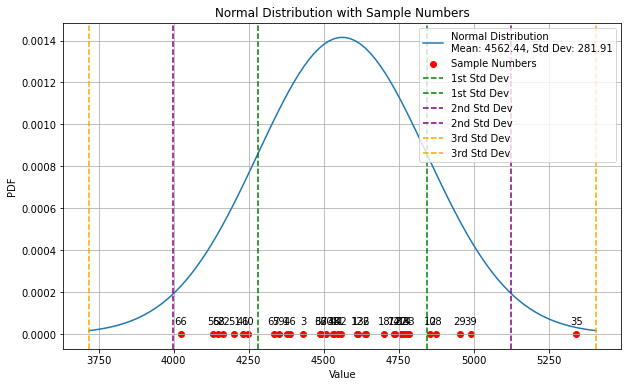

In [23]:
# Extract sample numbers, means, and calculate standard deviation
sample_numbers_normalized = normal_dtwd_dist.index
mean_normalized = normal_dtwd_dist['Mean']
mu_normalized = mean_normalized.mean()
std_dev_normalized = mean_normalized.std()

# Create a range of x values for the normal distribution curve
x_normalized = np.linspace(mu_normalized - 3 * std_dev_normalized, mu_normalized + 3 * std_dev_normalized, 100)

# Calculate the PDF values for the normal distribution
pdf_normalized = (1 / (std_dev_normalized * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_normalized - mu_normalized) / std_dev_normalized) ** 2)

# Create the plot, including the normal distribution and sample numbers
plt.figure(figsize=(10, 6))
plt.plot(x_normalized, pdf_normalized, label=f'Normal Distribution\nMean: {mu_normalized:.2f}, Std Dev: {std_dev_normalized:.2f}')
plt.scatter(mean_normalized, np.zeros_like(mean_normalized), label='Sample Numbers', color='red', marker='o')

# Add dotted vertical lines for the first and second standard deviations
plt.axvline(mu_normalized - std_dev_normalized, color='green', linestyle='--', label='1st Std Dev')
plt.axvline(mu_normalized + std_dev_normalized, color='green', linestyle='--', label='1st Std Dev')
plt.axvline(mu_normalized - 2 * std_dev_normalized, color='purple', linestyle='--', label='2nd Std Dev')
plt.axvline(mu_normalized + 2 * std_dev_normalized, color='purple', linestyle='--', label='2nd Std Dev')
plt.axvline(mu_normalized - 3 * std_dev_normalized, color='orange', linestyle='--', label='3rd Std Dev')
plt.axvline(mu_normalized + 3 * std_dev_normalized, color='orange', linestyle='--', label='3rd Std Dev')

for sample_number, mean_value in zip(sample_numbers_normalized, mean_normalized):
    plt.annotate(f'{sample_number}', (mean_value, 0), textcoords='offset points', xytext=(0, 10), ha='center')

plt.legend()
plt.title('Normal Distribution with Sample Numbers')
plt.xlabel('Value')
plt.ylabel('PDF')
plt.grid(True)
plt.show()

### 4. Mark the indices of the MTS that lie within the 1st standard deviation

In [24]:
# Assuming you have the necessary variables defined (sample_numbers_normalized, mean_normalized, mu_normalized, std_dev_normalized)

# Define the range and step size for 'a' and 'b'
start_a = 0
end_a = 3.0
step_a = 0.1 
a_values = np.round(np.arange(start_a, end_a, step_a), 1).tolist()

start_b = 0.1
end_b = 3.1
step_b = 0.1 
b_values = np.round(np.arange(start_b, end_b, step_b), 1).tolist()
display(mu_normalized)
display(std_dev_normalized)
# Initialize a dictionary to store sample number lists with different names
sample_numbers_dict = {}

# Iterate over 'a' and 'b' values
for a, b in zip(a_values, b_values):
    # Generate a unique name for each pair
    name = f"sample_numbers_list_{round(a, 1)}_to_{round(b, 1)}"
    
    # Use list comprehension to filter sample numbers based on 'a' and 'b'
    sample_numbers_list = [sample for sample, mean in zip(sample_numbers_normalized, mean_normalized) if
                           mean >= mu_normalized - b * std_dev_normalized and mean <= mu_normalized - a * std_dev_normalized or
                           mean >= mu_normalized + a * std_dev_normalized and mean <= mu_normalized + b * std_dev_normalized]
    
    # Save the list to the dictionary with the unique name
    sample_numbers_dict[name] = sample_numbers_list

# Display sample numbers with different names
for name, sample_numbers_list in sample_numbers_dict.items():
    display(f"{name}:")
    display(sample_numbers_list)
    display()

4562.441165075085

281.9115163067298

'sample_numbers_list_0.0_to_0.1:'

[42, 45, 11]

'sample_numbers_list_0.1_to_0.2:'

[12, 70, 13, 38]

'sample_numbers_list_0.2_to_0.3:'

[36, 2, 6, 62]

'sample_numbers_list_0.3_to_0.4:'

[]

'sample_numbers_list_0.4_to_0.5:'

[18, 3]

'sample_numbers_list_0.5_to_0.6:'

[]

'sample_numbers_list_0.6_to_0.7:'

[14, 72, 46, 27, 1]

'sample_numbers_list_0.7_to_0.8:'

[15, 4, 32, 33, 59]

'sample_numbers_list_0.8_to_0.9:'

[67]

'sample_numbers_list_0.9_to_1.0:'

[]

'sample_numbers_list_1.0_to_1.1:'

[10]

'sample_numbers_list_1.1_to_1.2:'

[28, 60, 41]

'sample_numbers_list_1.2_to_1.3:'

[51]

'sample_numbers_list_1.3_to_1.4:'

[29]

'sample_numbers_list_1.4_to_1.5:'

[68, 22]

'sample_numbers_list_1.5_to_1.6:'

[55, 39]

'sample_numbers_list_1.6_to_1.7:'

[]

'sample_numbers_list_1.7_to_1.8:'

[]

'sample_numbers_list_1.8_to_1.9:'

[]

'sample_numbers_list_1.9_to_2.0:'

[66]

'sample_numbers_list_2.0_to_2.1:'

[]

'sample_numbers_list_2.1_to_2.2:'

[]

'sample_numbers_list_2.2_to_2.3:'

[]

'sample_numbers_list_2.3_to_2.4:'

[]

'sample_numbers_list_2.4_to_2.5:'

[]

'sample_numbers_list_2.5_to_2.6:'

[]

'sample_numbers_list_2.6_to_2.7:'

[]

'sample_numbers_list_2.7_to_2.8:'

[35]

'sample_numbers_list_2.8_to_2.9:'

[]

'sample_numbers_list_2.9_to_3.0:'

[]

### 5. Evaluate rest of the MTS in the dataset to add them into the respective bins

In [25]:
number_list = random_subjects
pkl_filename = 'normalized_df_1.pickle'
rest_distances_list = []
for rest_index in rest_indices:
    current_index = rest_index
    mean_dist_rest_index = dtwd_dist_calc_rest(number_list,pkl_filename,current_index)
    rest_distances_list.append(mean_dist_rest_index)

In [26]:
df_windows = pd.DataFrame({'rest_distances_list':rest_distances_list,
              'rest_indices':rest_indices})

,rest_distances_list,rest_indices
0,4647.986860,5
1,4795.725643,7
2,4690.055061,8
3,4757.566850,9
4,4806.815746,16


In [27]:
# Prepare the control DTW pickle file
file_name = 'rest_distances_list_1.pickle'

# Save the dictionary as a pickle file
with open(file_name, 'wb') as file:
    pickle.dump(df_windows, file)

In [28]:
start_a = 0
end_a = 3.0
step_a = 0.1 
a_values = np.round(np.arange(start_a, end_a, step_a), 1).tolist()

start_b = 0.1
end_b = 3.1
step_b = 0.1 
b_values = np.round(np.arange(start_b, end_b, step_b), 1).tolist()

display(mu_normalized)
display(std_dev_normalized)

# Initialize a dictionary to store sample number lists with different names
rest_numbers_dict = {}

# Iterate over 'a' and 'b' values
for a, b in zip(a_values, b_values):
    # Generate a unique name for each pair
    name = f"sample_numbers_list_{round(a, 1)}_to_{round(b, 1)}"
    
    # Use list comprehension to filter sample numbers based on 'a' and 'b'
    rest_numbers_list = [sample for sample, mean in zip(rest_indices, rest_distances_list) if
                           mean >= mu_normalized - b * std_dev_normalized and mean <= mu_normalized - a * std_dev_normalized or
                           mean >= mu_normalized + a * std_dev_normalized and mean <= mu_normalized + b * std_dev_normalized]
    
    # Save the list to the dictionary with the unique name
    rest_numbers_dict[name] = rest_numbers_list

# Display sample numbers with different names
for name, rest_numbers_list in rest_numbers_dict.items():
    display(f"{name}:")
    display(rest_numbers_list)
    display()

4562.441165075085

281.9115163067298

'sample_numbers_list_0.0_to_0.1:'

[21, 47, 49]

'sample_numbers_list_0.1_to_0.2:'

[20, 31, 44, 57, 58]

'sample_numbers_list_0.2_to_0.3:'

[26]

'sample_numbers_list_0.3_to_0.4:'

[5, 17, 37, 56]

'sample_numbers_list_0.4_to_0.5:'

[8, 43, 52]

'sample_numbers_list_0.5_to_0.6:'

[40, 71]

'sample_numbers_list_0.6_to_0.7:'

[9, 23]

'sample_numbers_list_0.7_to_0.8:'

[25, 54]

'sample_numbers_list_0.8_to_0.9:'

[7, 16, 48, 53, 63]

'sample_numbers_list_0.9_to_1.0:'

[19, 64]

'sample_numbers_list_1.0_to_1.1:'

[30, 34, 61]

'sample_numbers_list_1.1_to_1.2:'

[24]

'sample_numbers_list_1.2_to_1.3:'

[]

'sample_numbers_list_1.3_to_1.4:'

[50]

'sample_numbers_list_1.4_to_1.5:'

[]

'sample_numbers_list_1.5_to_1.6:'

[]

'sample_numbers_list_1.6_to_1.7:'

[]

'sample_numbers_list_1.7_to_1.8:'

[65]

'sample_numbers_list_1.8_to_1.9:'

[]

'sample_numbers_list_1.9_to_2.0:'

[69]

'sample_numbers_list_2.0_to_2.1:'

[]

'sample_numbers_list_2.1_to_2.2:'

[]

'sample_numbers_list_2.2_to_2.3:'

[]

'sample_numbers_list_2.3_to_2.4:'

[]

'sample_numbers_list_2.4_to_2.5:'

[]

'sample_numbers_list_2.5_to_2.6:'

[]

'sample_numbers_list_2.6_to_2.7:'

[]

'sample_numbers_list_2.7_to_2.8:'

[]

'sample_numbers_list_2.8_to_2.9:'

[]

'sample_numbers_list_2.9_to_3.0:'

[]

### 6. Form the final dictionary combining the sampled and rest numbers

In [29]:
final_dict = {key: sample_numbers_dict[key] + rest_numbers_dict[key] for key in sample_numbers_dict if key in rest_numbers_dict}

{'sample_numbers_list_0.0_to_0.1': [42, 45, 11, 21, 47, 49],
 'sample_numbers_list_0.1_to_0.2': [12, 70, 13, 38, 20, 31, 44, 57, 58],
 'sample_numbers_list_0.2_to_0.3': [36, 2, 6, 62, 26],
 'sample_numbers_list_0.3_to_0.4': [5, 17, 37, 56],
 'sample_numbers_list_0.4_to_0.5': [18, 3, 8, 43, 52],
 'sample_numbers_list_0.5_to_0.6': [40, 71],
 'sample_numbers_list_0.6_to_0.7': [14, 72, 46, 27, 1, 9, 23],
 'sample_numbers_list_0.7_to_0.8': [15, 4, 32, 33, 59, 25, 54],
 'sample_numbers_list_0.8_to_0.9': [67, 7, 16, 48, 53, 63],
 'sample_numbers_list_0.9_to_1.0': [19, 64],
 'sample_numbers_list_1.0_to_1.1': [10, 30, 34, 61],
 'sample_numbers_list_1.1_to_1.2': [28, 60, 41, 24],
 'sample_numbers_list_1.2_to_1.3': [51],
 'sample_numbers_list_1.3_to_1.4': [29, 50],
 'sample_numbers_list_1.4_to_1.5': [68, 22],
 'sample_numbers_list_1.5_to_1.6': [55, 39],
 'sample_numbers_list_1.6_to_1.7': [],
 'sample_numbers_list_1.7_to_1.8': [65],
 'sample_numbers_list_1.8_to_1.9': [],
 'sample_numbers_list_1.9_

In [30]:
# Prepare the control DTW pickle file
file_name = 'final_bins_1.pkl'

# Save the dictionary as a pickle file
with open(file_name, 'wb') as file:
    pickle.dump(final_dict, file)

## Do the classification

In [31]:
import numpy as np
import pandas as pd
import os
import sys
import warnings
from time import time
warnings.filterwarnings('ignore')
from scipy import signal
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt
%matplotlib inline
import math
import pickle
import statistics
import random
from sklearn.metrics.pairwise import cosine_similarity
from math import log
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import sktime as sktime
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sktime.datasets import load_from_tsfile_to_dataframe
# !pip install --upgrade numba
# pip install sktime
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeClassifierCV
from sktime.transformations.panel.rocket import Rocket
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.classification.hybrid import HIVECOTEV2

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### Load normal and abnormal datasets

In [32]:
final_normal_df = pd.read_pickle('normal_gait.pkl')
final_normal_df = final_normal_df.drop(columns='time')
final_abnormal_df = pd.read_pickle('abnormal_gait.pkl')
final_abnormal_df = final_abnormal_df.drop(columns='time')

,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
0,199.100,87.340000,91.806000,24.090,20.702000,87.670000,88.352000,63.778,163.900000,78.243,112.420000,49.995,13.750000,103.565000,144.408000,79.530000,662.838000,745.811000,1
1,196.889,86.020000,91.575000,23.914,20.911000,87.450000,89.276000,64.372,163.273000,77.550,112.420000,49.445,13.750000,104.390000,143.836000,79.530000,660.407000,744.194000,1
2,191.488,83.600000,89.232000,24.090,20.911000,87.901000,90.860000,64.570,162.019000,77.781,112.420000,50.820,13.750000,105.490000,146.410000,79.530000,652.652000,748.220000,1
3,201.476,88.220000,94.182000,24.618,20.493000,88.594000,85.646000,63.976,162.228000,77.550,112.145000,50.820,13.750000,103.312000,140.327000,77.341000,667.205000,737.473000,1
4,262.999,119.361000,115.676000,28.391,19.030000,92.884000,70.444000,59.917,157.157000,75.163,103.895000,50.545,10.175000,86.218000,102.905000,56.991000,768.702000,643.049000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77913,8.360,51.799000,37.961000,114.620,86.559000,69.564000,48.906000,30.514,5.170000,0.000,20.647000,77.242,81.191000,16.236000,21.648000,21.494000,448.283000,243.628000,72
77914,8.118,44.704000,35.398000,114.466,88.792000,72.105000,50.622000,30.910,4.906000,0.000,15.202000,81.455,87.164000,17.160000,23.320000,22.550000,445.115000,251.757000,72
77915,8.118,46.134000,37.092000,112.563,87.076000,69.542000,48.191000,30.778,4.906000,0.000,15.917000,84.062,87.670000,17.589000,23.716000,22.550000,439.494000,256.410000,72
77916,7.634,43.252000,35.277000,112.420,87.604000,69.696000,49.192000,30.778,4.510000,0.000,14.476000,86.977,91.553000,18.590000,25.432000,23.738000,435.853000,265.276000,72


,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
0,62.458,165.143,129.239,88.231,32.659,71.005,95.238,39.600,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,683.573,0.000,1
1,28.083,110.077,82.115,106.755,39.831,107.096,148.456,57.728,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,680.141,0.000,1
2,4.807,20.603,13.079,84.799,21.252,150.832,201.322,86.779,85.855,28.809,42.801,0.000,0.462,0.000,0.000,0.000,583.473,157.927,1
3,0.000,3.047,0.704,4.400,3.410,58.333,79.123,153.065,112.211,125.180,148.588,9.097,13.365,0.000,4.961,0.000,302.082,413.402,1
4,0.000,0.000,0.000,0.000,0.308,0.000,2.233,29.579,132.033,154.528,174.559,27.852,35.519,4.301,18.843,0.000,32.120,547.635,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107048,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,211.211,159.280,196.845,172.150,50.567,0.000,790.053,93
107049,108.042,84.755,63.833,11.330,8.613,0.253,0.286,0.550,0.000,0.000,0.000,78.485,78.584,249.689,179.146,66.902,277.662,652.806,93
107050,106.579,149.633,131.538,72.083,63.910,3.850,14.575,5.489,0.000,0.000,0.000,13.156,17.182,31.229,14.025,57.431,547.657,133.023,93
107051,66.616,127.677,99.264,118.360,91.025,26.323,52.580,11.814,0.000,0.000,0.000,0.000,0.990,0.462,0.000,1.144,593.659,2.596,93


In [35]:
abnormal_indices = (final_abnormal_df['Subject']).unique()
abnormal_no = (final_abnormal_df['Subject']).nunique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93])

93

In [36]:
# Specify the file path of the saved pkl file
file_path = 'final_bins_1.pkl'

# Load the dictionary from the pkl file
with open(file_path, 'rb') as file:
    final_numbers_dictionary = pickle.load(file)
# Now, 'loaded_dictionary' contains the dictionary loaded from the pkl file
display("Dictionary loaded from pickle file:")

'Dictionary loaded from pickle file:'

{'sample_numbers_list_0.0_to_0.1': [42, 45, 11, 21, 47, 49],
 'sample_numbers_list_0.1_to_0.2': [12, 70, 13, 38, 20, 31, 44, 57, 58],
 'sample_numbers_list_0.2_to_0.3': [36, 2, 6, 62, 26],
 'sample_numbers_list_0.3_to_0.4': [5, 17, 37, 56],
 'sample_numbers_list_0.4_to_0.5': [18, 3, 8, 43, 52],
 'sample_numbers_list_0.5_to_0.6': [40, 71],
 'sample_numbers_list_0.6_to_0.7': [14, 72, 46, 27, 1, 9, 23],
 'sample_numbers_list_0.7_to_0.8': [15, 4, 32, 33, 59, 25, 54],
 'sample_numbers_list_0.8_to_0.9': [67, 7, 16, 48, 53, 63],
 'sample_numbers_list_0.9_to_1.0': [19, 64],
 'sample_numbers_list_1.0_to_1.1': [10, 30, 34, 61],
 'sample_numbers_list_1.1_to_1.2': [28, 60, 41, 24],
 'sample_numbers_list_1.2_to_1.3': [51],
 'sample_numbers_list_1.3_to_1.4': [29, 50],
 'sample_numbers_list_1.4_to_1.5': [68, 22],
 'sample_numbers_list_1.5_to_1.6': [55, 39],
 'sample_numbers_list_1.6_to_1.7': [],
 'sample_numbers_list_1.7_to_1.8': [65],
 'sample_numbers_list_1.8_to_1.9': [],
 'sample_numbers_list_1.9_

In [37]:
dictionary_keys = final_numbers_dictionary.keys()
keys_list = list(dictionary_keys)

['sample_numbers_list_0.0_to_0.1',
 'sample_numbers_list_0.1_to_0.2',
 'sample_numbers_list_0.2_to_0.3',
 'sample_numbers_list_0.3_to_0.4',
 'sample_numbers_list_0.4_to_0.5',
 'sample_numbers_list_0.5_to_0.6',
 'sample_numbers_list_0.6_to_0.7',
 'sample_numbers_list_0.7_to_0.8',
 'sample_numbers_list_0.8_to_0.9',
 'sample_numbers_list_0.9_to_1.0',
 'sample_numbers_list_1.0_to_1.1',
 'sample_numbers_list_1.1_to_1.2',
 'sample_numbers_list_1.2_to_1.3',
 'sample_numbers_list_1.3_to_1.4',
 'sample_numbers_list_1.4_to_1.5',
 'sample_numbers_list_1.5_to_1.6',
 'sample_numbers_list_1.6_to_1.7',
 'sample_numbers_list_1.7_to_1.8',
 'sample_numbers_list_1.8_to_1.9',
 'sample_numbers_list_1.9_to_2.0',
 'sample_numbers_list_2.0_to_2.1',
 'sample_numbers_list_2.1_to_2.2',
 'sample_numbers_list_2.2_to_2.3',
 'sample_numbers_list_2.3_to_2.4',
 'sample_numbers_list_2.4_to_2.5',
 'sample_numbers_list_2.5_to_2.6',
 'sample_numbers_list_2.6_to_2.7',
 'sample_numbers_list_2.7_to_2.8',
 'sample_numbers_lis

### Function to find the length of the time series

In [38]:
# Define a function to z-normalize a column
def z_normalize(column):
    mean = column.mean()
    std = column.std()
    z_normalized = (column - mean) / std
    return z_normalized

In [39]:
def time_series_length_finding(df):
    train_1_abnormal = df.copy()
    train_1_ab_sub = (train_1_abnormal['Subject'].unique()).tolist()
    row_count = []
    for i in train_1_ab_sub:
        train_1_abnormal_new = train_1_abnormal[(train_1_abnormal['Subject']== i)]
        no_rows = train_1_abnormal_new.shape[0]
        row_count.append(no_rows)
    display("Avg length:",statistics.mean(row_count))
    avg_len_ts = int(statistics.mean(row_count))
    return(avg_len_ts)

In [42]:
normal_len = time_series_length_finding(final_normal_df)

'Avg length:'

1082.1944444444443

1082

In [43]:
abnormal_len = time_series_length_finding(final_abnormal_df)

'Avg length:'

1151.1075268817203

1151

In [40]:
def preprocessing_normal_df(df,desired_length):
    train_2_normal = df.copy()
    df_train_3 = pd.DataFrame(columns = train_2_normal.columns)
    num_dim = df_train_3.shape[1]
    display(num_dim)
    df_train_3.columns = range(len(df_train_3.columns))
    train_2_sub = (train_2_normal['Subject'].unique()).tolist()
    m = 0
    for i in train_2_sub:
        train_2_normal_new = train_2_normal[(train_2_normal['Subject']== i)]
        df_row_count = train_2_normal_new.shape[0]
        if df_row_count < desired_length:
            rows_to_add = desired_length - df_row_count
            train_2_normal_new.tail()
            last_row = train_2_normal_new.ffill().iloc[[-1]]  # Extract the last row
            new_rows_df = pd.concat([last_row] * rows_to_add, ignore_index=True)
            train_2_normal_initial = pd.concat([train_2_normal_new, new_rows_df], ignore_index=True)
            train_2_normal_initial_no_sub = train_2_normal_initial.drop(columns='Subject')
            train_2_normal_final = z_normalize(train_2_normal_initial_no_sub)
            train_2_normal_final.insert(0, 'Subject', i)
        else:
            train_2_normal_initial = train_2_normal_new.iloc[:desired_length,:]
            train_2_normal_initial_no_sub = train_2_normal_initial.drop(columns='Subject')
            train_2_normal_final = z_normalize(train_2_normal_initial_no_sub)
            train_2_normal_final.insert(0, 'Subject', i)
            
        train_2_normal_final.columns = range(len(train_2_normal_final.columns))
        
        df_train_3.at[m,0] = i
        j = 0
        while j < num_dim:
            df_train_3.at[m,j] = train_2_normal_final[j]
            j += 1
        m += 1    
    df_train_3['class'] = 'normal'
    df_normal_baseline = df_train_3.iloc[:,1:]
    return(df_normal_baseline)

In [41]:
def preprocessing_dataframe(df,desired_length):
    train_1_abnormal = df.copy()
    df_train_2 = pd.DataFrame(columns = train_1_abnormal.columns)
    num_dim_ab = df_train_2.shape[1]
    df_train_2.columns = range(len(df_train_2.columns))
    train_1_ab_sub = (train_1_abnormal['Subject'].unique()).tolist()
    m = 0
    for i in train_1_ab_sub:
        train_1_abnormal_new = train_1_abnormal[(train_1_abnormal['Subject']== i)]
        df_row_count = train_1_abnormal_new.shape[0]
        if df_row_count < desired_length:
            rows_to_add = desired_length - df_row_count
            last_row = train_1_abnormal_new.ffill().iloc[[-1]]  # Extract the last row
            new_rows_df = pd.concat([last_row] * rows_to_add, ignore_index=True)
            train_1_abnormal_initial = pd.concat([train_1_abnormal_new, new_rows_df], ignore_index=True)
            train_1_abnormal_initial_no_sub = train_1_abnormal_initial.drop(columns='Subject')
            train_1_abnormal_final = z_normalize(train_1_abnormal_initial_no_sub)
            train_1_abnormal_final.insert(0, 'Subject', i)
        else:
            train_1_abnormal_initial = train_1_abnormal_new.iloc[:desired_length,:]
            train_1_abnormal_initial_no_sub = train_1_abnormal_initial.drop(columns='Subject')
            train_1_abnormal_final = z_normalize(train_1_abnormal_initial_no_sub)
            train_1_abnormal_final.insert(0, 'Subject', i)
        train_1_abnormal_final.columns = range(len(train_1_abnormal_final.columns))
        
        df_train_2.at[m,0] = i
        j = 0
        while j < num_dim_ab:
            df_train_2.at[m,j] = train_1_abnormal_final[j]
            j += 1
        m += 1    
    df_train_2['class'] = 'abnormal'
    df_final = df_train_2.iloc[:,1:]
    return(df_final)

In [51]:
def ts_classifier(df_class_1):
    accuacy_list_1 = []
    precision_list_1 = []
    recall_list_1 = []
    f1_list_1 = []

    X_1 = df_class_1.iloc[:,:-1]
    y_1 = df_class_1.iloc[:,-1]
    
    display("X_1:",X_1)

    for i in range(1,31):
        X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=i,stratify = y_1)

        rocket = Rocket(num_kernels=10000)
        rocket.fit(X_train_1)
        X_train_transform_1 = rocket.transform(X_train_1)
        classifier_1 = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
        classifier_1.fit(X_train_transform_1, y_train_1)
        X_test_transform_1 = rocket.transform(X_test_1)
        y_pred_1 = classifier_1.predict(X_test_transform_1)

        pos_label = 'abnormal'

        acc_1 = accuracy_score(y_test_1, y_pred_1)
        accuacy_list_1.append(acc_1)

        prec_1 = precision_score(y_test_1, y_pred_1, pos_label=pos_label)
        precision_list_1.append(prec_1)

        recall_1 = recall_score(y_test_1, y_pred_1, pos_label=pos_label)
        recall_list_1.append(recall_1)

        f1_1 = f1_score(y_test_1, y_pred_1, pos_label=pos_label)
        f1_list_1.append(f1_1)
        display("Completed",i)

    acc_mean_1 = np.mean(accuacy_list_1)
    acc_std_dev_1 = np.std(accuacy_list_1)

    prec_mean_1 = np.mean(precision_list_1)
    prec_std_dev_1 = np.std(precision_list_1)

    recall_mean_1 = np.mean(recall_list_1)
    recall_std_dev_1 = np.std(recall_list_1)
    
    f1_mean_1 = np.mean(f1_list_1)
    f1_std_dev_1 = np.std(f1_list_1)

    return(acc_mean_1,acc_std_dev_1,prec_mean_1,prec_std_dev_1,recall_mean_1,recall_std_dev_1,f1_mean_1,f1_std_dev_1)

In [52]:
classifier_dict = {}
normal_sample_numbers = [] 
for key in keys_list:
    display("Current key in progress",key)

    if not final_numbers_dictionary[key]:
        display("Moving on to the next key")
        continue

    normal_sample_numbers.extend(final_numbers_dictionary[key])
    normal_sample_length = len(normal_sample_numbers)
    display(normal_sample_length)
    
    
    if len(normal_sample_numbers) <= abnormal_no:
        df_normal = final_normal_df[final_normal_df['Subject'].isin(normal_sample_numbers)]
        display(df_normal)

        random.seed(42)
        abnormal_sample_numbers = random.sample(abnormal_indices.tolist(), normal_sample_length)
        df_abnormal = final_abnormal_df[final_abnormal_df['Subject'].isin(abnormal_sample_numbers)]
        display(df_abnormal)

        desired_length_for_ts = time_series_length_finding(df_abnormal)

        df_normal_preprocessed = preprocessing_normal_df(df_normal,desired_length_for_ts)
        df_abnormal_preprocessed = preprocessing_dataframe(df_abnormal,desired_length_for_ts)

        df_classifier = (pd.concat([df_normal_preprocessed,df_abnormal_preprocessed]).reset_index()).drop(columns='index')
        
        if len(df_classifier) < 10:
            display("Skipping key, not enough samples.")
            continue
        
        acc_mean,acc_std_dev,prec_mean,prec_std_dev,recall_mean,recall_std_dev,f1_mean,f1_std_dev = ts_classifier(df_classifier)

        classifier_dict[key] = {'acc_mean': acc_mean,'acc_std_dev': acc_std_dev,'prec_mean': prec_mean,'prec_std_dev': prec_std_dev,'recall_mean': recall_mean,'recall_std_dev': recall_std_dev,'f1_mean': f1_mean,'f1_std_dev': f1_std_dev}

    else:
        df_abnormal = final_abnormal_df

        random.seed(42)
        random_sample_numbers = random.sample(normal_sample_numbers, abnormal_no)
        df_normal = final_normal_df[final_normal_df['Subject'].isin(random_sample_numbers)]
        display(df_normal)

        desired_length_for_ts = time_series_length_finding(df_abnormal)

        df_normal_preprocessed = preprocessing_normal_df(df_normal,desired_length_for_ts)
        df_abnormal_preprocessed = preprocessing_dataframe(df_abnormal,desired_length_for_ts)

        df_classifier = (pd.concat([df_normal_preprocessed,df_abnormal_preprocessed]).reset_index()).drop(columns='index')
        
           # Check if the number of samples is less than 2 before proceeding
        if len(df_classifier) < 10:
            display("Skipping key, not enough samples.")
            continue
        
        acc_mean,acc_std_dev,prec_mean,prec_std_dev,recall_mean,recall_std_dev,f1_mean,f1_std_dev = ts_classifier(df_classifier)

        classifier_dict[key] = {'acc_mean': acc_mean,'acc_std_dev': acc_std_dev,'prec_mean': prec_mean,'prec_std_dev': prec_std_dev,'recall_mean': recall_mean,'recall_std_dev': recall_std_dev,'f1_mean': f1_mean,'f1_std_dev': f1_std_dev}

'Current key in progress'

'sample_numbers_list_0.0_to_0.1'

6

,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
12128,184.250,133.177,108.933,217.426,30.437,143.770,89.760,26.983,9.394,8.041000,0.000000,0.000,0.000000,0.000,0.000000,0.902000,934.736,18.337000,11
12129,37.367,16.665,24.607,291.214,27.060,263.318,219.967,47.652,9.394,6.369000,0.000000,0.000,0.000000,0.000,0.000000,0.000000,927.850,15.763000,11
12130,12.243,8.426,6.930,75.471,2.321,226.149,218.647,61.424,270.776,112.849000,42.581000,10.340,0.000000,7.964,1.254000,0.000000,611.611,445.764000,11
12131,0.000,3.080,1.089,4.697,4.851,18.392,31.790,21.285,321.640,277.739000,140.833000,60.819,19.250000,25.476,38.665000,3.608000,85.184,888.030000,11
12132,0.000,5.060,3.267,0.000,0.000,0.000,0.000,0.682,284.801,241.153000,109.780000,53.988,18.282000,20.350,32.186000,2.255000,9.009,762.795000,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57937,0.000,0.000,0.000,0.000,0.836,9.922,21.703,5.786,274.879,216.975000,227.953000,92.510,58.003000,73.447,119.317000,23.914000,38.247,1086.998000,49
57938,0.000,0.000,0.000,0.000,0.000,0.000,8.800,0.682,191.785,163.075000,180.510000,113.740,72.424000,108.185,149.028000,36.102000,9.482,1014.849000,49
57939,0.000,0.000,0.000,0.000,0.000,0.484,5.632,1.023,159.258,146.630000,165.319000,140.063,84.953000,130.240,172.601000,44.726000,7.139,1043.790000,49
57940,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,111.694,115.841000,138.391000,173.580,104.863000,157.718,211.981000,58.696000,0.000,1072.764000,49


,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
3638,379.06000,152.020,194.076667,46.676667,9.313333,33.183333,46.603333,11.990,0.0000,4.18000,0.0000,12.540,18.333333,49.536667,81.216667,93.5000,872.923333,259.306667,4
3639,390.29100,184.426,213.455000,63.701000,21.010000,60.599000,76.362000,19.580,0.0000,0.41800,0.0000,3.234,3.366000,13.794000,18.722000,13.6510,1029.424000,53.185000,4
3640,292.89700,159.698,188.870000,91.861000,50.094000,111.364000,151.019000,41.437,0.0000,0.00000,0.0000,0.000,0.000000,3.223000,5.214000,0.0000,1087.240000,8.437000,4
3641,136.30100,85.756,90.002000,146.773000,85.877000,185.295000,242.814000,84.480,0.0000,0.00000,0.0000,0.000,0.000000,0.000000,0.000000,0.0000,1057.298000,0.000000,4
3642,23.54000,15.576,12.540000,131.373000,95.546000,232.188000,326.557000,118.591,0.0000,0.00000,0.0000,0.000,0.000000,0.000000,0.000000,0.0000,955.911000,0.000000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95283,26.84000,138.600,202.378000,49.753000,70.829000,84.425000,145.948000,35.387,0.0000,0.00000,0.0000,0.000,7.161000,10.527000,15.103000,74.2610,754.160000,107.052000,82
95284,25.58600,148.280,223.377000,61.347000,88.693000,109.351000,189.849000,47.102,0.0000,0.00000,0.0000,0.000,0.000000,0.000000,0.000000,0.0000,893.585000,0.000000,82
95285,24.35400,129.360,208.967000,64.790000,91.058000,113.850000,195.470000,49.830,0.0000,0.00000,0.0000,0.000,0.000000,0.000000,0.000000,0.0000,877.679000,0.000000,82
95286,24.75000,114.444,216.304000,65.219000,94.908000,113.850000,191.433000,49.148,1.3530,0.83600,12.9140,2.739,3.146000,1.980000,1.980000,1.1000,870.056000,26.048000,82


'Avg length:'

1450.3333333333333

19

'X_1:'

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0 0.496701 1 -0.629867 2 -0.82...,0 0.232823 1 -0.785922 2 -0.85...,0 0.679474 1 -0.585510 2 -0.85...,0 1.195847 1 1.934381 2 -0.22...,0 1.428477 1 1.171336 2 -0.71...,0 0.742507 1 2.107475 2 1.68...,0 0.313975 1 1.990984 2 1.97...,0 0.819668 1 2.110493 2 2.97...,0 -0.621415 1 -0.621415 2 1.49...,0 -0.609719 1 -0.629678 2 0.64...,0 -0.677699 1 -0.677699 2 -0.07...,0 -0.729742 1 -0.729742 2 -0.58...,0 -0.775461 1 -0.775461 2 -0.77...,0 -0.730663 1 -0.730663 2 -0.61...,0 -0.737720 1 -0.737720 2 -0.72...,0 -0.679307 1 -0.716221 2 -0.71...,0 0.921113 1 0.904309 2 0.13...,0 -0.912650 1 -0.918887 2 0.12...
1,0 0.697090 1 1.165664 2 0.00...,0 0.642734 1 0.796161 2 -0.23...,0 0.448933 1 0.305602 2 -0.37...,0 -0.029786 1 -0.322395 2 -0.55...,0 -0.208792 1 -0.615986 2 -0.77...,0 -0.456433 1 -0.714331 2 -0.80...,0 -0.795199 1 -0.866723 2 -0.86...,0 0.412979 1 -0.457900 2 -0.70...,0 0.253701 1 0.545892 2 1.47...,0 0.875394 1 0.988580 2 1.86...,0 0.664546 1 0.778247 2 1.36...,0 0.733251 1 0.198738 2 0.17...,0 0.418291 1 -0.068838 2 -0.19...,0 0.357653 1 -0.165786 2 -0.26...,0 -0.334612 1 -0.504107 2 -0.53...,0 0.553133 1 -0.128960 2 -0.33...,0 0.211120 1 0.190092 2 -0.63...,0 0.534523 1 0.356161 2 0.82...
2,0 1.133008 1 1.290443 2 1.60...,0 0.845772 1 0.970541 2 1.23...,0 1.004014 1 1.098561 2 1.29...,0 -0.168512 1 -0.152131 2 -0.10...,0 -0.368646 1 -0.495753 2 -0.60...,0 -0.388895 1 -0.407309 2 -0.44...,0 -0.516688 1 -0.571297 2 -0.66...,0 -0.149093 1 -0.215334 2 -0.27...,0 0.339638 1 0.385617 2 0.43...,0 0.456726 1 0.474061 2 0.35...,0 1.036504 1 0.983311 2 0.89...,0 0.146985 1 0.187591 2 0.02...,0 -0.433623 1 -0.599083 2 -0.66...,0 -0.105750 1 -0.242931 2 -0.52...,0 -0.337629 1 -0.513185 2 -0.68...,0 0.100131 1 -0.040964 2 -0.39...,0 0.432672 1 0.498055 2 0.65...,0 0.322583 1 0.242899 2 0.04...
3,0 -0.708349 1 -0.721565 2 -0.73...,0 -0.672193 1 -0.701560 2 -0.71...,0 -0.690378 1 -0.735546 2 -0.74...,0 -0.785233 1 -0.772634 2 -0.80...,0 -0.784216 1 -0.784216 2 -0.78...,0 -0.732811 1 -0.842273 2 -0.85...,0 -0.653480 1 -0.828593 2 -0.83...,0 -0.604361 1 -0.781509 2 -0.82...,0 0.844347 1 0.806188 2 0.64...,0 0.837628 1 0.836638 2 0.71...,0 0.961412 1 0.923280 2 0.74...,0 0.671385 1 0.742352 2 0.83...,0 1.090619 1 1.074538 2 1.12...,0 0.558375 1 0.679653 2 0.71...,0 0.822649 1 0.867733 2 0.82...,0 0.984279 1 0.963442 2 0.86...,0 -0.869606 1 -0.952635 2 -0.97...,0 1.079841 1 1.093955 2 0.98...
4,0 -0.884740 1 -0.893772 2 -0.89...,0 -0.847556 1 -0.863286 2 -0.87...,0 -0.837741 1 -0.840697 2 -0.85...,0 -0.977412 1 -1.023745 2 -1.01...,0 -0.997561 1 -0.997561 2 -0.99...,0 -0.979984 1 -0.989861 2 -0.98...,0 -0.887795 1 -0.887795 2 -0.88...,0 -0.860034 1 -0.860034 2 -0.81...,0 2.674856 1 2.102467 2 0.43...,0 2.345020 1 2.001700 2 0.81...,0 0.924139 1 1.082954 2 0.29...,0 0.198729 1 0.383241 2 1.35...,0 -0.046263 1 0.792837 2 2.08...,0 -0.227431 1 0.041838 2 1.21...,0 -0.397783 1 0.121396 2 1.25...,0 -0.279321 1 -0.070245 2 0.53...,0 -1.313155 1 -1.327799 2 -1.32...,0 1.208027 1 1.300205 2 1.33...
5,0 1.410082 1 1.526988 2 2.10...,0 1.310865 1 1.428006 2 1.97...,0 2.122986 1 2.264668 2 2.66...,0 1.185212 1 1.204638 2 1.19...,0 1.582102 1 1.582102 2 1.32...,0 1.118488 1 1.084007 2 0.92...,0 0.736405 1 0.675636 2 0.47...,0 1.497375 1 1.468529 2 1.31...,0 0.681530 1 0.751058 2 0.85...,0 0.960318 1 0.965550 2 0.80...,0 0.676888 1 0.728629 2 0.52...,0 -0.961180 1 -1.039904 2 -1.35...,0 -1.186925 1 -1.234861 2 -1.46...,0 -0.733513 1 -0.831210 2 -1.34...,0 -1.200606 1 -1.285216 2 -1.51...,0 -0.929415 1 -1.016664 2 -1.38...,0 1.619457 1 1.680579 2 1.92...,0 -0.539461 1 -0.591109 2 -0.92...
6,0 1.947514 1 2.026906 2 1.33...,0 1.509333 1 1.980140 2 1.62...,0 1.903773 1 2.163328 2 1.83...,0 0.089731 1 0.389060 2 0.88...,0 -0.494789 1 -0.188514 2 0.57...,0 -0.377501 1 -0.030670 2 0.61...,0 -0.419177 1 -0.179330 2 0.42...,0 -0.498924 1 -0.303833 2 0.25...,0 -1.046280 1 -1.046280 2 -1.04...,0 -0.999926 1 -1.046390 

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_0.1_to_0.2'

15

,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
12128,184.250,133.177,108.933000,217.426000,30.437000,143.770000,89.760000,26.983,9.394000,8.041000,0.000000,0.000000,0.000000,0.000,0.000000,0.902000,934.736000,18.337000,11
12129,37.367,16.665,24.607000,291.214000,27.060000,263.318000,219.967000,47.652,9.394000,6.369000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,927.850000,15.763000,11
12130,12.243,8.426,6.930000,75.471000,2.321000,226.149000,218.647000,61.424,270.776000,112.849000,42.581000,10.340000,0.000000,7.964,1.254000,0.000000,611.611000,445.764000,11
12131,0.000,3.080,1.089000,4.697000,4.851000,18.392000,31.790000,21.285,321.640000,277.739000,140.833000,60.819000,19.250000,25.476,38.665000,3.608000,85.184000,888.030000,11
12132,0.000,5.060,3.267000,0.000000,0.000000,0.000000,0.000000,0.682,284.801000,241.153000,109.780000,53.988000,18.282000,20.350,32.186000,2.255000,9.009000,762.795000,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76239,9.207,77.385,25.762000,67.518000,77.077000,18.238000,17.875000,16.104,14.278000,75.042000,107.921000,68.948000,166.342000,13.860,58.212000,23.331000,309.166000,527.934000,70
76240,17.501,178.112,63.063000,144.694000,116.061000,36.190000,29.172000,27.016,3.751000,8.294000,15.213000,24.277000,65.538000,1.320,13.981000,8.976000,611.809000,141.350000,70
76241,18.590,190.146,63.492000,159.632000,124.267000,43.527000,31.603000,29.062,0.000000,0.858000,4.532000,3.916000,8.954000,0.000,1.155000,1.056000,660.319000,20.471000,70
76242,18.040,178.387,61.633000,160.963000,131.010000,46.530000,32.747000,29.590,3.212000,3.003000,5.104000,4.785000,17.479000,0.000,0.000000,0.528000,658.900000,34.111000,70


,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
3638,379.060,152.020,194.076667,46.676667,9.313333,33.183333,46.603333,11.990,0.000,4.180,0.000,12.540,18.333333,49.536667,81.216667,93.500,872.923333,259.306667,4
3639,390.291,184.426,213.455000,63.701000,21.010000,60.599000,76.362000,19.580,0.000,0.418,0.000,3.234,3.366000,13.794000,18.722000,13.651,1029.424000,53.185000,4
3640,292.897,159.698,188.870000,91.861000,50.094000,111.364000,151.019000,41.437,0.000,0.000,0.000,0.000,0.000000,3.223000,5.214000,0.000,1087.240000,8.437000,4
3641,136.301,85.756,90.002000,146.773000,85.877000,185.295000,242.814000,84.480,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000000,0.000,1057.298000,0.000000,4
3642,23.540,15.576,12.540000,131.373000,95.546000,232.188000,326.557000,118.591,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000000,0.000,955.911000,0.000000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100670,284.691,161.920,109.868000,93.786000,25.982000,140.393000,121.858000,43.043,0.000,0.000,0.000,0.000,0.000000,1.243000,9.240000,2.783,981.541000,13.266000,87
100671,170.665,100.749,63.503000,111.969000,30.129000,165.000000,138.677000,57.618,0.000,0.000,0.000,0.000,0.000000,0.000000,2.794000,0.000,838.310000,2.794000,87
100672,98.263,55.088,34.177000,131.659000,37.290000,194.337000,179.641000,79.904,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000000,0.000,810.359000,0.000000,87
100673,42.603,19.921,11.968000,133.100000,40.370000,186.098000,233.695000,90.354,0.000,0.000,0.000,0.000,0.000000,0.000000,2.607000,0.000,758.109000,2.607000,87


'Avg length:'

1235

19

'X_1:'

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0 0.518469 1 -0.531870 2 -0.71...,0 0.326616 1 -0.647259 2 -0.71...,0 0.779937 1 -0.444761 2 -0.70...,0 1.323783 1 2.051931 2 -0.07...,0 1.562263 1 1.307837 2 -0.55...,0 0.737600 1 2.006693 2 1.61...,0 0.294461 1 1.842176 2 1.82...,0 0.777067 1 1.969837 2 2.76...,0 -0.716538 1 -0.716538 2 1.32...,0 -0.707429 1 -0.726704 2 0.50...,0 -0.765543 1 -0.765543 2 -0.19...,0 -0.830109 1 -0.830109 2 -0.68...,0 -0.888003 1 -0.888003 2 -0.88...,0 -0.831264 1 -0.831264 2 -0.72...,0 -0.840129 1 -0.840129 2 -0.82...,0 -0.755730 1 -0.791056 2 -0.79...,0 1.008503 1 0.992273 2 0.24...,0 -1.084541 1 -1.090813 2 -0.04...
1,0 1.726065 1 2.068497 2 1.98...,0 1.204642 1 1.947691 2 2.28...,0 0.691857 1 1.506118 2 1.55...,0 -0.489291 1 -0.134574 2 0.31...,0 -0.876650 1 -0.517182 2 -0.19...,0 -0.801845 1 -0.412604 2 -0.09...,0 -0.843559 1 -0.641463 2 -0.47...,0 -0.818548 1 -0.615124 2 -0.41...,0 -0.677511 1 -0.677511 2 -0.65...,0 -0.599546 1 -0.630786 2 -0.63...,0 -0.649826 1 -0.649826 2 -0.64...,0 -0.357245 1 -0.594920 2 -0.85...,0 0.306000 1 -0.285823 2 -0.83...,0 0.816091 1 -0.330215 2 -0.89...,0 0.217628 1 -0.334926 2 -0.88...,0 1.943709 1 0.779180 2 -0.87...,0 0.323762 1 0.945452 2 1.24...,0 0.127794 1 -0.532163 2 -1.10...
2,0 -0.754682 1 -0.758032 2 -0.78...,0 -0.756900 1 -0.756900 2 -0.75...,0 -0.694743 1 -0.697801 2 -0.72...,0 -0.871792 1 -0.871792 2 -0.87...,0 -0.790127 1 -0.790127 2 -0.79...,0 -0.859442 1 -0.859442 2 -0.85...,0 -0.710737 1 -0.728464 2 -0.79...,0 -0.793586 1 -0.793586 2 -0.79...,0 2.163135 1 1.947760 2 1.35...,0 1.764827 1 1.618138 2 1.26...,0 1.883184 1 1.604449 2 1.21...,0 -0.054349 1 -0.060723 2 0.39...,0 0.799035 1 0.776317 2 0.84...,0 -0.361571 1 -0.345663 2 -0.05...,0 0.175531 1 0.115932 2 0.19...,0 -0.439414 1 -0.419263 2 -0.32...,0 -1.136046 1 -1.141692 2 -1.17...,0 1.268891 1 1.122640 2 0.99...
3,0 1.105394 1 0.605771 2 -0.47...,0 2.122173 1 1.236728 2 -0.41...,0 0.451663 1 0.204510 2 -0.53...,0 0.921851 1 0.775592 2 -0.35...,0 -0.084936 1 0.139303 2 -0.21...,0 -0.333005 1 -0.206904 2 -0.28...,0 -0.651270 1 -0.496413 2 -0.30...,0 -0.407728 1 -0.359502 2 -0.39...,0 0.475320 1 0.909757 2 2.10...,0 0.564095 1 0.998712 2 2.29...,0 0.437760 1 0.752492 2 1.58...,0 -0.154628 1 -0.013793 2 0.50...,0 -0.733189 1 -0.733189 2 -0.47...,0 -0.644632 1 -0.610016 2 -0.39...,0 -0.809737 1 -0.809737 2 -0.79...,0 -0.816058 1 -0.816058 2 -0.80...,0 0.817227 1 0.480876 2 -0.57...,0 -0.222694 1 0.051960 2 0.88...
4,0 0.744657 1 1.187644 2 0.09...,0 0.707370 1 0.853299 2 -0.13...,0 0.618267 1 0.474116 2 -0.20...,0 0.144547 1 -0.152004 2 -0.39...,0 0.034967 1 -0.424293 2 -0.60...,0 -0.368050 1 -0.608724 2 -0.69...,0 -0.675294 1 -0.742409 2 -0.74...,0 0.525635 1 -0.319324 2 -0.56...,0 0.126806 1 0.408854 2 1.30...,0 0.725891 1 0.835367 2 1.68...,0 0.524087 1 0.633737 2 1.20...,0 0.587324 1 0.069439 2 0.04...,0 0.278551 1 -0.195326 2 -0.32...,0 0.224584 1 -0.281969 2 -0.38...,0 -0.449183 1 -0.613591 2 -0.63...,0 0.415998 1 -0.242297 2 -0.44...,0 0.369690 1 0.348697 2 -0.47...,0 0.370469 1 0.190965 2 0.66...
5,0 0.742910 1 0.724217 2 0.75...,0 0.134251 1 0.120826 2 0.12...,0 0.700033 1 0.689353 2 0.70...,0 0.221167 1 0.198814 2 0.18...,0 0.751522 1 0.751522 2 0.75...,0 0.046117 1 0.042988 2 0.01...,0 0.007043 1 0.007043 2 -0.00...,0 0.740356 1 0.740356 2 0.74...,0 0.586329 1 0.574860 2 0.59...,0 0.432293 1 0.432293 2 0.43...,0 0.498046 1 0.498046 2 0.48...,0 0.475900 1 0.480546 2 0.47...,0 1.301022 1 1.379573 2 1.30...,0 0.002394 1 0.007659 2 -0.00...,0 -0.072980 1 -0.069903 2 -0.08...,0 0.487216 1 0.530974 2 0.53...,0 0.483858 1 0.470359 2 0.47...,0 0.490476 1 0.495736 2 0.48...
6,0 1.967907 1 0.184993 2 -0.63...,0 1.900695 1 0.314640 2 -0.52...,0 1.080634 1 0.059291 2 -0.60...,0 -0.213636 1 -0.498746 2 -0.87...,0 -0.257957 1 -0.301607 2 -0.80...,0 -0.442989 1 -0.467716 2 -0.97...,0 -0.564544 1 -0.429500 2 -0.83...,0 -0.413182 1 -0.413821 2 -0.77...,0 1.753349 1 2.771122 2 3.73...,0 0.411292 1 1.

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_0.2_to_0.3'

20

,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
1212,287.980,204.600,100.540000,49.940000,8.470000,72.050000,16.720000,22.880,33.330000,30.470000,40.700000,56.540000,13.750000,110.990,65.450000,55.110000,763.180000,406.340000,2
1213,309.507,243.133,101.508000,62.260000,9.724000,76.065000,15.488000,20.944,15.202000,11.440000,17.193000,23.166000,4.675000,69.245,40.458000,35.354000,838.629000,216.733000,2
1214,325.105,278.278,100.342000,77.110000,10.142000,77.880000,14.036000,18.304,6.578000,0.000000,5.214000,0.000000,0.000000,1.650,2.541000,2.101000,901.197000,18.084000,2
1215,295.449,266.970,99.385000,88.836000,11.187000,96.239000,18.414000,22.000,4.994000,0.000000,2.838000,0.000000,0.000000,0.000,1.012000,0.000000,898.480000,8.844000,2
1216,259.138,250.690,91.586000,108.273000,14.531000,115.115000,25.806000,24.464,2.387000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,889.603000,2.387000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76239,9.207,77.385,25.762000,67.518000,77.077000,18.238000,17.875000,16.104,14.278000,75.042000,107.921000,68.948000,166.342000,13.860,58.212000,23.331000,309.166000,527.934000,70
76240,17.501,178.112,63.063000,144.694000,116.061000,36.190000,29.172000,27.016,3.751000,8.294000,15.213000,24.277000,65.538000,1.320,13.981000,8.976000,611.809000,141.350000,70
76241,18.590,190.146,63.492000,159.632000,124.267000,43.527000,31.603000,29.062,0.000000,0.858000,4.532000,3.916000,8.954000,0.000,1.155000,1.056000,660.319000,20.471000,70
76242,18.040,178.387,61.633000,160.963000,131.010000,46.530000,32.747000,29.590,3.212000,3.003000,5.104000,4.785000,17.479000,0.000,0.000000,0.528000,658.900000,34.111000,70


,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
3638,379.060,152.020,194.076667,46.676667,9.313333,33.183333,46.603333,11.990,0.000,4.180,0.000,12.540,18.333333,49.536667,81.216667,93.500,872.923333,259.306667,4
3639,390.291,184.426,213.455000,63.701000,21.010000,60.599000,76.362000,19.580,0.000,0.418,0.000,3.234,3.366000,13.794000,18.722000,13.651,1029.424000,53.185000,4
3640,292.897,159.698,188.870000,91.861000,50.094000,111.364000,151.019000,41.437,0.000,0.000,0.000,0.000,0.000000,3.223000,5.214000,0.000,1087.240000,8.437000,4
3641,136.301,85.756,90.002000,146.773000,85.877000,185.295000,242.814000,84.480,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000000,0.000,1057.298000,0.000000,4
3642,23.540,15.576,12.540000,131.373000,95.546000,232.188000,326.557000,118.591,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000000,0.000,955.911000,0.000000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100670,284.691,161.920,109.868000,93.786000,25.982000,140.393000,121.858000,43.043,0.000,0.000,0.000,0.000,0.000000,1.243000,9.240000,2.783,981.541000,13.266000,87
100671,170.665,100.749,63.503000,111.969000,30.129000,165.000000,138.677000,57.618,0.000,0.000,0.000,0.000,0.000000,0.000000,2.794000,0.000,838.310000,2.794000,87
100672,98.263,55.088,34.177000,131.659000,37.290000,194.337000,179.641000,79.904,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000000,0.000,810.359000,0.000000,87
100673,42.603,19.921,11.968000,133.100000,40.370000,186.098000,233.695000,90.354,0.000,0.000,0.000,0.000,0.000000,0.000000,2.607000,0.000,758.109000,2.607000,87


'Avg length:'

1169.8

19

'X_1:'

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,1212 1.368156 1213 1.535288 1214 1.65...,1212 1.188488 1213 1.569680 1214 1.91...,1212 0.389683 1213 0.401330 1214 0.38...,1212 0.097938 1213 0.309467 1214 0.56...,1212 0.357936 1213 0.500461 1214 0.54...,1212 -0.069408 1213 -0.026659 1214 -0.00...,1212 -0.294536 1213 -0.324817 1214 -0.36...,1212 0.066444 1213 0.001709 1214 -0.08...,1212 -0.503221 1213 -0.653443 1214 -0.72...,1212 -0.395722 1213 -0.632121 1214 -0.77...,1212 -0.235018 1213 -0.532916 1214 -0.68...,1212 0.148999 1213 -0.420196 1214 -0.81...,1212 0.662725 1213 -0.166036 1214 -0.59...,1212 0.187376 1213 -0.206534 1214 -0.84...,1212 0.135527 1213 -0.209884 1214 -0.73...,1212 0.645630 1213 0.115125 1214 -0.77...,1212 0.879635 1213 1.086332 1214 1.25...,1212 -0.109539 1213 -0.610887 1214 -1.13...
1,6064 -0.639572 6065 -0.674277 6066 -0.67...,6064 -0.617881 6065 -0.710668 6066 -0.71...,6064 -0.564920 6065 -0.684189 6066 -0.70...,6064 1.101777 6065 0.160200 6066 -0.79...,6064 1.690588 6065 0.747222 6066 -0.64...,6064 1.897801 6065 2.452931 6066 0.37...,6064 2.264845 6065 2.879463 6066 1.42...,6064 0.545614 6065 1.201623 6066 4.59...,6064 -0.689464 6065 -0.009104 6066 1.62...,6064 -0.711212 6065 -0.498507 6066 2.11...,6064 -0.680121 6065 -0.633544 6066 1.26...,6064 -0.879550 6065 -0.879550 6066 -0.23...,6064 -0.889054 6065 -0.889054 6066 -0.50...,6064 -0.746035 6065 -0.746035 6066 -0.64...,6064 -0.750549 6065 -0.750549 6066 -0.71...,6064 -0.823049 6065 -0.823049 6066 -0.72...,6064 1.347885 6065 1.227706 6066 0.18...,6064 -1.168206 6065 -1.052858 6066 0.27...
2,12128 0.526761 12129 -0.517237 12130 -0...,12128 0.343636 12129 -0.629094 12130 -0...,12128 0.797472 12129 -0.425385 12130 -0...,12128 1.342602 12129 2.070421 12130 -0...,12128 1.576442 12129 1.322352 12130 -0...,12128 0.735075 12129 1.992863 12130 1...,12128 0.288230 12129 1.818453 12130 1...,12128 0.765481 12129 1.943293 12130 2...,12128 -0.730945 12129 -0.730945 12130 1...,12128 -0.723857 12129 -0.743050 12130 0...,12128 -0.780503 12129 -0.780503 12130 -0...,12128 -0.844877 12129 -0.844877 12130 -0...,12128 -0.903916 12129 -0.903916 12130 -0...,12128 -0.846279 12129 -0.846279 12130 -0...,12128 -0.855507 12129 -0.855507 12130 -0...,12128 -0.763440 12129 -0.798606 12130 -0...,12128 1.022053 12129 1.005880 12130 0...,12128 -1.111851 12129 -1.118142 12130 -0...
3,13340 1.791237 13341 2.139924 13342 2...,13340 1.295093 13341 2.067217 13342 2...,13340 0.736737 13341 1.565056 13342 1...,13340 -0.475533 13341 -0.124748 13342 0...,13340 -0.870330 13341 -0.508160 13342 -0...,13340 -0.798921 13341 -0.415840 13342 -0...,13340 -0.846363 13341 -0.642776 13342 -0...,13340 -0.819007 13341 -0.617460 13342 -0...,13340 -0.686460 13341 -0.686460 13342 -0...,13340 -0.609454 13341 -0.640625 13342 -0...,13340 -0.659362 13341 -0.659362 13342 -0...,13340 -0.367531 13341 -0.608623 13342 -0...,13340 0.279877 13341 -0.306891 13342 -0...,13340 0.813878 13341 -0.342217 13342 -0...,13340 0.189190 13341 -0.358285 13342 -0...,13340 1.925299 13341 0.763959 13342 -0...,13340 0.350121 13341 0.975993 13342 1...,13340 0.107816 13341 -0.553423 13342 -1...
4,14553 -0.769043 14554 -0.772365 14555 -0...,14553 -0.771140 14554 -0.771140 14555 -0...,14553 -0.708365 14554 -0.711409 14555 -0...,14553 -0.885335 14554 -0.885335 14555 -0...,14553 -0.796191 14554 -0.796191 14555 -0...,14553 -0.871676 14554 -0.871676 14555 -0...,14553 -0.719525 14554 -0.737182 14555 -0...,14553 -0.804204 14554 -0.804204 14555 -0...,14553 2.151895 14554 1.938677 14555 1...,14553 1.778292 14554 1.632066 14555 1...,14553 1.870617 14554 1.594840 14555 1...,14553 -0.017985 14554 -0.024453 14555 0...,14553 0.795561 14554 0.772978 14555 0...,14553 -0.345767 14554 -0.330019 14555 -0...,14553 0.176477 14554 0.117516 14555 0...,14553 -0.428521 14554 -0.408636 14555 -0...,14553 -1.164603 14554 -1.170276 14555 -1...,14553 1.286975 14554 1.140961 14555 1...
5,23044 1.114110 23045 0.616885 23046 -0...,23044 2.122031 23045 1.242305 23046 -0...,230

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_0.3_to_0.4'

24

,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
1212,287.980,204.600,100.540000,49.940000,8.470000,72.050000,16.720000,22.880,33.330000,30.470000,40.700000,56.540000,13.750000,110.990,65.450000,55.110000,763.180000,406.340000,2
1213,309.507,243.133,101.508000,62.260000,9.724000,76.065000,15.488000,20.944,15.202000,11.440000,17.193000,23.166000,4.675000,69.245,40.458000,35.354000,838.629000,216.733000,2
1214,325.105,278.278,100.342000,77.110000,10.142000,77.880000,14.036000,18.304,6.578000,0.000000,5.214000,0.000000,0.000000,1.650,2.541000,2.101000,901.197000,18.084000,2
1215,295.449,266.970,99.385000,88.836000,11.187000,96.239000,18.414000,22.000,4.994000,0.000000,2.838000,0.000000,0.000000,0.000,1.012000,0.000000,898.480000,8.844000,2
1216,259.138,250.690,91.586000,108.273000,14.531000,115.115000,25.806000,24.464,2.387000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,889.603000,2.387000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76239,9.207,77.385,25.762000,67.518000,77.077000,18.238000,17.875000,16.104,14.278000,75.042000,107.921000,68.948000,166.342000,13.860,58.212000,23.331000,309.166000,527.934000,70
76240,17.501,178.112,63.063000,144.694000,116.061000,36.190000,29.172000,27.016,3.751000,8.294000,15.213000,24.277000,65.538000,1.320,13.981000,8.976000,611.809000,141.350000,70
76241,18.590,190.146,63.492000,159.632000,124.267000,43.527000,31.603000,29.062,0.000000,0.858000,4.532000,3.916000,8.954000,0.000,1.155000,1.056000,660.319000,20.471000,70
76242,18.040,178.387,61.633000,160.963000,131.010000,46.530000,32.747000,29.590,3.212000,3.003000,5.104000,4.785000,17.479000,0.000,0.000000,0.528000,658.900000,34.111000,70


,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
3638,379.060,152.020,194.076667,46.676667,9.313333,33.183333,46.603333,11.990,0.000000,4.180000,0.000000,12.540,18.333333,49.536667,81.216667,93.500,872.923333,259.306667,4
3639,390.291,184.426,213.455000,63.701000,21.010000,60.599000,76.362000,19.580,0.000000,0.418000,0.000000,3.234,3.366000,13.794000,18.722000,13.651,1029.424000,53.185000,4
3640,292.897,159.698,188.870000,91.861000,50.094000,111.364000,151.019000,41.437,0.000000,0.000000,0.000000,0.000,0.000000,3.223000,5.214000,0.000,1087.240000,8.437000,4
3641,136.301,85.756,90.002000,146.773000,85.877000,185.295000,242.814000,84.480,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000,1057.298000,0.000000,4
3642,23.540,15.576,12.540000,131.373000,95.546000,232.188000,326.557000,118.591,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000,955.911000,0.000000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105043,1.188,1.925,0.000000,22.869000,7.502000,114.400000,96.305000,32.098,194.172000,252.516000,100.606000,63.800,14.190000,18.931000,33.242000,14.927,276.287000,692.384000,91
105044,0.000,0.000,0.000000,2.695000,0.418000,3.509000,5.192000,3.850,141.284000,233.816000,106.337000,123.002,45.320000,59.114000,111.485000,31.779,15.664000,852.137000,91
105045,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,88.374000,166.001000,86.636000,163.273,65.516000,94.017000,170.654000,42.790,0.000000,877.261000,91
105046,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,59.026000,110.264000,80.091000,130.207,93.093000,90.255000,239.844000,52.503,0.000000,855.283000,91


'Avg length:'

1206

19

'X_1:'

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,1212 1.367446 1213 1.534460 1214 1.65...,1212 1.188477 1213 1.569437 1214 1.91...,1212 0.393501 1213 0.405173 1214 0.39...,1212 0.100219 1213 0.311954 1214 0.56...,1212 0.363082 1213 0.505791 1214 0.55...,1212 -0.066751 1213 -0.024044 1214 -0.00...,1212 -0.290105 1213 -0.320537 1214 -0.35...,1212 0.070015 1213 0.005197 1214 -0.08...,1212 -0.504125 1213 -0.654255 1214 -0.72...,1212 -0.397751 1213 -0.633900 1214 -0.77...,1212 -0.236472 1213 -0.534292 1214 -0.68...,1212 0.146815 1213 -0.421904 1214 -0.81...,1212 0.658768 1213 -0.169348 1214 -0.59...,1212 0.185844 1213 -0.208097 1214 -0.84...,1212 0.133806 1213 -0.211599 1214 -0.73...,1212 0.644127 1213 0.113562 1214 -0.77...,1212 0.882674 1213 1.089373 1214 1.26...,1212 -0.112122 1213 -0.613570 1214 -1.13...
1,4851 -0.876451 4852 -0.876451 4853 -0.42...,4851 -0.869179 4852 -0.870922 4853 -0.78...,4851 -0.936470 4852 -0.936470 4853 -0.90...,4851 -0.993367 4852 -0.993367 4853 -0.99...,4851 -0.805919 4852 -0.805919 4853 -0.80...,4851 -0.848171 4852 -0.848171 4853 -0.84...,4851 -0.813189 4852 -0.813189 4853 -0.81...,4851 -0.963241 4852 -0.963241 4853 -0.96...,4851 0.008112 4852 -0.418631 4853 -0.68...,4851 0.763032 4852 -0.030205 4853 -0.62...,4851 0.577760 4852 0.058041 4853 -0.59...,4851 2.009144 4852 2.266843 4853 1.97...,4851 0.896146 4852 1.308477 4853 1.14...,4851 1.180434 4852 1.732753 4853 2.39...,4851 0.283536 4852 0.807472 4853 1.56...,4851 -0.123289 4852 0.389833 4853 1.44...,4851 -1.261440 4852 -1.261793 4853 -1.15...,4851 1.009841 4852 1.108644 4853 1.25...
2,6064 -0.640001 6065 -0.674888 6066 -0.67...,6064 -0.619305 6065 -0.711879 6066 -0.71...,6064 -0.563106 6065 -0.682876 6066 -0.69...,6064 1.100415 6065 0.157520 6066 -0.79...,6064 1.684035 6065 0.743119 6066 -0.64...,6064 1.909825 6065 2.467794 6066 0.38...,6064 2.267710 6065 2.883295 6066 1.42...,6064 0.550498 6065 1.211253 6066 4.63...,6064 -0.684604 6065 -0.000571 6066 1.63...,6064 -0.705402 6065 -0.491536 6066 2.13...,6064 -0.675603 6065 -0.628796 6066 1.28...,6064 -0.882689 6065 -0.882689 6066 -0.23...,6064 -0.891342 6065 -0.891342 6066 -0.50...,6064 -0.751925 6065 -0.751925 6066 -0.65...,6064 -0.756622 6065 -0.756622 6066 -0.71...,6064 -0.830707 6065 -0.830707 6066 -0.73...,6064 1.349968 6065 1.229594 6066 0.18...,6064 -1.169538 6065 -1.054367 6066 0.27...
3,12128 0.524015 12129 -0.518468 12130 -0...,12128 0.340978 12129 -0.629472 12130 -0...,12128 0.796037 12129 -0.426100 12130 -0...,12128 1.339209 12129 2.066233 12130 -0...,12128 1.578048 12129 1.323859 12130 -0...,12128 0.733930 12129 1.990391 12130 1...,12128 0.289034 12129 1.820016 12130 1...,12128 0.768446 12129 1.948639 12130 2...,12128 -0.731209 12129 -0.731209 12130 1...,12128 -0.722151 12129 -0.741336 12130 0...,12128 -0.778628 12129 -0.778628 12130 -0...,12128 -0.843548 12129 -0.843548 12130 -0...,12128 -0.903333 12129 -0.903333 12130 -0...,12128 -0.843953 12129 -0.843953 12130 -0...,12128 -0.853848 12129 -0.853848 12130 -0...,12128 -0.764469 12129 -0.799686 12130 -0...,12128 1.020635 12129 1.004458 12130 0...,12128 -1.109519 12129 -1.115806 12130 -0...
4,13340 1.788462 13341 2.137018 13342 2...,13340 1.295682 13341 2.068594 13342 2...,13340 0.729875 13341 1.555222 13342 1...,13340 -0.475278 13341 -0.122020 13342 0...,13340 -0.868635 13341 -0.512794 13342 -0...,13340 -0.800824 13341 -0.415482 13342 -0...,13340 -0.845099 13341 -0.644921 13342 -0...,13340 -0.821081 13341 -0.619548 13342 -0...,13340 -0.685076 13341 -0.685076 13342 -0...,13340 -0.607847 13341 -0.639026 13342 -0...,13340 -0.656563 13341 -0.656563 13342 -0...,13340 -0.368593 13341 -0.606145 13342 -0...,13340 0.292616 13341 -0.298256 13342 -0...,13340 0.800279 13341 -0.343129 13342 -0...,13340 0.203584 13341 -0.348026 13342 -0...,13340 1.923719 13341 0.763343 13342 -0...,13340 0.346689 13341 0.972376 13342 1...,13340 0.111100 13341 -0.550379 13342 -1...
5,14553 -0.767348 14554 -0.770682 14555 -0...,14553 -0.768621 14554 -0.768621 14555 -0...,1

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_0.4_to_0.5'

29

,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
1212,287.980,204.600,100.540000,49.940000,8.470000,72.050000,16.720000,22.880,33.330000,30.470000,40.700000,56.540000,13.750000,110.990,65.450000,55.110000,763.180000,406.340000,2
1213,309.507,243.133,101.508000,62.260000,9.724000,76.065000,15.488000,20.944,15.202000,11.440000,17.193000,23.166000,4.675000,69.245,40.458000,35.354000,838.629000,216.733000,2
1214,325.105,278.278,100.342000,77.110000,10.142000,77.880000,14.036000,18.304,6.578000,0.000000,5.214000,0.000000,0.000000,1.650,2.541000,2.101000,901.197000,18.084000,2
1215,295.449,266.970,99.385000,88.836000,11.187000,96.239000,18.414000,22.000,4.994000,0.000000,2.838000,0.000000,0.000000,0.000,1.012000,0.000000,898.480000,8.844000,2
1216,259.138,250.690,91.586000,108.273000,14.531000,115.115000,25.806000,24.464,2.387000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,889.603000,2.387000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76239,9.207,77.385,25.762000,67.518000,77.077000,18.238000,17.875000,16.104,14.278000,75.042000,107.921000,68.948000,166.342000,13.860,58.212000,23.331000,309.166000,527.934000,70
76240,17.501,178.112,63.063000,144.694000,116.061000,36.190000,29.172000,27.016,3.751000,8.294000,15.213000,24.277000,65.538000,1.320,13.981000,8.976000,611.809000,141.350000,70
76241,18.590,190.146,63.492000,159.632000,124.267000,43.527000,31.603000,29.062,0.000000,0.858000,4.532000,3.916000,8.954000,0.000,1.155000,1.056000,660.319000,20.471000,70
76242,18.040,178.387,61.633000,160.963000,131.010000,46.530000,32.747000,29.590,3.212000,3.003000,5.104000,4.785000,17.479000,0.000,0.000000,0.528000,658.900000,34.111000,70


,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
0,62.458,165.143,129.239,88.231,32.659,71.005,95.238,39.600,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,683.573,0.000,1
1,28.083,110.077,82.115,106.755,39.831,107.096,148.456,57.728,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,680.141,0.000,1
2,4.807,20.603,13.079,84.799,21.252,150.832,201.322,86.779,85.855,28.809,42.801,0.000,0.462,0.000,0.000,0.000,583.473,157.927,1
3,0.000,3.047,0.704,4.400,3.410,58.333,79.123,153.065,112.211,125.180,148.588,9.097,13.365,0.000,4.961,0.000,302.082,413.402,1
4,0.000,0.000,0.000,0.000,0.308,0.000,2.233,29.579,132.033,154.528,174.559,27.852,35.519,4.301,18.843,0.000,32.120,547.635,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107048,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,211.211,159.280,196.845,172.150,50.567,0.000,790.053,93
107049,108.042,84.755,63.833,11.330,8.613,0.253,0.286,0.550,0.000,0.000,0.000,78.485,78.584,249.689,179.146,66.902,277.662,652.806,93
107050,106.579,149.633,131.538,72.083,63.910,3.850,14.575,5.489,0.000,0.000,0.000,13.156,17.182,31.229,14.025,57.431,547.657,133.023,93
107051,66.616,127.677,99.264,118.360,91.025,26.323,52.580,11.814,0.000,0.000,0.000,0.000,0.990,0.462,0.000,1.144,593.659,2.596,93


'Avg length:'

1200.0344827586207

19

'X_1:'

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,1212 1.365818 1213 1.532792 1214 1.65...,1212 1.186501 1213 1.567425 1214 1.91...,1212 0.390908 1213 0.402571 1214 0.38...,1212 0.096740 1213 0.308199 1214 0.56...,1212 0.359505 1213 0.501988 1214 0.54...,1212 -0.070270 1213 -0.027613 1214 -0.00...,1212 -0.292719 1213 -0.323107 1214 -0.35...,1212 0.067675 1213 0.002937 1214 -0.08...,1212 -0.502162 1213 -0.652552 1214 -0.72...,1212 -0.394949 1213 -0.631538 1214 -0.77...,1212 -0.233248 1213 -0.531701 1214 -0.68...,1212 0.148413 1213 -0.419837 1214 -0.81...,1212 0.662720 1213 -0.167268 1214 -0.59...,1212 0.187362 1213 -0.206368 1214 -0.84...,1212 0.137111 1213 -0.208964 1214 -0.73...,1212 0.645698 1213 0.115313 1214 -0.77...,1212 0.879273 1213 1.086007 1214 1.25...,1212 -0.108133 1213 -0.609560 1214 -1.13...
1,2425 -0.776165 2426 -0.767135 2427 0.47...,2425 -0.763249 2426 -0.763249 2427 -0.08...,2425 -0.747253 2426 -0.750727 2427 -0.28...,2425 -0.862890 2426 -0.862890 2427 -0.85...,2425 -0.731042 2426 -0.731042 2427 -0.73...,2425 -0.916935 2426 -0.916935 2427 -0.91...,2425 -0.906125 2426 -0.906125 2427 -0.90...,2425 -0.878047 2426 -0.878047 2427 -0.87...,2425 -0.213712 2426 -0.487110 2427 -0.66...,2425 -0.097124 2426 -0.403950 2427 -0.63...,2425 0.098731 2426 -0.336686 2427 -0.60...,2425 1.453325 2426 1.705534 2427 1.44...,2425 1.193292 2426 1.056374 2427 0.27...,2425 1.801820 2426 2.076934 2427 2.36...,2425 1.039561 2426 1.292967 2427 1.49...,2425 2.635744 2426 3.179697 2427 3.86...,2425 -1.222079 2426 -1.220773 2427 -0.69...,2425 1.126269 2426 1.104553 2427 1.00...
2,4851 -0.874265 4852 -0.874265 4853 -0.42...,4851 -0.867602 4852 -0.869343 4853 -0.78...,4851 -0.934677 4852 -0.934677 4853 -0.90...,4851 -0.992914 4852 -0.992914 4853 -0.99...,4851 -0.806162 4852 -0.806162 4853 -0.80...,4851 -0.848646 4852 -0.848646 4853 -0.84...,4851 -0.814076 4852 -0.814076 4853 -0.81...,4851 -0.964192 4852 -0.964192 4853 -0.96...,4851 0.004849 4852 -0.421312 4853 -0.68...,4851 0.758881 4852 -0.033320 4853 -0.62...,4851 0.574705 4852 0.055490 4853 -0.59...,4851 2.010105 4852 2.267963 4853 1.97...,4851 0.898294 4852 1.311196 4853 1.14...,4851 1.182586 4852 1.735305 4853 2.40...,4851 0.284996 4852 0.809199 4853 1.56...,4851 -0.121668 4852 0.392001 4853 1.44...,4851 -1.260706 4852 -1.261059 4853 -1.15...,4851 1.009602 4852 1.108453 4853 1.25...
3,6064 -0.637130 6065 -0.671958 6066 -0.67...,6064 -0.615430 6065 -0.708655 6066 -0.70...,6064 -0.562578 6065 -0.682070 6066 -0.69...,6064 1.105335 6065 0.162446 6066 -0.79...,6064 1.678832 6065 0.739510 6066 -0.64...,6064 1.903820 6065 2.460700 6066 0.38...,6064 2.260998 6065 2.875414 6066 1.42...,6064 0.548760 6065 1.207895 6066 4.61...,6064 -0.687118 6065 -0.003988 6066 1.63...,6064 -0.708043 6065 -0.494445 6066 2.13...,6064 -0.678063 6065 -0.631319 6066 1.27...,6064 -0.884884 6065 -0.884884 6066 -0.24...,6064 -0.893838 6065 -0.893838 6066 -0.51...,6064 -0.752206 6065 -0.752206 6066 -0.65...,6064 -0.757448 6065 -0.757448 6066 -0.71...,6064 -0.829998 6065 -0.829998 6066 -0.72...,6064 1.348103 6065 1.228000 6066 0.18...,6064 -1.172661 6065 -1.057502 6066 0.26...
4,8490 1.196080 8491 0.397026 8492 -0.37...,8490 1.137897 8491 0.535540 8492 -0.20...,8490 1.150497 8491 0.642188 8492 -0.17...,8490 0.461003 8491 0.640914 8492 0.98...,8490 1.485600 8491 1.955333 8492 2.47...,8490 0.149198 8491 0.411596 8492 0.95...,8490 0.788502 8491 1.200199 8492 1.74...,8490 0.189585 8491 0.417008 8492 1.04...,8490 -0.693175 8491 -0.693175 8492 -0.69...,8490 -0.733533 8491 -0.733533 8492 -0.73...,8490 -0.733924 8491 -0.733924 8492 -0.73...,8490 -0.841644 8491 -0.841644 8492 -0.84...,8490 -0.919676 8491 -0.919676 8492 -0.91...,8490 -0.785718 8491 -0.785718 8492 -0.78...,8490 -0.844203 8491 -0.844203 8492 -0.84...,8490 -0.718572 8491 -0.718572 8492 -0.71...,8490 1.044378 8491 1.035201 8492 1.19...,8490 -1.159730 8491 -1.159730 8492 -1.15...
5,12128 0.522704 12129 -0.518965 12130 -0...,12128 0.340266 12129 -0.629585 12130 -0...,12128 0

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_0.5_to_0.6'

31

,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
1212,287.980000,204.600000,100.540000,49.940000,8.470000,72.050000,16.720000,22.880000,33.330000,30.470000,40.700000,56.540000,13.750000,110.990000,65.450000,55.110000,763.180000,406.340000,2
1213,309.507000,243.133000,101.508000,62.260000,9.724000,76.065000,15.488000,20.944000,15.202000,11.440000,17.193000,23.166000,4.675000,69.245000,40.458000,35.354000,838.629000,216.733000,2
1214,325.105000,278.278000,100.342000,77.110000,10.142000,77.880000,14.036000,18.304000,6.578000,0.000000,5.214000,0.000000,0.000000,1.650000,2.541000,2.101000,901.197000,18.084000,2
1215,295.449000,266.970000,99.385000,88.836000,11.187000,96.239000,18.414000,22.000000,4.994000,0.000000,2.838000,0.000000,0.000000,0.000000,1.012000,0.000000,898.480000,8.844000,2
1216,259.138000,250.690000,91.586000,108.273000,14.531000,115.115000,25.806000,24.464000,2.387000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,889.603000,2.387000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77089,0.000000,0.000000,0.000000,11.099000,5.522000,53.471000,39.028000,131.219000,57.761000,156.926000,307.714000,61.149000,148.038000,14.256000,225.698000,16.797000,240.339000,988.339000,71
77090,0.000000,0.000000,1.012000,7.524000,4.708000,2.970000,7.579000,1.463000,77.990000,177.221000,370.942000,58.311000,166.045000,15.576000,244.112000,20.306000,25.256000,1130.503000,71
77091,0.000000,0.000000,0.000000,2.508000,3.069000,2.156000,1.716000,0.792000,58.322000,130.790000,336.072000,77.847000,165.704000,24.519000,291.456000,26.246000,10.241000,1110.956000,71
77092,3.916000,11.418000,10.890000,75.713000,11.913000,42.636000,26.598000,11.396000,40.040000,111.947000,272.173000,136.202000,146.322000,44.572000,273.229000,31.658000,194.480000,1056.143000,71


,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
0,62.458,165.143,129.239,88.231,32.659,71.005,95.238,39.600,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,683.573,0.000,1
1,28.083,110.077,82.115,106.755,39.831,107.096,148.456,57.728,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,680.141,0.000,1
2,4.807,20.603,13.079,84.799,21.252,150.832,201.322,86.779,85.855,28.809,42.801,0.000,0.462,0.000,0.000,0.000,583.473,157.927,1
3,0.000,3.047,0.704,4.400,3.410,58.333,79.123,153.065,112.211,125.180,148.588,9.097,13.365,0.000,4.961,0.000,302.082,413.402,1
4,0.000,0.000,0.000,0.000,0.308,0.000,2.233,29.579,132.033,154.528,174.559,27.852,35.519,4.301,18.843,0.000,32.120,547.635,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107048,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,211.211,159.280,196.845,172.150,50.567,0.000,790.053,93
107049,108.042,84.755,63.833,11.330,8.613,0.253,0.286,0.550,0.000,0.000,0.000,78.485,78.584,249.689,179.146,66.902,277.662,652.806,93
107050,106.579,149.633,131.538,72.083,63.910,3.850,14.575,5.489,0.000,0.000,0.000,13.156,17.182,31.229,14.025,57.431,547.657,133.023,93
107051,66.616,127.677,99.264,118.360,91.025,26.323,52.580,11.814,0.000,0.000,0.000,0.000,0.990,0.462,0.000,1.144,593.659,2.596,93


'Avg length:'

1189.774193548387

19

'X_1:'

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,1212 1.365167 1213 1.532108 1214 1.65...,1212 1.186799 1213 1.567850 1214 1.91...,1212 0.389026 1213 0.400675 1214 0.38...,1212 0.097347 1213 0.308973 1214 0.56...,1212 0.358174 1213 0.500620 1214 0.54...,1212 -0.070076 1213 -0.027387 1214 -0.00...,1212 -0.293910 1213 -0.324235 1214 -0.35...,1212 0.067591 1213 0.002840 1214 -0.08...,1212 -0.501461 1213 -0.652025 1214 -0.72...,1212 -0.394143 1213 -0.630895 1214 -0.77...,1212 -0.233106 1213 -0.531355 1214 -0.68...,1212 0.148894 1213 -0.419756 1214 -0.81...,1212 0.660714 1213 -0.168115 1214 -0.59...,1212 0.186804 1213 -0.206896 1214 -0.84...,1212 0.134818 1213 -0.210750 1214 -0.73...,1212 0.644676 1213 0.114281 1214 -0.77...,1212 0.878450 1213 1.085124 1214 1.25...,1212 -0.108106 1213 -0.609432 1214 -1.13...
1,2425 -0.776691 2426 -0.767662 2427 0.47...,2425 -0.763323 2426 -0.763323 2427 -0.08...,2425 -0.747185 2426 -0.750660 2427 -0.28...,2425 -0.861672 2426 -0.861672 2427 -0.85...,2425 -0.730140 2426 -0.730140 2427 -0.73...,2425 -0.915756 2426 -0.915756 2427 -0.91...,2425 -0.905112 2426 -0.905112 2427 -0.90...,2425 -0.876875 2426 -0.876875 2427 -0.87...,2425 -0.213872 2426 -0.487545 2427 -0.66...,2425 -0.096837 2426 -0.404074 2427 -0.63...,2425 0.097771 2426 -0.337441 2427 -0.60...,2425 1.452710 2426 1.704954 2427 1.44...,2425 1.194824 2426 1.057724 2427 0.27...,2425 1.798874 2426 2.073773 2427 2.36...,2425 1.039919 2426 1.293516 2427 1.49...,2425 2.631132 2426 3.174474 2427 3.86...,2425 -1.221043 2426 -1.219737 2427 -0.69...,2425 1.125697 2426 1.103978 2427 1.00...
2,4851 -0.874971 4852 -0.874971 4853 -0.42...,4851 -0.868325 4852 -0.870065 4853 -0.78...,4851 -0.935205 4852 -0.935205 4853 -0.90...,4851 -0.993451 4852 -0.993451 4853 -0.99...,4851 -0.806481 4852 -0.806481 4853 -0.80...,4851 -0.848749 4852 -0.848749 4853 -0.84...,4851 -0.814404 4852 -0.814404 4853 -0.81...,4851 -0.964991 4852 -0.964991 4853 -0.96...,4851 0.005898 4852 -0.420531 4853 -0.68...,4851 0.760062 4852 -0.032521 4853 -0.62...,4851 0.577022 4852 0.057113 4853 -0.59...,4851 2.009120 4852 2.266863 4853 1.97...,4851 0.898634 4852 1.311602 4853 1.14...,4851 1.180836 4852 1.733095 4853 2.39...,4851 0.284921 4852 0.809155 4853 1.56...,4851 -0.121864 4852 0.391756 4853 1.44...,4851 -1.261414 4852 -1.261768 4853 -1.15...,4851 1.010147 4852 1.109006 4853 1.25...
3,6064 -0.638850 6065 -0.673567 6066 -0.67...,6064 -0.616760 6065 -0.709740 6066 -0.70...,6064 -0.564235 6065 -0.683413 6066 -0.70...,6064 1.110864 6065 0.166634 6066 -0.79...,6064 1.690918 6065 0.748375 6066 -0.64...,6064 1.906474 6065 2.463017 6066 0.38...,6064 2.267390 6065 2.882128 6066 1.42...,6064 0.548235 6065 1.205230 6066 4.60...,6064 -0.690060 6065 -0.009022 6066 1.62...,6064 -0.711879 6065 -0.498862 6066 2.12...,6064 -0.680962 6065 -0.634362 6066 1.26...,6064 -0.883763 6065 -0.883763 6066 -0.24...,6064 -0.893138 6065 -0.893138 6066 -0.50...,6064 -0.749774 6065 -0.749774 6066 -0.64...,6064 -0.754825 6065 -0.754825 6066 -0.71...,6064 -0.828069 6065 -0.828069 6066 -0.72...,6064 1.351828 6065 1.231648 6066 0.18...,6064 -1.173863 6065 -1.058573 6066 0.26...
4,8490 1.196722 8491 0.397733 8492 -0.37...,8490 1.139072 8491 0.536540 8492 -0.20...,8490 1.151913 8491 0.643441 8492 -0.17...,8490 0.460370 8491 0.640024 8492 0.98...,8490 1.487718 8491 1.957678 8492 2.48...,8490 0.149687 8491 0.411999 8492 0.95...,8490 0.790670 8491 1.202788 8492 1.75...,8490 0.190643 8491 0.418243 8492 1.04...,8490 -0.693738 8491 -0.693738 8492 -0.69...,8490 -0.734593 8491 -0.734593 8492 -0.73...,8490 -0.734198 8491 -0.734198 8492 -0.73...,8490 -0.843169 8491 -0.843169 8492 -0.84...,8490 -0.922010 8491 -0.922010 8492 -0.92...,8490 -0.786399 8491 -0.786399 8492 -0.78...,8490 -0.845728 8491 -0.845728 8492 -0.84...,8490 -0.718566 8491 -0.718566 8492 -0.71...,8490 1.045572 8491 1.036395 8492 1.19...,8490 -1.160599 8491 -1.160599 8492 -1.16...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,0 0.941337 1 0.9

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_0.6_to_0.7'

38

,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
0,199.100,87.340000,91.806000,24.090,20.702000,87.670000,88.352000,63.778,163.900000,78.243,112.420000,49.995,13.750000,103.565000,144.408000,79.530000,662.838000,745.811000,1
1,196.889,86.020000,91.575000,23.914,20.911000,87.450000,89.276000,64.372,163.273000,77.550,112.420000,49.445,13.750000,104.390000,143.836000,79.530000,660.407000,744.194000,1
2,191.488,83.600000,89.232000,24.090,20.911000,87.901000,90.860000,64.570,162.019000,77.781,112.420000,50.820,13.750000,105.490000,146.410000,79.530000,652.652000,748.220000,1
3,201.476,88.220000,94.182000,24.618,20.493000,88.594000,85.646000,63.976,162.228000,77.550,112.145000,50.820,13.750000,103.312000,140.327000,77.341000,667.205000,737.473000,1
4,262.999,119.361000,115.676000,28.391,19.030000,92.884000,70.444000,59.917,157.157000,75.163,103.895000,50.545,10.175000,86.218000,102.905000,56.991000,768.702000,643.049000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77913,8.360,51.799000,37.961000,114.620,86.559000,69.564000,48.906000,30.514,5.170000,0.000,20.647000,77.242,81.191000,16.236000,21.648000,21.494000,448.283000,243.628000,72
77914,8.118,44.704000,35.398000,114.466,88.792000,72.105000,50.622000,30.910,4.906000,0.000,15.202000,81.455,87.164000,17.160000,23.320000,22.550000,445.115000,251.757000,72
77915,8.118,46.134000,37.092000,112.563,87.076000,69.542000,48.191000,30.778,4.906000,0.000,15.917000,84.062,87.670000,17.589000,23.716000,22.550000,439.494000,256.410000,72
77916,7.634,43.252000,35.277000,112.420,87.604000,69.696000,49.192000,30.778,4.510000,0.000,14.476000,86.977,91.553000,18.590000,25.432000,23.738000,435.853000,265.276000,72


,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
0,62.458,165.143,129.239,88.231,32.659,71.005,95.238,39.600,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,683.573,0.000,1
1,28.083,110.077,82.115,106.755,39.831,107.096,148.456,57.728,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,680.141,0.000,1
2,4.807,20.603,13.079,84.799,21.252,150.832,201.322,86.779,85.855,28.809,42.801,0.000,0.462,0.000,0.000,0.000,583.473,157.927,1
3,0.000,3.047,0.704,4.400,3.410,58.333,79.123,153.065,112.211,125.180,148.588,9.097,13.365,0.000,4.961,0.000,302.082,413.402,1
4,0.000,0.000,0.000,0.000,0.308,0.000,2.233,29.579,132.033,154.528,174.559,27.852,35.519,4.301,18.843,0.000,32.120,547.635,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107048,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,211.211,159.280,196.845,172.150,50.567,0.000,790.053,93
107049,108.042,84.755,63.833,11.330,8.613,0.253,0.286,0.550,0.000,0.000,0.000,78.485,78.584,249.689,179.146,66.902,277.662,652.806,93
107050,106.579,149.633,131.538,72.083,63.910,3.850,14.575,5.489,0.000,0.000,0.000,13.156,17.182,31.229,14.025,57.431,547.657,133.023,93
107051,66.616,127.677,99.264,118.360,91.025,26.323,52.580,11.814,0.000,0.000,0.000,0.000,0.990,0.462,0.000,1.144,593.659,2.596,93


'Avg length:'

1184.7105263157894

19

'X_1:'

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0 0.592129 1 0.575880 2 0.53...,0 0.217681 1 0.202070 2 0.17...,0 0.746760 1 0.742771 2 0.70...,0 -0.381949 1 -0.385372 2 -0.38...,0 -0.000776 1 0.008286 2 0.00...,0 -0.072380 1 -0.074704 2 -0.06...,0 -0.053765 1 -0.045166 2 -0.03...,0 0.897580 1 0.914897 2 0.92...,0 0.496094 1 0.491155 2 0.48...,0 0.225513 1 0.216209 2 0.21...,0 0.945132 1 0.945132 2 0.94...,0 -0.246581 1 -0.253423 2 -0.23...,0 -0.125723 1 -0.125723 2 -0.12...,0 -0.009597 1 -0.001940 2 0.00...,0 0.233796 1 0.229384 2 0.24...,0 0.766905 1 0.766905 2 0.76...,0 0.313900 1 0.308478 2 0.29...,0 0.382876 1 0.379506 2 0.38...
1,1212 1.367842 1213 1.534857 1214 1.65...,1212 1.190483 1213 1.571838 1214 1.91...,1212 0.391869 1213 0.403527 1214 0.38...,1212 0.101170 1213 0.313098 1214 0.56...,1212 0.360213 1213 0.502783 1214 0.55...,1212 -0.066542 1213 -0.023770 1214 -0.00...,1212 -0.292627 1213 -0.322923 1214 -0.35...,1212 0.069264 1213 0.004456 1214 -0.08...,1212 -0.502929 1213 -0.653388 1214 -0.72...,1212 -0.396533 1213 -0.633032 1214 -0.77...,1212 -0.235603 1213 -0.533516 1214 -0.68...,1212 0.145370 1213 -0.422870 1214 -0.81...,1212 0.657307 1213 -0.170396 1214 -0.59...,1212 0.183119 1213 -0.210349 1214 -0.84...,1212 0.131521 1213 -0.213733 1214 -0.73...,1212 0.640881 1213 0.110912 1214 -0.78...,1212 0.882186 1213 1.088828 1214 1.26...,1212 -0.112427 1213 -0.613887 1214 -1.13...
2,2425 -0.779237 2426 -0.770216 2427 0.47...,2425 -0.765731 2426 -0.765731 2427 -0.08...,2425 -0.749700 2426 -0.753171 2427 -0.29...,2425 -0.862645 2426 -0.862645 2427 -0.85...,2425 -0.730806 2426 -0.730806 2427 -0.73...,2425 -0.915960 2426 -0.915960 2427 -0.91...,2425 -0.905510 2426 -0.905510 2427 -0.90...,2425 -0.876483 2426 -0.876483 2427 -0.87...,2425 -0.210430 2426 -0.484530 2427 -0.65...,2425 -0.092893 2426 -0.400760 2427 -0.63...,2425 0.100690 2426 -0.334704 2427 -0.60...,2425 1.451335 2426 1.703327 2427 1.44...,2425 1.194896 2426 1.057848 2427 0.27...,2425 1.795761 2426 2.070321 2427 2.35...,2425 1.037501 2426 1.290769 2427 1.49...,2425 2.625593 2426 3.168147 2427 3.85...,2425 -1.222893 2426 -1.221587 2427 -0.69...,2425 1.127747 2426 1.106027 2427 1.00...
3,4851 -0.876443 4852 -0.876443 4853 -0.42...,4851 -0.869482 4852 -0.871220 4853 -0.78...,4851 -0.935880 4852 -0.935880 4853 -0.90...,4851 -0.992543 4852 -0.992543 4853 -0.99...,4851 -0.805183 4852 -0.805183 4853 -0.80...,4851 -0.847027 4852 -0.847027 4853 -0.84...,4851 -0.813111 4852 -0.813111 4853 -0.81...,4851 -0.962858 4852 -0.962858 4853 -0.96...,4851 0.008878 4852 -0.418363 4853 -0.68...,4851 0.762526 4852 -0.030578 4853 -0.62...,4851 0.580311 4852 0.059490 4853 -0.59...,4851 2.005668 4852 2.263180 4853 1.96...,4851 0.895692 4852 1.308192 4853 1.14...,4851 1.176785 4852 1.728479 4853 2.39...,4851 0.281839 4852 0.805486 4853 1.56...,4851 -0.124499 4852 0.388519 4853 1.43...,4851 -1.260543 4852 -1.260896 4853 -1.15...,4851 1.008912 4852 1.107742 4853 1.25...
4,6064 -0.638418 6065 -0.673125 6066 -0.67...,6064 -0.616607 6065 -0.709535 6066 -0.70...,6064 -0.564267 6065 -0.683446 6066 -0.70...,6064 1.107005 6065 0.163568 6066 -0.79...,6064 1.687651 6065 0.745640 6066 -0.64...,6064 1.901473 6065 2.457386 6066 0.38...,6064 2.262043 6065 2.876092 6066 1.42...,6064 0.544896 6065 1.201146 6066 4.59...,6064 -0.691399 6065 -0.011307 6066 1.61...,6064 -0.713356 6065 -0.500620 6066 2.11...,6064 -0.682496 6065 -0.635958 6066 1.26...,6064 -0.881623 6065 -0.881623 6066 -0.23...,6064 -0.890497 6065 -0.890497 6066 -0.50...,6064 -0.746523 6065 -0.746523 6066 -0.64...,6064 -0.751327 6065 -0.751327 6066 -0.71...,6064 -0.825175 6065 -0.825175 6066 -0.72...,6064 1.349077 6065 1.228896 6066 0.18...,6064 -1.170496 6065 -1.055124 6066 0.27...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0 0.938020 1 0.952556 2 0.99...,0 0.864306 1 0.864306 2 0.88...,0 1.014588 1 1.043670 2 1.08...,0 0.527708 1 0.527708 2 0.49...,0 -0.413367 1 -0.377109 2 -0.35...,0 -0.052550 1 -0.057875 2 -

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_0.7_to_0.8'

45

,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
0,199.100,87.340000,91.806000,24.090,20.702000,87.670000,88.352000,63.778,163.900000,78.243,112.420000,49.995,13.750000,103.565000,144.408000,79.530000,662.838000,745.811000,1
1,196.889,86.020000,91.575000,23.914,20.911000,87.450000,89.276000,64.372,163.273000,77.550,112.420000,49.445,13.750000,104.390000,143.836000,79.530000,660.407000,744.194000,1
2,191.488,83.600000,89.232000,24.090,20.911000,87.901000,90.860000,64.570,162.019000,77.781,112.420000,50.820,13.750000,105.490000,146.410000,79.530000,652.652000,748.220000,1
3,201.476,88.220000,94.182000,24.618,20.493000,88.594000,85.646000,63.976,162.228000,77.550,112.145000,50.820,13.750000,103.312000,140.327000,77.341000,667.205000,737.473000,1
4,262.999,119.361000,115.676000,28.391,19.030000,92.884000,70.444000,59.917,157.157000,75.163,103.895000,50.545,10.175000,86.218000,102.905000,56.991000,768.702000,643.049000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77913,8.360,51.799000,37.961000,114.620,86.559000,69.564000,48.906000,30.514,5.170000,0.000,20.647000,77.242,81.191000,16.236000,21.648000,21.494000,448.283000,243.628000,72
77914,8.118,44.704000,35.398000,114.466,88.792000,72.105000,50.622000,30.910,4.906000,0.000,15.202000,81.455,87.164000,17.160000,23.320000,22.550000,445.115000,251.757000,72
77915,8.118,46.134000,37.092000,112.563,87.076000,69.542000,48.191000,30.778,4.906000,0.000,15.917000,84.062,87.670000,17.589000,23.716000,22.550000,439.494000,256.410000,72
77916,7.634,43.252000,35.277000,112.420,87.604000,69.696000,49.192000,30.778,4.510000,0.000,14.476000,86.977,91.553000,18.590000,25.432000,23.738000,435.853000,265.276000,72


,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
0,62.458,165.143,129.239,88.231,32.659,71.005,95.238,39.600,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,683.573,0.000,1
1,28.083,110.077,82.115,106.755,39.831,107.096,148.456,57.728,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,680.141,0.000,1
2,4.807,20.603,13.079,84.799,21.252,150.832,201.322,86.779,85.855,28.809,42.801,0.000,0.462,0.000,0.000,0.000,583.473,157.927,1
3,0.000,3.047,0.704,4.400,3.410,58.333,79.123,153.065,112.211,125.180,148.588,9.097,13.365,0.000,4.961,0.000,302.082,413.402,1
4,0.000,0.000,0.000,0.000,0.308,0.000,2.233,29.579,132.033,154.528,174.559,27.852,35.519,4.301,18.843,0.000,32.120,547.635,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107048,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,211.211,159.280,196.845,172.150,50.567,0.000,790.053,93
107049,108.042,84.755,63.833,11.330,8.613,0.253,0.286,0.550,0.000,0.000,0.000,78.485,78.584,249.689,179.146,66.902,277.662,652.806,93
107050,106.579,149.633,131.538,72.083,63.910,3.850,14.575,5.489,0.000,0.000,0.000,13.156,17.182,31.229,14.025,57.431,547.657,133.023,93
107051,66.616,127.677,99.264,118.360,91.025,26.323,52.580,11.814,0.000,0.000,0.000,0.000,0.990,0.462,0.000,1.144,593.659,2.596,93


'Avg length:'

1155.2

19

'X_1:'

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0 0.586722 1 0.570507 2 0.53...,0 0.213240 1 0.197659 2 0.16...,0 0.744028 1 0.740041 2 0.69...,0 -0.381471 1 -0.384891 2 -0.38...,0 0.005041 1 0.014166 2 0.01...,0 -0.071586 1 -0.073910 2 -0.06...,0 -0.049488 1 -0.040857 2 -0.02...,0 0.898994 1 0.916313 2 0.92...,0 0.498843 1 0.493898 2 0.48...,0 0.227233 1 0.217922 2 0.22...,0 0.950297 1 0.950297 2 0.95...,0 -0.246885 1 -0.253724 2 -0.23...,0 -0.125544 1 -0.125544 2 -0.12...,0 -0.011840 1 -0.004190 2 0.00...,0 0.230740 1 0.226335 2 0.24...,0 0.762947 1 0.762947 2 0.76...,0 0.313057 1 0.307637 2 0.29...,0 0.382377 1 0.379008 2 0.38...
1,1212 1.364450 1213 1.531470 1214 1.65...,1212 1.183460 1213 1.564097 1214 1.91...,1212 0.388392 1213 0.400047 1214 0.38...,1212 0.097194 1213 0.308555 1214 0.56...,1212 0.360698 1213 0.503464 1214 0.55...,1212 -0.067065 1213 -0.024232 1214 -0.00...,1212 -0.291489 1213 -0.321817 1214 -0.35...,1212 0.070307 1213 0.005397 1214 -0.08...,1212 -0.500883 1213 -0.651358 1214 -0.72...,1212 -0.393500 1213 -0.630411 1214 -0.77...,1212 -0.232704 1213 -0.531069 1214 -0.68...,1212 0.147924 1213 -0.420410 1214 -0.81...,1212 0.663285 1213 -0.165566 1214 -0.59...,1212 0.185705 1213 -0.207736 1214 -0.84...,1212 0.134602 1213 -0.210624 1214 -0.73...,1212 0.643118 1213 0.113330 1214 -0.77...,1212 0.878447 1213 1.085095 1214 1.25...,1212 -0.108208 1213 -0.609786 1214 -1.13...
2,2425 -0.777309 2426 -0.768299 2427 0.47...,2425 -0.762594 2426 -0.762594 2427 -0.08...,2425 -0.745847 2426 -0.749321 2427 -0.28...,2425 -0.859081 2426 -0.859081 2427 -0.85...,2425 -0.728253 2426 -0.728253 2427 -0.72...,2425 -0.913349 2426 -0.913349 2427 -0.91...,2425 -0.902887 2426 -0.902887 2427 -0.90...,2425 -0.873564 2426 -0.873564 2427 -0.87...,2425 -0.212496 2426 -0.486544 2427 -0.65...,2425 -0.093775 2426 -0.402151 2427 -0.63...,2425 0.096467 2426 -0.337796 2427 -0.60...,2425 1.448232 2426 1.700137 2427 1.44...,2425 1.197495 2426 1.060163 2427 0.27...,2425 1.789623 2426 2.063778 2427 2.35...,2425 1.038178 2426 1.291780 2427 1.49...,2425 2.609742 2426 3.149916 2427 3.83...,2425 -1.218909 2426 -1.217604 2427 -0.69...,2425 1.124920 2426 1.103192 2427 1.00...
3,3638 -0.001588 3639 2.051537 3640 1.35...,3638 -0.710510 3639 1.247687 3640 2.01...,3638 -0.703821 3639 1.071892 3640 1.95...,3638 -0.817777 3639 -0.723225 3640 -0.18...,3638 -0.927899 3639 -0.731657 3640 0.01...,3638 -0.620680 3639 -0.600069 3640 -0.45...,3638 -0.667305 3639 -0.636310 3640 -0.48...,3638 -0.883654 3639 -0.766107 3640 -0.35...,3638 -0.660482 3639 -0.660482 3640 -0.66...,3638 -0.758848 3639 -0.758848 3640 -0.75...,3638 -0.706690 3639 -0.739205 3640 -0.73...,3638 0.823278 3639 -0.354876 3640 -0.72...,3638 0.814562 3639 -0.283423 3640 -0.70...,3638 2.872542 3639 1.698732 3640 -0.47...,3638 2.828908 3639 2.110264 3640 -0.42...,3638 2.009692 3639 3.344977 3640 1.25...,3638 -1.058212 3639 0.188428 3640 0.86...,3638 1.556507 3639 0.855418 3640 -0.77...
4,4851 -0.877978 4852 -0.877978 4853 -0.43...,4851 -0.871409 4852 -0.873147 4853 -0.78...,4851 -0.938160 4852 -0.938160 4853 -0.91...,4851 -0.995021 4852 -0.995021 4853 -0.99...,4851 -0.807745 4852 -0.807745 4853 -0.80...,4851 -0.849675 4852 -0.849675 4853 -0.84...,4851 -0.816100 4852 -0.816100 4853 -0.81...,4851 -0.966823 4852 -0.966823 4853 -0.96...,4851 0.009500 4852 -0.418045 4853 -0.68...,4851 0.760002 4852 -0.031685 4853 -0.62...,4851 0.584243 4852 0.062076 4853 -0.59...,4851 2.009706 4852 2.267392 4853 1.97...,4851 0.898116 4852 1.310746 4853 1.14...,4851 1.182045 4852 1.734764 4853 2.40...,4851 0.283977 4852 0.807819 4853 1.56...,4851 -0.122339 4852 0.391395 4853 1.44...,4851 -1.263282 4852 -1.263635 4853 -1.15...,4851 1.011969 4852 1.110839 4853 1.25...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0 0.918568 1 0.932952 2 0.97...,0 0.845295 1 0.845295 2 0.86...,0 0.993892 1 1.022678 2 1.06...,0 0.543398 1 0.543398 2 0.51...,0 -0.386506 1 -0.350108 2 -0.33...,0 -0.036701 1 -0.041986 2 -0

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_0.8_to_0.9'

51

,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
0,199.100,87.340000,91.806000,24.090,20.702000,87.670000,88.352000,63.778,163.900000,78.243,112.420000,49.995,13.750000,103.565000,144.408000,79.530000,662.838000,745.811000,1
1,196.889,86.020000,91.575000,23.914,20.911000,87.450000,89.276000,64.372,163.273000,77.550,112.420000,49.445,13.750000,104.390000,143.836000,79.530000,660.407000,744.194000,1
2,191.488,83.600000,89.232000,24.090,20.911000,87.901000,90.860000,64.570,162.019000,77.781,112.420000,50.820,13.750000,105.490000,146.410000,79.530000,652.652000,748.220000,1
3,201.476,88.220000,94.182000,24.618,20.493000,88.594000,85.646000,63.976,162.228000,77.550,112.145000,50.820,13.750000,103.312000,140.327000,77.341000,667.205000,737.473000,1
4,262.999,119.361000,115.676000,28.391,19.030000,92.884000,70.444000,59.917,157.157000,75.163,103.895000,50.545,10.175000,86.218000,102.905000,56.991000,768.702000,643.049000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77913,8.360,51.799000,37.961000,114.620,86.559000,69.564000,48.906000,30.514,5.170000,0.000,20.647000,77.242,81.191000,16.236000,21.648000,21.494000,448.283000,243.628000,72
77914,8.118,44.704000,35.398000,114.466,88.792000,72.105000,50.622000,30.910,4.906000,0.000,15.202000,81.455,87.164000,17.160000,23.320000,22.550000,445.115000,251.757000,72
77915,8.118,46.134000,37.092000,112.563,87.076000,69.542000,48.191000,30.778,4.906000,0.000,15.917000,84.062,87.670000,17.589000,23.716000,22.550000,439.494000,256.410000,72
77916,7.634,43.252000,35.277000,112.420,87.604000,69.696000,49.192000,30.778,4.510000,0.000,14.476000,86.977,91.553000,18.590000,25.432000,23.738000,435.853000,265.276000,72


,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
0,62.458,165.143,129.239,88.231,32.659,71.005,95.238,39.600,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,683.573,0.000,1
1,28.083,110.077,82.115,106.755,39.831,107.096,148.456,57.728,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,680.141,0.000,1
2,4.807,20.603,13.079,84.799,21.252,150.832,201.322,86.779,85.855,28.809,42.801,0.000,0.462,0.000,0.000,0.000,583.473,157.927,1
3,0.000,3.047,0.704,4.400,3.410,58.333,79.123,153.065,112.211,125.180,148.588,9.097,13.365,0.000,4.961,0.000,302.082,413.402,1
4,0.000,0.000,0.000,0.000,0.308,0.000,2.233,29.579,132.033,154.528,174.559,27.852,35.519,4.301,18.843,0.000,32.120,547.635,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107048,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,211.211,159.280,196.845,172.150,50.567,0.000,790.053,93
107049,108.042,84.755,63.833,11.330,8.613,0.253,0.286,0.550,0.000,0.000,0.000,78.485,78.584,249.689,179.146,66.902,277.662,652.806,93
107050,106.579,149.633,131.538,72.083,63.910,3.850,14.575,5.489,0.000,0.000,0.000,13.156,17.182,31.229,14.025,57.431,547.657,133.023,93
107051,66.616,127.677,99.264,118.360,91.025,26.323,52.580,11.814,0.000,0.000,0.000,0.000,0.990,0.462,0.000,1.144,593.659,2.596,93


'Avg length:'

1158.8823529411766

19

'X_1:'

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0 0.588401 1 0.572172 2 0.53...,0 0.214490 1 0.198897 2 0.17...,0 0.745436 1 0.741446 2 0.70...,0 -0.383569 1 -0.386985 2 -0.38...,0 0.001325 1 0.010427 2 0.01...,0 -0.075038 1 -0.077360 2 -0.07...,0 -0.053381 1 -0.044768 2 -0.03...,0 0.893719 1 0.911009 2 0.91...,0 0.499063 1 0.494118 2 0.48...,0 0.228356 1 0.219039 2 0.22...,0 0.952180 1 0.952180 2 0.95...,0 -0.244996 1 -0.251839 2 -0.23...,0 -0.123480 1 -0.123480 2 -0.12...,0 -0.009387 1 -0.001736 2 0.00...,0 0.233085 1 0.228679 2 0.24...,0 0.765478 1 0.765478 2 0.76...,0 0.311425 1 0.306002 2 0.28...,0 0.384611 1 0.381241 2 0.38...
1,1212 1.367151 1213 1.534238 1214 1.65...,1212 1.186084 1213 1.566899 1214 1.91...,1212 0.390594 1213 0.402255 1214 0.38...,1212 0.096346 1213 0.307525 1214 0.56...,1212 0.360463 1213 0.503233 1214 0.55...,1212 -0.069331 1213 -0.026583 1214 -0.00...,1212 -0.293181 1213 -0.323489 1214 -0.35...,1212 0.066641 1213 0.001927 1214 -0.08...,1212 -0.502791 1213 -0.652973 1214 -0.72...,1212 -0.395024 1213 -0.631639 1214 -0.77...,1212 -0.234353 1213 -0.532311 1214 -0.68...,1212 0.149052 1213 -0.419776 1214 -0.81...,1212 0.664960 1213 -0.164715 1214 -0.59...,1212 0.187264 1213 -0.206459 1214 -0.84...,1212 0.136188 1213 -0.209309 1214 -0.73...,1212 0.645219 1213 0.115076 1214 -0.77...,1212 0.879421 1213 1.086168 1214 1.25...,1212 -0.108914 1213 -0.610387 1214 -1.13...
2,2425 -0.779853 2426 -0.770850 2427 0.46...,2425 -0.765113 2426 -0.765113 2427 -0.09...,2425 -0.748326 2426 -0.751796 2427 -0.28...,2425 -0.859927 2426 -0.859927 2427 -0.85...,2425 -0.728498 2426 -0.728498 2427 -0.72...,2425 -0.913686 2426 -0.913686 2427 -0.91...,2425 -0.902885 2426 -0.902885 2427 -0.90...,2425 -0.873198 2426 -0.873198 2427 -0.87...,2425 -0.210681 2426 -0.484886 2427 -0.65...,2425 -0.092011 2426 -0.400588 2427 -0.63...,2425 0.098421 2426 -0.336104 2427 -0.60...,2425 1.448774 2426 1.700701 2427 1.44...,2425 1.198598 2426 1.061186 2427 0.27...,2425 1.788694 2426 2.062756 2427 2.34...,2425 1.036537 2426 1.289956 2427 1.48...,2425 2.609929 2426 3.150244 2427 3.83...,2425 -1.221186 2426 -1.219880 2427 -0.69...,2425 1.126260 2426 1.104529 2427 1.00...
3,3638 -0.001691 3639 2.053981 3640 1.35...,3638 -0.712212 3639 1.246996 3640 2.01...,3638 -0.705189 3639 1.072227 3640 1.95...,3638 -0.819927 3639 -0.725583 3640 -0.18...,3638 -0.930165 3639 -0.733884 3640 0.01...,3638 -0.621901 3639 -0.601281 3640 -0.45...,3638 -0.668160 3639 -0.637135 3640 -0.48...,3638 -0.885624 3639 -0.767982 3640 -0.35...,3638 -0.659253 3639 -0.659253 3640 -0.65...,3638 -0.7573 3639 -0.7573 3640 -0.7573 3...,3638 -0.705191 3639 -0.737726 3640 -0.73...,3638 0.825768 3639 -0.352854 3640 -0.72...,3638 0.817071 3639 -0.281280 3640 -0.70...,3638 2.876393 3639 1.701694 3640 -0.47...,3638 2.832664 3639 2.113509 3640 -0.42...,3638 2.012831 3639 3.348980 3640 1.25...,3638 -1.060701 3639 0.186461 3640 0.86...,3638 1.558681 3639 0.858039 3640 -0.77...
4,4851 -0.875966 4852 -0.875966 4853 -0.42...,4851 -0.869232 4852 -0.870970 4853 -0.78...,4851 -0.935914 4852 -0.935914 4853 -0.90...,4851 -0.993315 4852 -0.993315 4853 -0.99...,4851 -0.806453 4852 -0.806453 4853 -0.80...,4851 -0.849338 4852 -0.849338 4853 -0.84...,4851 -0.815754 4852 -0.815754 4853 -0.81...,4851 -0.965662 4852 -0.965662 4853 -0.96...,4851 0.006008 4852 -0.420843 4853 -0.68...,4851 0.756110 4852 -0.034860 4853 -0.62...,4851 0.580037 4852 0.058472 4853 -0.59...,4851 2.007876 4852 2.265600 4853 1.97...,4851 0.897948 4852 1.310858 4853 1.14...,4851 1.183406 4852 1.736651 4853 2.40...,4851 0.284945 4852 0.809314 4853 1.56...,4851 -0.121265 4852 0.392972 4853 1.44...,4851 -1.261009 4852 -1.261362 4853 -1.15...,4851 1.010465 4852 1.109383 4853 1.25...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,0 0.920598 1 0.934997 2 0.98...,0 0.847279 1 0.847279 2 0.86...,0 0.996051 1 1.024868 2 1.06...,0 0.541737 1 0.541737 2 0.50...,0 -0.389342 1 -0.352960 2 -0.33...,0 -0.038366 1 -0.043655 2 -0

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_0.9_to_1.0'

53

,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
0,199.100,87.340000,91.806000,24.090,20.702000,87.670000,88.352000,63.778,163.900000,78.243,112.420000,49.995,13.750000,103.565000,144.408000,79.530000,662.838000,745.811000,1
1,196.889,86.020000,91.575000,23.914,20.911000,87.450000,89.276000,64.372,163.273000,77.550,112.420000,49.445,13.750000,104.390000,143.836000,79.530000,660.407000,744.194000,1
2,191.488,83.600000,89.232000,24.090,20.911000,87.901000,90.860000,64.570,162.019000,77.781,112.420000,50.820,13.750000,105.490000,146.410000,79.530000,652.652000,748.220000,1
3,201.476,88.220000,94.182000,24.618,20.493000,88.594000,85.646000,63.976,162.228000,77.550,112.145000,50.820,13.750000,103.312000,140.327000,77.341000,667.205000,737.473000,1
4,262.999,119.361000,115.676000,28.391,19.030000,92.884000,70.444000,59.917,157.157000,75.163,103.895000,50.545,10.175000,86.218000,102.905000,56.991000,768.702000,643.049000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77913,8.360,51.799000,37.961000,114.620,86.559000,69.564000,48.906000,30.514,5.170000,0.000,20.647000,77.242,81.191000,16.236000,21.648000,21.494000,448.283000,243.628000,72
77914,8.118,44.704000,35.398000,114.466,88.792000,72.105000,50.622000,30.910,4.906000,0.000,15.202000,81.455,87.164000,17.160000,23.320000,22.550000,445.115000,251.757000,72
77915,8.118,46.134000,37.092000,112.563,87.076000,69.542000,48.191000,30.778,4.906000,0.000,15.917000,84.062,87.670000,17.589000,23.716000,22.550000,439.494000,256.410000,72
77916,7.634,43.252000,35.277000,112.420,87.604000,69.696000,49.192000,30.778,4.510000,0.000,14.476000,86.977,91.553000,18.590000,25.432000,23.738000,435.853000,265.276000,72


,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
0,62.458,165.143,129.239,88.231,32.659,71.005,95.238,39.600,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,683.573,0.000,1
1,28.083,110.077,82.115,106.755,39.831,107.096,148.456,57.728,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,680.141,0.000,1
2,4.807,20.603,13.079,84.799,21.252,150.832,201.322,86.779,85.855,28.809,42.801,0.000,0.462,0.000,0.000,0.000,583.473,157.927,1
3,0.000,3.047,0.704,4.400,3.410,58.333,79.123,153.065,112.211,125.180,148.588,9.097,13.365,0.000,4.961,0.000,302.082,413.402,1
4,0.000,0.000,0.000,0.000,0.308,0.000,2.233,29.579,132.033,154.528,174.559,27.852,35.519,4.301,18.843,0.000,32.120,547.635,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107048,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,211.211,159.280,196.845,172.150,50.567,0.000,790.053,93
107049,108.042,84.755,63.833,11.330,8.613,0.253,0.286,0.550,0.000,0.000,0.000,78.485,78.584,249.689,179.146,66.902,277.662,652.806,93
107050,106.579,149.633,131.538,72.083,63.910,3.850,14.575,5.489,0.000,0.000,0.000,13.156,17.182,31.229,14.025,57.431,547.657,133.023,93
107051,66.616,127.677,99.264,118.360,91.025,26.323,52.580,11.814,0.000,0.000,0.000,0.000,0.990,0.462,0.000,1.144,593.659,2.596,93


'Avg length:'

1160.9056603773586

19

'X_1:'

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0 0.590028 1 0.573796 2 0.53...,0 0.215962 1 0.200363 2 0.17...,0 0.747075 1 0.743084 2 0.70...,0 -0.382193 1 -0.385609 2 -0.38...,0 0.002775 1 0.011880 2 0.01...,0 -0.073459 1 -0.075781 2 -0.07...,0 -0.052166 1 -0.043550 2 -0.02...,0 0.895199 1 0.912496 2 0.91...,0 0.495151 1 0.490216 2 0.48...,0 0.224920 1 0.215621 2 0.21...,0 0.946026 1 0.946026 2 0.94...,0 -0.245767 1 -0.252615 2 -0.23...,0 -0.123719 1 -0.123719 2 -0.12...,0 -0.009704 1 -0.002047 2 0.00...,0 0.233422 1 0.229012 2 0.24...,0 0.766536 1 0.766536 2 0.76...,0 0.313245 1 0.307823 2 0.29...,0 0.382754 1 0.379384 2 0.38...
1,1212 1.368940 1213 1.536063 1214 1.65...,1212 1.187835 1213 1.568750 1214 1.91...,1212 0.392120 1213 0.403784 1214 0.38...,1212 0.097692 1213 0.308948 1214 0.56...,1212 0.361702 1213 0.504551 1214 0.55...,1212 -0.067906 1213 -0.025148 1214 -0.00...,1212 -0.292093 1213 -0.322415 1214 -0.35...,1212 0.067875 1213 0.003132 1214 -0.08...,1212 -0.503874 1213 -0.654137 1214 -0.72...,1212 -0.396770 1213 -0.633337 1214 -0.77...,1212 -0.236107 1213 -0.534014 1214 -0.68...,1212 0.147594 1213 -0.421301 1214 -0.81...,1212 0.661695 1213 -0.166982 1214 -0.59...,1212 0.186386 1213 -0.207544 1214 -0.84...,1212 0.135303 1213 -0.210373 1214 -0.73...,1212 0.645257 1213 0.114713 1214 -0.77...,1212 0.881156 1213 1.087820 1214 1.25...,1212 -0.110726 1213 -0.612147 1214 -1.13...
2,2425 -0.780363 2426 -0.771353 2427 0.46...,2425 -0.766037 2426 -0.766037 2427 -0.09...,2425 -0.749639 2426 -0.753110 2427 -0.29...,2425 -0.861567 2426 -0.861567 2427 -0.85...,2425 -0.730249 2426 -0.730249 2427 -0.73...,2425 -0.915354 2426 -0.915354 2427 -0.91...,2425 -0.904538 2426 -0.904538 2427 -0.90...,2425 -0.874608 2426 -0.874608 2427 -0.87...,2425 -0.209412 2426 -0.483710 2427 -0.65...,2425 -0.090745 2426 -0.399438 2427 -0.63...,2425 0.099749 2426 -0.334943 2427 -0.60...,2425 1.450575 2426 1.702551 2427 1.44...,2425 1.200352 2426 1.062900 2427 0.27...,2425 1.790592 2426 2.064720 2427 2.35...,2425 1.038247 2426 1.291736 2427 1.49...,2425 2.612130 2426 3.152617 2427 3.83...,2425 -1.222929 2426 -1.221623 2427 -0.69...,2425 1.127918 2426 1.106194 2427 1.00...
3,3638 -0.000500 3639 2.056096 3640 1.35...,3638 -0.711205 3639 1.248760 3640 2.01...,3638 -0.704110 3639 1.073933 3640 1.95...,3638 -0.820530 3639 -0.726296 3640 -0.19...,3638 -0.931330 3639 -0.735071 3640 0.01...,3638 -0.623323 3639 -0.602788 3640 -0.46...,3638 -0.669839 3639 -0.638901 3640 -0.48...,3638 -0.886395 3639 -0.769113 3640 -0.35...,3638 -0.660146 3639 -0.660146 3640 -0.66...,3638 -0.757836 3639 -0.757836 3640 -0.75...,3638 -0.705472 3639 -0.737964 3640 -0.73...,3638 0.827341 3639 -0.351762 3640 -0.72...,3638 0.818672 3639 -0.280073 3640 -0.70...,3638 2.878988 3639 1.703668 3640 -0.47...,3638 2.835192 3639 2.115682 3640 -0.42...,3638 2.014943 3639 3.351727 3640 1.25...,3638 -1.062207 3639 0.184762 3640 0.86...,3638 1.559430 3639 0.858643 3640 -0.77...
4,4851 -0.875143 4852 -0.875143 4853 -0.42...,4851 -0.867915 4852 -0.869654 4853 -0.78...,4851 -0.934420 4852 -0.934420 4853 -0.90...,4851 -0.991616 4852 -0.991616 4853 -0.99...,4851 -0.805306 4852 -0.805306 4853 -0.80...,4851 -0.848079 4852 -0.848079 4853 -0.84...,4851 -0.814584 4852 -0.814584 4853 -0.81...,4851 -0.964054 4852 -0.964054 4853 -0.96...,4851 0.007018 4852 -0.420071 4853 -0.68...,4851 0.757464 4852 -0.033979 4853 -0.62...,4851 0.580866 4852 0.058959 4853 -0.59...,4851 2.002632 4852 2.260028 4853 1.96...,4851 0.893935 4852 1.306270 4853 1.13...,4851 1.177771 4852 1.729848 4853 2.39...,4851 0.281811 4852 0.805417 4853 1.56...,4851 -0.123311 4852 0.390477 4853 1.44...,4851 -1.258351 4852 -1.258704 4853 -1.15...,4851 1.007991 4852 1.106870 4853 1.25...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,0 0.921948 1 0.936358 2 0.98...,0 0.848599 1 0.848599 2 0.86...,0 0.997488 1 1.026325 2 1.06...,0 0.540635 1 0.540635 2 0.50...,0 -0.391225 1 -0.354854 2 -0.33...,0 -0.039472 1 -0.044764 2 -

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_1.0_to_1.1'

57

,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
0,199.100,87.340000,91.806000,24.090,20.702000,87.670000,88.352000,63.778,163.900000,78.243,112.420000,49.995,13.750000,103.565000,144.408000,79.530000,662.838000,745.811000,1
1,196.889,86.020000,91.575000,23.914,20.911000,87.450000,89.276000,64.372,163.273000,77.550,112.420000,49.445,13.750000,104.390000,143.836000,79.530000,660.407000,744.194000,1
2,191.488,83.600000,89.232000,24.090,20.911000,87.901000,90.860000,64.570,162.019000,77.781,112.420000,50.820,13.750000,105.490000,146.410000,79.530000,652.652000,748.220000,1
3,201.476,88.220000,94.182000,24.618,20.493000,88.594000,85.646000,63.976,162.228000,77.550,112.145000,50.820,13.750000,103.312000,140.327000,77.341000,667.205000,737.473000,1
4,262.999,119.361000,115.676000,28.391,19.030000,92.884000,70.444000,59.917,157.157000,75.163,103.895000,50.545,10.175000,86.218000,102.905000,56.991000,768.702000,643.049000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77913,8.360,51.799000,37.961000,114.620,86.559000,69.564000,48.906000,30.514,5.170000,0.000,20.647000,77.242,81.191000,16.236000,21.648000,21.494000,448.283000,243.628000,72
77914,8.118,44.704000,35.398000,114.466,88.792000,72.105000,50.622000,30.910,4.906000,0.000,15.202000,81.455,87.164000,17.160000,23.320000,22.550000,445.115000,251.757000,72
77915,8.118,46.134000,37.092000,112.563,87.076000,69.542000,48.191000,30.778,4.906000,0.000,15.917000,84.062,87.670000,17.589000,23.716000,22.550000,439.494000,256.410000,72
77916,7.634,43.252000,35.277000,112.420,87.604000,69.696000,49.192000,30.778,4.510000,0.000,14.476000,86.977,91.553000,18.590000,25.432000,23.738000,435.853000,265.276000,72


,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
0,62.458,165.143,129.239,88.231,32.659,71.005,95.238,39.600,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,683.573,0.000,1
1,28.083,110.077,82.115,106.755,39.831,107.096,148.456,57.728,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,680.141,0.000,1
2,4.807,20.603,13.079,84.799,21.252,150.832,201.322,86.779,85.855,28.809,42.801,0.000,0.462,0.000,0.000,0.000,583.473,157.927,1
3,0.000,3.047,0.704,4.400,3.410,58.333,79.123,153.065,112.211,125.180,148.588,9.097,13.365,0.000,4.961,0.000,302.082,413.402,1
4,0.000,0.000,0.000,0.000,0.308,0.000,2.233,29.579,132.033,154.528,174.559,27.852,35.519,4.301,18.843,0.000,32.120,547.635,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107048,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,211.211,159.280,196.845,172.150,50.567,0.000,790.053,93
107049,108.042,84.755,63.833,11.330,8.613,0.253,0.286,0.550,0.000,0.000,0.000,78.485,78.584,249.689,179.146,66.902,277.662,652.806,93
107050,106.579,149.633,131.538,72.083,63.910,3.850,14.575,5.489,0.000,0.000,0.000,13.156,17.182,31.229,14.025,57.431,547.657,133.023,93
107051,66.616,127.677,99.264,118.360,91.025,26.323,52.580,11.814,0.000,0.000,0.000,0.000,0.990,0.462,0.000,1.144,593.659,2.596,93


'Avg length:'

1164.5438596491229

19

'X_1:'

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0 0.591831 1 0.575592 2 0.53...,0 0.218053 1 0.202442 2 0.17...,0 0.749787 1 0.745792 2 0.70...,0 -0.379761 1 -0.383180 2 -0.37...,0 0.005788 1 0.014896 2 0.01...,0 -0.070171 1 -0.072493 2 -0.06...,0 -0.049206 1 -0.040586 2 -0.02...,0 0.898624 1 0.915924 2 0.92...,0 0.495411 1 0.490471 2 0.48...,0 0.224459 1 0.215153 2 0.21...,0 0.945236 1 0.945236 2 0.94...,0 -0.248638 1 -0.255482 2 -0.23...,0 -0.128436 1 -0.128436 2 -0.12...,0 -0.012787 1 -0.005129 2 0.00...,0 0.228717 1 0.224316 2 0.24...,0 0.762929 1 0.762929 2 0.76...,0 0.316452 1 0.311030 2 0.29...,0 0.379703 1 0.376333 2 0.38...
1,1212 1.364884 1213 1.531844 1214 1.65...,1212 1.185809 1213 1.566607 1214 1.91...,1212 0.388437 1213 0.400075 1214 0.38...,1212 0.099325 1213 0.310843 1214 0.56...,1212 0.362942 1213 0.505966 1214 0.55...,1212 -0.066490 1213 -0.023683 1214 -0.00...,1212 -0.291075 1213 -0.321434 1214 -0.35...,1212 0.069723 1213 0.004902 1214 -0.08...,1212 -0.501776 1213 -0.652159 1214 -0.72...,1212 -0.394841 1213 -0.631625 1214 -0.77...,1212 -0.234053 1213 -0.532240 1214 -0.68...,1212 0.147001 1213 -0.421520 1214 -0.81...,1212 0.659636 1213 -0.167849 1214 -0.59...,1212 0.184588 1213 -0.208904 1214 -0.84...,1212 0.132519 1213 -0.212503 1214 -0.73...,1212 0.642020 1213 0.112048 1214 -0.77...,1212 0.879729 1213 1.086322 1214 1.25...,1212 -0.110283 1213 -0.611828 1214 -1.13...
2,2425 -0.778458 2426 -0.769441 2427 0.47...,2425 -0.764249 2426 -0.764249 2427 -0.08...,2425 -0.747814 2426 -0.751288 2427 -0.28...,2425 -0.861857 2426 -0.861857 2427 -0.85...,2425 -0.730301 2426 -0.730301 2427 -0.73...,2425 -0.915868 2426 -0.915868 2427 -0.91...,2425 -0.905553 2426 -0.905553 2427 -0.90...,2425 -0.876206 2426 -0.876206 2427 -0.87...,2425 -0.212492 2426 -0.486254 2427 -0.65...,2425 -0.093449 2426 -0.401511 2427 -0.63...,2425 0.097792 2426 -0.336630 2427 -0.60...,2425 1.453642 2426 1.705881 2427 1.44...,2425 1.202864 2426 1.065276 2427 0.27...,2425 1.794289 2426 2.068670 2427 2.35...,2425 1.041234 2426 1.294964 2427 1.49...,2425 2.616798 2426 3.157798 2427 3.84...,2425 -1.222882 2426 -1.221576 2427 -0.69...,2425 1.127540 2426 1.105812 2427 1.00...
3,3638 0.002049 3639 2.060247 3640 1.36...,3638 -0.709048 3639 1.252288 3640 2.02...,3638 -0.701855 3639 1.077348 3640 1.96...,3638 -0.818265 3639 -0.723973 3640 -0.18...,3638 -0.928438 3639 -0.732125 3640 0.01...,3638 -0.621920 3639 -0.601362 3640 -0.45...,3638 -0.668264 3639 -0.637295 3640 -0.48...,3638 -0.884733 3639 -0.767368 3640 -0.35...,3638 -0.661616 3639 -0.661616 3640 -0.66...,3638 -0.759921 3639 -0.759921 3640 -0.75...,3638 -0.707910 3639 -0.740369 3640 -0.74...,3638 0.824008 3639 -0.354794 3640 -0.72...,3638 0.814665 3639 -0.283298 3640 -0.70...,3638 2.882399 3639 1.705656 3640 -0.47...,3638 2.838191 3639 2.117861 3640 -0.42...,3638 2.018509 3639 3.357424 3640 1.26...,3638 -1.057552 3639 0.188653 3640 0.86...,3638 1.557769 3639 0.856528 3640 -0.77...
4,4851 -0.877836 4852 -0.877836 4853 -0.43...,4851 -0.871044 4852 -0.872781 4853 -0.78...,4851 -0.937405 4852 -0.937405 4853 -0.91...,4851 -0.993655 4852 -0.993655 4853 -0.99...,4851 -0.806574 4852 -0.806574 4853 -0.80...,4851 -0.848633 4852 -0.848633 4853 -0.84...,4851 -0.815064 4852 -0.815064 4853 -0.81...,4851 -0.964865 4852 -0.964865 4853 -0.96...,4851 0.009586 4852 -0.417831 4853 -0.68...,4851 0.760665 4852 -0.031306 4853 -0.62...,4851 0.584073 4852 0.061919 4853 -0.59...,4851 2.006343 4852 2.263843 4853 1.96...,4851 0.897129 4852 1.309757 4853 1.14...,4851 1.178793 4852 1.730890 4853 2.39...,4851 0.283069 4852 0.806945 4853 1.56...,4851 -0.123393 4852 0.389945 4853 1.44...,4851 -1.261694 4852 -1.262048 4853 -1.15...,4851 1.010607 4852 1.109462 4853 1.25...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,0 0.924644 1 0.939075 2 0.98...,0 0.851235 1 0.851235 2 0.86...,0 1.000357 1 1.029235 2 1.06...,0 0.538442 1 0.538442 2 0.50...,0 -0.394973 1 -0.358622 2 -0.34...,0 -0.041677 1 -0.046974 2 -0

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_1.1_to_1.2'

61

,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
0,199.100,87.340000,91.806000,24.090,20.702000,87.670000,88.352000,63.778,163.900000,78.243,112.420000,49.995,13.750000,103.565000,144.408000,79.530000,662.838000,745.811000,1
1,196.889,86.020000,91.575000,23.914,20.911000,87.450000,89.276000,64.372,163.273000,77.550,112.420000,49.445,13.750000,104.390000,143.836000,79.530000,660.407000,744.194000,1
2,191.488,83.600000,89.232000,24.090,20.911000,87.901000,90.860000,64.570,162.019000,77.781,112.420000,50.820,13.750000,105.490000,146.410000,79.530000,652.652000,748.220000,1
3,201.476,88.220000,94.182000,24.618,20.493000,88.594000,85.646000,63.976,162.228000,77.550,112.145000,50.820,13.750000,103.312000,140.327000,77.341000,667.205000,737.473000,1
4,262.999,119.361000,115.676000,28.391,19.030000,92.884000,70.444000,59.917,157.157000,75.163,103.895000,50.545,10.175000,86.218000,102.905000,56.991000,768.702000,643.049000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77913,8.360,51.799000,37.961000,114.620,86.559000,69.564000,48.906000,30.514,5.170000,0.000,20.647000,77.242,81.191000,16.236000,21.648000,21.494000,448.283000,243.628000,72
77914,8.118,44.704000,35.398000,114.466,88.792000,72.105000,50.622000,30.910,4.906000,0.000,15.202000,81.455,87.164000,17.160000,23.320000,22.550000,445.115000,251.757000,72
77915,8.118,46.134000,37.092000,112.563,87.076000,69.542000,48.191000,30.778,4.906000,0.000,15.917000,84.062,87.670000,17.589000,23.716000,22.550000,439.494000,256.410000,72
77916,7.634,43.252000,35.277000,112.420,87.604000,69.696000,49.192000,30.778,4.510000,0.000,14.476000,86.977,91.553000,18.590000,25.432000,23.738000,435.853000,265.276000,72


,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
0,62.458,165.143,129.239,88.231,32.659,71.005,95.238,39.600,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,683.573,0.000,1
1,28.083,110.077,82.115,106.755,39.831,107.096,148.456,57.728,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,680.141,0.000,1
2,4.807,20.603,13.079,84.799,21.252,150.832,201.322,86.779,85.855,28.809,42.801,0.000,0.462,0.000,0.000,0.000,583.473,157.927,1
3,0.000,3.047,0.704,4.400,3.410,58.333,79.123,153.065,112.211,125.180,148.588,9.097,13.365,0.000,4.961,0.000,302.082,413.402,1
4,0.000,0.000,0.000,0.000,0.308,0.000,2.233,29.579,132.033,154.528,174.559,27.852,35.519,4.301,18.843,0.000,32.120,547.635,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107048,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,211.211,159.280,196.845,172.150,50.567,0.000,790.053,93
107049,108.042,84.755,63.833,11.330,8.613,0.253,0.286,0.550,0.000,0.000,0.000,78.485,78.584,249.689,179.146,66.902,277.662,652.806,93
107050,106.579,149.633,131.538,72.083,63.910,3.850,14.575,5.489,0.000,0.000,0.000,13.156,17.182,31.229,14.025,57.431,547.657,133.023,93
107051,66.616,127.677,99.264,118.360,91.025,26.323,52.580,11.814,0.000,0.000,0.000,0.000,0.990,0.462,0.000,1.144,593.659,2.596,93


'Avg length:'

1159.4262295081967

19

'X_1:'

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0 0.589215 1 0.572984 2 0.53...,0 0.215226 1 0.199631 2 0.17...,0 0.746256 1 0.742265 2 0.70...,0 -0.382880 1 -0.386296 2 -0.38...,0 0.001999 1 0.011103 2 0.01...,0 -0.074321 1 -0.076643 2 -0.07...,0 -0.052917 1 -0.044301 2 -0.02...,0 0.894341 1 0.911637 2 0.91...,0 0.496560 1 0.491623 2 0.48...,0 0.226361 1 0.217057 2 0.22...,0 0.948485 1 0.948485 2 0.94...,0 -0.245286 1 -0.252131 2 -0.23...,0 -0.123413 1 -0.123413 2 -0.12...,0 -0.009430 1 -0.001775 2 0.00...,0 0.233374 1 0.228966 2 0.24...,0 0.766128 1 0.766128 2 0.76...,0 0.312288 1 0.306866 2 0.28...,0 0.383632 1 0.380262 2 0.38...
1,1212 1.368046 1213 1.535151 1214 1.65...,1212 1.186960 1213 1.567825 1214 1.91...,1212 0.391357 1213 0.403020 1214 0.38...,1212 0.097019 1213 0.308237 1214 0.56...,1212 0.361083 1213 0.503892 1214 0.55...,1212 -0.068618 1213 -0.025865 1214 -0.00...,1212 -0.292636 1213 -0.322952 1214 -0.35...,1212 0.067258 1213 0.002530 1214 -0.08...,1212 -0.503594 1213 -0.653792 1214 -0.72...,1212 -0.396067 1213 -0.632585 1214 -0.77...,1212 -0.235454 1213 -0.533295 1214 -0.68...,1212 0.148677 1213 -0.420337 1214 -0.81...,1212 0.664319 1213 -0.165461 1214 -0.59...,1212 0.187076 1213 -0.206801 1214 -0.84...,1212 0.136030 1213 -0.209608 1214 -0.73...,1212 0.645477 1213 0.115105 1214 -0.77...,1212 0.880289 1213 1.086994 1214 1.25...,1212 -0.109852 1213 -0.611280 1214 -1.13...
2,2425 -0.780335 2426 -0.771328 2427 0.46...,2425 -0.765783 2426 -0.765783 2427 -0.09...,2425 -0.749131 2426 -0.752601 2427 -0.29...,2425 -0.860800 2426 -0.860800 2427 -0.85...,2425 -0.729386 2426 -0.729386 2427 -0.72...,2425 -0.914488 2426 -0.914488 2427 -0.91...,2425 -0.903672 2426 -0.903672 2427 -0.90...,2425 -0.873824 2426 -0.873824 2427 -0.87...,2425 -0.210046 2426 -0.484297 2427 -0.65...,2425 -0.091377 2426 -0.400012 2427 -0.63...,2425 0.099086 2426 -0.335523 2427 -0.60...,2425 1.449675 2426 1.701626 2427 1.44...,2425 1.199475 2426 1.062043 2427 0.27...,2425 1.789643 2426 2.063738 2427 2.35...,2425 1.037392 2426 1.290846 2427 1.49...,2425 2.611030 2426 3.151431 2427 3.83...,2425 -1.222057 2426 -1.220752 2427 -0.69...,2425 1.127089 2426 1.105361 2427 1.00...
3,3638 -0.001139 3639 2.055058 3640 1.35...,3638 -0.711747 3639 1.247877 3640 2.01...,3638 -0.704676 3639 1.073077 3640 1.95...,3638 -0.820505 3639 -0.726307 3640 -0.19...,3638 -0.930956 3639 -0.734782 3640 0.01...,3638 -0.622364 3639 -0.601813 3640 -0.46...,3638 -0.669009 3639 -0.638026 3640 -0.48...,3638 -0.886476 3639 -0.768875 3640 -0.35...,3638 -0.659663 3639 -0.659663 3640 -0.65...,3638 -0.756953 3639 -0.756953 3640 -0.75...,3638 -0.704700 3639 -0.737241 3640 -0.73...,3638 0.826596 3639 -0.352182 3640 -0.72...,3638 0.817905 3639 -0.280569 3640 -0.70...,3638 2.877676 3639 1.702680 3640 -0.47...,3638 2.833915 3639 2.114590 3640 -0.42...,3638 2.013876 3639 3.350314 3640 1.25...,3638 -1.061443 3639 0.185110 3640 0.86...,3638 1.559499 3639 0.858910 3640 -0.77...
4,4851 -0.875299 4852 -0.875299 4853 -0.42...,4851 -0.868509 4852 -0.870247 4853 -0.78...,4851 -0.935157 4852 -0.935157 4853 -0.90...,4851 -0.992464 4852 -0.992464 4853 -0.99...,4851 -0.805879 4852 -0.805879 4853 -0.80...,4851 -0.848708 4852 -0.848708 4853 -0.84...,4851 -0.815168 4852 -0.815168 4853 -0.81...,4851 -0.964857 4852 -0.964857 4853 -0.96...,4851 0.006407 4852 -0.420590 4853 -0.68...,4851 0.756689 4852 -0.034585 4853 -0.62...,4851 0.580147 4852 0.058362 4853 -0.59...,4851 2.004443 4852 2.261924 4853 1.96...,4851 0.895512 4852 1.308017 4853 1.14...,4851 1.181589 4852 1.734569 4853 2.40...,4851 0.283932 4852 0.808238 4853 1.56...,4851 -0.121795 4852 0.392591 4853 1.44...,4851 -1.259582 4852 -1.259935 4853 -1.15...,4851 1.009418 4852 1.108326 4853 1.25...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,100675 1.000298 100676 0.738538 100677 ...,100675 0.655579 100676 0.590429 100677 ...,100675 1.043166 100676 0.968678 100677 ...,100675 0.122153 100676 0.212357 100677 ...,100675 -0.019245 1

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_1.2_to_1.3'

62

,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
0,199.100,87.340000,91.806000,24.090,20.702000,87.670000,88.352000,63.778,163.900000,78.243,112.420000,49.995,13.750000,103.565000,144.408000,79.530000,662.838000,745.811000,1
1,196.889,86.020000,91.575000,23.914,20.911000,87.450000,89.276000,64.372,163.273000,77.550,112.420000,49.445,13.750000,104.390000,143.836000,79.530000,660.407000,744.194000,1
2,191.488,83.600000,89.232000,24.090,20.911000,87.901000,90.860000,64.570,162.019000,77.781,112.420000,50.820,13.750000,105.490000,146.410000,79.530000,652.652000,748.220000,1
3,201.476,88.220000,94.182000,24.618,20.493000,88.594000,85.646000,63.976,162.228000,77.550,112.145000,50.820,13.750000,103.312000,140.327000,77.341000,667.205000,737.473000,1
4,262.999,119.361000,115.676000,28.391,19.030000,92.884000,70.444000,59.917,157.157000,75.163,103.895000,50.545,10.175000,86.218000,102.905000,56.991000,768.702000,643.049000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77913,8.360,51.799000,37.961000,114.620,86.559000,69.564000,48.906000,30.514,5.170000,0.000,20.647000,77.242,81.191000,16.236000,21.648000,21.494000,448.283000,243.628000,72
77914,8.118,44.704000,35.398000,114.466,88.792000,72.105000,50.622000,30.910,4.906000,0.000,15.202000,81.455,87.164000,17.160000,23.320000,22.550000,445.115000,251.757000,72
77915,8.118,46.134000,37.092000,112.563,87.076000,69.542000,48.191000,30.778,4.906000,0.000,15.917000,84.062,87.670000,17.589000,23.716000,22.550000,439.494000,256.410000,72
77916,7.634,43.252000,35.277000,112.420,87.604000,69.696000,49.192000,30.778,4.510000,0.000,14.476000,86.977,91.553000,18.590000,25.432000,23.738000,435.853000,265.276000,72


,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
0,62.458,165.143,129.239,88.231,32.659,71.005,95.238,39.600,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,683.573,0.000,1
1,28.083,110.077,82.115,106.755,39.831,107.096,148.456,57.728,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,680.141,0.000,1
2,4.807,20.603,13.079,84.799,21.252,150.832,201.322,86.779,85.855,28.809,42.801,0.000,0.462,0.000,0.000,0.000,583.473,157.927,1
3,0.000,3.047,0.704,4.400,3.410,58.333,79.123,153.065,112.211,125.180,148.588,9.097,13.365,0.000,4.961,0.000,302.082,413.402,1
4,0.000,0.000,0.000,0.000,0.308,0.000,2.233,29.579,132.033,154.528,174.559,27.852,35.519,4.301,18.843,0.000,32.120,547.635,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107048,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,211.211,159.280,196.845,172.150,50.567,0.000,790.053,93
107049,108.042,84.755,63.833,11.330,8.613,0.253,0.286,0.550,0.000,0.000,0.000,78.485,78.584,249.689,179.146,66.902,277.662,652.806,93
107050,106.579,149.633,131.538,72.083,63.910,3.850,14.575,5.489,0.000,0.000,0.000,13.156,17.182,31.229,14.025,57.431,547.657,133.023,93
107051,66.616,127.677,99.264,118.360,91.025,26.323,52.580,11.814,0.000,0.000,0.000,0.000,0.990,0.462,0.000,1.144,593.659,2.596,93


'Avg length:'

1160.2903225806451

19

'X_1:'

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0 0.590028 1 0.573796 2 0.53...,0 0.215962 1 0.200363 2 0.17...,0 0.747075 1 0.743084 2 0.70...,0 -0.382193 1 -0.385609 2 -0.38...,0 0.002775 1 0.011880 2 0.01...,0 -0.073459 1 -0.075781 2 -0.07...,0 -0.052166 1 -0.043550 2 -0.02...,0 0.895199 1 0.912496 2 0.91...,0 0.495151 1 0.490216 2 0.48...,0 0.224920 1 0.215621 2 0.21...,0 0.946026 1 0.946026 2 0.94...,0 -0.245767 1 -0.252615 2 -0.23...,0 -0.123719 1 -0.123719 2 -0.12...,0 -0.009704 1 -0.002047 2 0.00...,0 0.233422 1 0.229012 2 0.24...,0 0.766536 1 0.766536 2 0.76...,0 0.313245 1 0.307823 2 0.29...,0 0.382754 1 0.379384 2 0.38...
1,1212 1.368940 1213 1.536063 1214 1.65...,1212 1.187835 1213 1.568750 1214 1.91...,1212 0.392120 1213 0.403784 1214 0.38...,1212 0.097692 1213 0.308948 1214 0.56...,1212 0.361702 1213 0.504551 1214 0.55...,1212 -0.067906 1213 -0.025148 1214 -0.00...,1212 -0.292093 1213 -0.322415 1214 -0.35...,1212 0.067875 1213 0.003132 1214 -0.08...,1212 -0.503874 1213 -0.654137 1214 -0.72...,1212 -0.396770 1213 -0.633337 1214 -0.77...,1212 -0.236107 1213 -0.534014 1214 -0.68...,1212 0.147594 1213 -0.421301 1214 -0.81...,1212 0.661695 1213 -0.166982 1214 -0.59...,1212 0.186386 1213 -0.207544 1214 -0.84...,1212 0.135303 1213 -0.210373 1214 -0.73...,1212 0.645257 1213 0.114713 1214 -0.77...,1212 0.881156 1213 1.087820 1214 1.25...,1212 -0.110726 1213 -0.612147 1214 -1.13...
2,2425 -0.780363 2426 -0.771353 2427 0.46...,2425 -0.766037 2426 -0.766037 2427 -0.09...,2425 -0.749639 2426 -0.753110 2427 -0.29...,2425 -0.861567 2426 -0.861567 2427 -0.85...,2425 -0.730249 2426 -0.730249 2427 -0.73...,2425 -0.915354 2426 -0.915354 2427 -0.91...,2425 -0.904538 2426 -0.904538 2427 -0.90...,2425 -0.874608 2426 -0.874608 2427 -0.87...,2425 -0.209412 2426 -0.483710 2427 -0.65...,2425 -0.090745 2426 -0.399438 2427 -0.63...,2425 0.099749 2426 -0.334943 2427 -0.60...,2425 1.450575 2426 1.702551 2427 1.44...,2425 1.200352 2426 1.062900 2427 0.27...,2425 1.790592 2426 2.064720 2427 2.35...,2425 1.038247 2426 1.291736 2427 1.49...,2425 2.612130 2426 3.152617 2427 3.83...,2425 -1.222929 2426 -1.221623 2427 -0.69...,2425 1.127918 2426 1.106194 2427 1.00...
3,3638 -0.000500 3639 2.056096 3640 1.35...,3638 -0.711205 3639 1.248760 3640 2.01...,3638 -0.704110 3639 1.073933 3640 1.95...,3638 -0.820530 3639 -0.726296 3640 -0.19...,3638 -0.931330 3639 -0.735071 3640 0.01...,3638 -0.623323 3639 -0.602788 3640 -0.46...,3638 -0.669839 3639 -0.638901 3640 -0.48...,3638 -0.886395 3639 -0.769113 3640 -0.35...,3638 -0.660146 3639 -0.660146 3640 -0.66...,3638 -0.757836 3639 -0.757836 3640 -0.75...,3638 -0.705472 3639 -0.737964 3640 -0.73...,3638 0.827341 3639 -0.351762 3640 -0.72...,3638 0.818672 3639 -0.280073 3640 -0.70...,3638 2.878988 3639 1.703668 3640 -0.47...,3638 2.835192 3639 2.115682 3640 -0.42...,3638 2.014943 3639 3.351727 3640 1.25...,3638 -1.062207 3639 0.184762 3640 0.86...,3638 1.559430 3639 0.858643 3640 -0.77...
4,4851 -0.875143 4852 -0.875143 4853 -0.42...,4851 -0.867915 4852 -0.869654 4853 -0.78...,4851 -0.934420 4852 -0.934420 4853 -0.90...,4851 -0.991616 4852 -0.991616 4853 -0.99...,4851 -0.805306 4852 -0.805306 4853 -0.80...,4851 -0.848079 4852 -0.848079 4853 -0.84...,4851 -0.814584 4852 -0.814584 4853 -0.81...,4851 -0.964054 4852 -0.964054 4853 -0.96...,4851 0.007018 4852 -0.420071 4853 -0.68...,4851 0.757464 4852 -0.033979 4853 -0.62...,4851 0.580866 4852 0.058959 4853 -0.59...,4851 2.002632 4852 2.260028 4853 1.96...,4851 0.893935 4852 1.306270 4853 1.13...,4851 1.177771 4852 1.729848 4853 2.39...,4851 0.281811 4852 0.805417 4853 1.56...,4851 -0.123311 4852 0.390477 4853 1.44...,4851 -1.258351 4852 -1.258704 4853 -1.15...,4851 1.007991 4852 1.106870 4853 1.25...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,100675 1.001150 100676 0.739358 100677 ...,100675 0.656387 100676 0.591229 100677 ...,100675 1.044021 100676 0.969522 100677 ...,100675 0.123001 100676 0.213206 100677 ...,100675 -0.018547 1

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_1.3_to_1.4'

64

,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
0,199.100,87.340000,91.806000,24.090,20.702000,87.670000,88.352000,63.778,163.900000,78.243,112.420000,49.995,13.750000,103.565000,144.408000,79.530000,662.838000,745.811000,1
1,196.889,86.020000,91.575000,23.914,20.911000,87.450000,89.276000,64.372,163.273000,77.550,112.420000,49.445,13.750000,104.390000,143.836000,79.530000,660.407000,744.194000,1
2,191.488,83.600000,89.232000,24.090,20.911000,87.901000,90.860000,64.570,162.019000,77.781,112.420000,50.820,13.750000,105.490000,146.410000,79.530000,652.652000,748.220000,1
3,201.476,88.220000,94.182000,24.618,20.493000,88.594000,85.646000,63.976,162.228000,77.550,112.145000,50.820,13.750000,103.312000,140.327000,77.341000,667.205000,737.473000,1
4,262.999,119.361000,115.676000,28.391,19.030000,92.884000,70.444000,59.917,157.157000,75.163,103.895000,50.545,10.175000,86.218000,102.905000,56.991000,768.702000,643.049000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77913,8.360,51.799000,37.961000,114.620,86.559000,69.564000,48.906000,30.514,5.170000,0.000,20.647000,77.242,81.191000,16.236000,21.648000,21.494000,448.283000,243.628000,72
77914,8.118,44.704000,35.398000,114.466,88.792000,72.105000,50.622000,30.910,4.906000,0.000,15.202000,81.455,87.164000,17.160000,23.320000,22.550000,445.115000,251.757000,72
77915,8.118,46.134000,37.092000,112.563,87.076000,69.542000,48.191000,30.778,4.906000,0.000,15.917000,84.062,87.670000,17.589000,23.716000,22.550000,439.494000,256.410000,72
77916,7.634,43.252000,35.277000,112.420,87.604000,69.696000,49.192000,30.778,4.510000,0.000,14.476000,86.977,91.553000,18.590000,25.432000,23.738000,435.853000,265.276000,72


,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
0,62.458,165.143,129.239,88.231,32.659,71.005,95.238,39.600,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,683.573,0.000,1
1,28.083,110.077,82.115,106.755,39.831,107.096,148.456,57.728,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,680.141,0.000,1
2,4.807,20.603,13.079,84.799,21.252,150.832,201.322,86.779,85.855,28.809,42.801,0.000,0.462,0.000,0.000,0.000,583.473,157.927,1
3,0.000,3.047,0.704,4.400,3.410,58.333,79.123,153.065,112.211,125.180,148.588,9.097,13.365,0.000,4.961,0.000,302.082,413.402,1
4,0.000,0.000,0.000,0.000,0.308,0.000,2.233,29.579,132.033,154.528,174.559,27.852,35.519,4.301,18.843,0.000,32.120,547.635,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107048,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,211.211,159.280,196.845,172.150,50.567,0.000,790.053,93
107049,108.042,84.755,63.833,11.330,8.613,0.253,0.286,0.550,0.000,0.000,0.000,78.485,78.584,249.689,179.146,66.902,277.662,652.806,93
107050,106.579,149.633,131.538,72.083,63.910,3.850,14.575,5.489,0.000,0.000,0.000,13.156,17.182,31.229,14.025,57.431,547.657,133.023,93
107051,66.616,127.677,99.264,118.360,91.025,26.323,52.580,11.814,0.000,0.000,0.000,0.000,0.990,0.462,0.000,1.144,593.659,2.596,93


'Avg length:'

1161.5

19

'X_1:'

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0 0.590840 1 0.574606 2 0.53...,0 0.216696 1 0.201095 2 0.17...,0 0.747894 1 0.743902 2 0.70...,0 -0.381506 1 -0.384923 2 -0.38...,0 0.003550 1 0.012655 2 0.01...,0 -0.072599 1 -0.074921 2 -0.07...,0 -0.051417 1 -0.042800 2 -0.02...,0 0.896057 1 0.913355 2 0.91...,0 0.494331 1 0.489395 2 0.47...,0 0.223915 1 0.214616 2 0.21...,0 0.944503 1 0.944503 2 0.94...,0 -0.246408 1 -0.253257 2 -0.23...,0 -0.124230 1 -0.124230 2 -0.12...,0 -0.010048 1 -0.002388 2 0.00...,0 0.233391 1 0.228979 2 0.24...,0 0.766866 1 0.766866 2 0.76...,0 0.314201 1 0.308779 2 0.29...,0 0.382033 1 0.378664 2 0.38...
1,1212 1.369834 1213 1.536975 1214 1.65...,1212 1.188710 1213 1.569674 1214 1.91...,1212 0.392881 1213 0.404547 1214 0.39...,1212 0.098363 1213 0.309658 1214 0.56...,1212 0.362321 1213 0.505209 1214 0.55...,1212 -0.067195 1213 -0.024432 1214 -0.00...,1212 -0.291551 1213 -0.321879 1214 -0.35...,1212 0.068491 1213 0.003734 1214 -0.08...,1212 -0.503473 1213 -0.653775 1214 -0.72...,1212 -0.396569 1213 -0.633221 1214 -0.77...,1212 -0.235823 1213 -0.533835 1214 -0.68...,1212 0.145587 1213 -0.422488 1214 -0.81...,1212 0.657837 1213 -0.168801 1214 -0.59...,1212 0.184746 1213 -0.208851 1214 -0.84...,1212 0.133396 1213 -0.211828 1214 -0.73...,1212 0.643677 1213 0.113394 1214 -0.77...,1212 0.882022 1213 1.088645 1214 1.25...,1212 -0.111617 1213 -0.613021 1214 -1.13...
2,2425 -0.780017 2426 -0.771005 2427 0.47...,2425 -0.765748 2426 -0.765748 2427 -0.09...,2425 -0.749382 2426 -0.752854 2427 -0.29...,2425 -0.862176 2426 -0.862176 2427 -0.85...,2425 -0.731153 2426 -0.731153 2427 -0.73...,2425 -0.916088 2426 -0.916088 2427 -0.91...,2425 -0.905301 2426 -0.905301 2427 -0.90...,2425 -0.875472 2426 -0.875472 2427 -0.87...,2425 -0.208779 2426 -0.483124 2427 -0.65...,2425 -0.090113 2426 -0.398864 2427 -0.63...,2425 0.100411 2426 -0.334363 2427 -0.60...,2425 1.451475 2426 1.703476 2427 1.44...,2425 1.201228 2426 1.063755 2427 0.27...,2425 1.791540 2426 2.065702 2427 2.35...,2425 1.039101 2426 1.292625 2427 1.49...,2425 2.613231 2426 3.153804 2427 3.83...,2425 -1.223793 2426 -1.222487 2427 -0.70...,2425 1.128746 2426 1.107025 2427 1.00...
3,3638 0.000138 3639 2.057135 3640 1.35...,3638 -0.710664 3639 1.249643 3640 2.01...,3638 -0.703544 3639 1.074787 3640 1.95...,3638 -0.820031 3639 -0.725779 3640 -0.18...,3638 -0.930674 3639 -0.734395 3640 0.01...,3638 -0.623034 3639 -0.602492 3640 -0.46...,3638 -0.669513 3639 -0.638566 3640 -0.48...,3638 -0.886772 3639 -0.769440 3640 -0.35...,3638 -0.660993 3639 -0.660993 3640 -0.66...,3638 -0.758713 3639 -0.758713 3640 -0.75...,3638 -0.706249 3639 -0.738695 3640 -0.73...,3638 0.827441 3639 -0.352134 3640 -0.72...,3638 0.818885 3639 -0.280323 3640 -0.70...,3638 2.880369 3639 1.704639 3640 -0.47...,3638 2.836534 3639 2.116796 3640 -0.42...,3638 2.016014 3639 3.353291 3640 1.25...,3638 -1.061201 3639 0.185679 3640 0.86...,3638 1.558962 3639 0.858072 3640 -0.77...
4,4851 -0.875777 4852 -0.875777 4853 -0.42...,4851 -0.868762 4852 -0.870500 4853 -0.78...,4851 -0.935283 4852 -0.935283 4853 -0.90...,4851 -0.991448 4852 -0.991448 4853 -0.99...,4851 -0.804793 4852 -0.804793 4853 -0.80...,4851 -0.847561 4852 -0.847561 4853 -0.84...,4851 -0.814034 4852 -0.814034 4853 -0.81...,4851 -0.963481 4852 -0.963481 4853 -0.96...,4851 0.007661 4852 -0.419510 4853 -0.68...,4851 0.758264 4852 -0.033312 4853 -0.62...,4851 0.581667 4852 0.059696 4853 -0.59...,4851 2.003708 4852 2.261193 4853 1.96...,4851 0.894613 4852 1.307095 4853 1.14...,4851 1.176179 4852 1.728057 4853 2.39...,4851 0.280936 4852 0.804537 4853 1.56...,4851 -0.124983 4852 0.387982 4853 1.43...,4851 -1.259081 4852 -1.259435 4853 -1.15...,4851 1.008094 4852 1.107011 4853 1.25...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,100675 1.001960 100676 0.740103 100677 ...,100675 0.657166 100676 0.591997 100677 ...,100675 1.044873 100676 0.970363 100677 ...,100675 0.123839 100676 0.214046 100677 ...,100675 -0.017851 10

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_1.4_to_1.5'

66

,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
0,199.100,87.340000,91.806000,24.090,20.702000,87.670000,88.352000,63.778,163.900000,78.243,112.420000,49.995,13.750000,103.565000,144.408000,79.530000,662.838000,745.811000,1
1,196.889,86.020000,91.575000,23.914,20.911000,87.450000,89.276000,64.372,163.273000,77.550,112.420000,49.445,13.750000,104.390000,143.836000,79.530000,660.407000,744.194000,1
2,191.488,83.600000,89.232000,24.090,20.911000,87.901000,90.860000,64.570,162.019000,77.781,112.420000,50.820,13.750000,105.490000,146.410000,79.530000,652.652000,748.220000,1
3,201.476,88.220000,94.182000,24.618,20.493000,88.594000,85.646000,63.976,162.228000,77.550,112.145000,50.820,13.750000,103.312000,140.327000,77.341000,667.205000,737.473000,1
4,262.999,119.361000,115.676000,28.391,19.030000,92.884000,70.444000,59.917,157.157000,75.163,103.895000,50.545,10.175000,86.218000,102.905000,56.991000,768.702000,643.049000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77913,8.360,51.799000,37.961000,114.620,86.559000,69.564000,48.906000,30.514,5.170000,0.000,20.647000,77.242,81.191000,16.236000,21.648000,21.494000,448.283000,243.628000,72
77914,8.118,44.704000,35.398000,114.466,88.792000,72.105000,50.622000,30.910,4.906000,0.000,15.202000,81.455,87.164000,17.160000,23.320000,22.550000,445.115000,251.757000,72
77915,8.118,46.134000,37.092000,112.563,87.076000,69.542000,48.191000,30.778,4.906000,0.000,15.917000,84.062,87.670000,17.589000,23.716000,22.550000,439.494000,256.410000,72
77916,7.634,43.252000,35.277000,112.420,87.604000,69.696000,49.192000,30.778,4.510000,0.000,14.476000,86.977,91.553000,18.590000,25.432000,23.738000,435.853000,265.276000,72


,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
0,62.458,165.143,129.239,88.231,32.659,71.005,95.238,39.600,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,683.573,0.000,1
1,28.083,110.077,82.115,106.755,39.831,107.096,148.456,57.728,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,680.141,0.000,1
2,4.807,20.603,13.079,84.799,21.252,150.832,201.322,86.779,85.855,28.809,42.801,0.000,0.462,0.000,0.000,0.000,583.473,157.927,1
3,0.000,3.047,0.704,4.400,3.410,58.333,79.123,153.065,112.211,125.180,148.588,9.097,13.365,0.000,4.961,0.000,302.082,413.402,1
4,0.000,0.000,0.000,0.000,0.308,0.000,2.233,29.579,132.033,154.528,174.559,27.852,35.519,4.301,18.843,0.000,32.120,547.635,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107048,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,211.211,159.280,196.845,172.150,50.567,0.000,790.053,93
107049,108.042,84.755,63.833,11.330,8.613,0.253,0.286,0.550,0.000,0.000,0.000,78.485,78.584,249.689,179.146,66.902,277.662,652.806,93
107050,106.579,149.633,131.538,72.083,63.910,3.850,14.575,5.489,0.000,0.000,0.000,13.156,17.182,31.229,14.025,57.431,547.657,133.023,93
107051,66.616,127.677,99.264,118.360,91.025,26.323,52.580,11.814,0.000,0.000,0.000,0.000,0.990,0.462,0.000,1.144,593.659,2.596,93


'Avg length:'

1165.2575757575758

19

'X_1:'

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0 0.589952 1 0.573725 2 0.53...,0 0.216303 1 0.200706 2 0.17...,0 0.747063 1 0.743073 2 0.70...,0 -0.380005 1 -0.383426 2 -0.38...,0 0.005642 1 0.014754 2 0.01...,0 -0.070357 1 -0.072681 2 -0.06...,0 -0.049103 1 -0.040479 2 -0.02...,0 0.899176 1 0.916483 2 0.92...,0 0.496165 1 0.491223 2 0.48...,0 0.225190 1 0.215883 2 0.21...,0 0.946071 1 0.946071 2 0.94...,0 -0.247917 1 -0.254761 2 -0.23...,0 -0.128004 1 -0.128004 2 -0.12...,0 -0.012077 1 -0.004418 2 0.00...,0 0.229075 1 0.224672 2 0.24...,0 0.763057 1 0.763057 2 0.76...,0 0.315464 1 0.310043 2 0.29...,0 0.380483 1 0.377112 2 0.38...
1,1212 1.364699 1213 1.531702 1214 1.65...,1212 1.185339 1213 1.566201 1214 1.91...,1212 0.387399 1213 0.399036 1214 0.38...,1212 0.099078 1213 0.310677 1214 0.56...,1212 0.361502 1213 0.504456 1214 0.55...,1212 -0.066885 1213 -0.024063 1214 -0.00...,1212 -0.291682 1213 -0.322049 1214 -0.35...,1212 0.069774 1213 0.004925 1214 -0.08...,1212 -0.501193 1213 -0.651602 1214 -0.72...,1212 -0.394245 1213 -0.631070 1214 -0.77...,1212 -0.233453 1213 -0.531695 1214 -0.68...,1212 0.147723 1213 -0.420880 1214 -0.81...,1212 0.660329 1213 -0.167386 1214 -0.59...,1212 0.185349 1213 -0.208188 1214 -0.84...,1212 0.133204 1213 -0.211878 1214 -0.73...,1212 0.642821 1213 0.112780 1214 -0.77...,1212 0.878927 1213 1.085525 1214 1.25...,1212 -0.109247 1213 -0.610704 1214 -1.13...
2,2425 -0.777922 2426 -0.768903 2427 0.47...,2425 -0.763730 2426 -0.763730 2427 -0.08...,2425 -0.747267 2426 -0.750742 2427 -0.28...,2425 -0.861213 2426 -0.861213 2427 -0.85...,2425 -0.729821 2426 -0.729821 2427 -0.72...,2425 -0.915158 2426 -0.915158 2427 -0.91...,2425 -0.904863 2426 -0.904863 2427 -0.90...,2425 -0.875663 2426 -0.875663 2427 -0.87...,2425 -0.213132 2426 -0.486955 2427 -0.66...,2425 -0.094409 2426 -0.402434 2427 -0.63...,2425 0.096976 2426 -0.337462 2427 -0.60...,2425 1.453473 2426 1.705777 2427 1.44...,2425 1.201447 2426 1.063896 2427 0.27...,2425 1.794553 2426 2.069031 2427 2.35...,2425 1.041134 2426 1.294946 2427 1.49...,2425 2.617883 2426 3.159115 2427 3.84...,2425 -1.221587 2426 -1.220281 2427 -0.69...,2425 1.126630 2426 1.104902 2427 1.00...
3,3638 0.002611 3639 2.061316 3640 1.36...,3638 -0.708526 3639 1.253168 3640 2.02...,3638 -0.701300 3639 1.078199 3640 1.96...,3638 -0.817679 3639 -0.723374 3640 -0.18...,3638 -0.927697 3639 -0.731371 3640 0.01...,3638 -0.621550 3639 -0.600987 3640 -0.45...,3638 -0.667849 3639 -0.636873 3640 -0.48...,3638 -0.884056 3639 -0.766680 3640 -0.35...,3638 -0.661208 3639 -0.661208 3640 -0.66...,3638 -0.759450 3639 -0.759450 3640 -0.75...,3638 -0.707481 3639 -0.739948 3640 -0.73...,3638 0.821744 3639 -0.355986 3640 -0.72...,3638 0.812615 3639 -0.284512 3640 -0.71...,3638 2.874642 3639 1.700235 3640 -0.47...,3638 2.831171 3639 2.112128 3640 -0.42...,3638 2.017481 3639 3.356320 3640 1.25...,3638 -1.056372 3639 0.189630 3640 0.86...,3638 1.555565 3639 0.854726 3640 -0.77...
4,4851 -0.877452 4852 -0.877452 4853 -0.43...,4851 -0.870815 4852 -0.872553 4853 -0.78...,4851 -0.937524 4852 -0.937524 4853 -0.91...,4851 -0.994188 4852 -0.994188 4853 -0.99...,4851 -0.806946 4852 -0.806946 4853 -0.80...,4851 -0.849359 4852 -0.849359 4853 -0.84...,4851 -0.815607 4852 -0.815607 4853 -0.81...,4851 -0.965588 4852 -0.965588 4853 -0.96...,4851 0.010221 4852 -0.417280 4853 -0.68...,4851 0.761464 4852 -0.030639 4853 -0.62...,4851 0.584874 4852 0.062658 4853 -0.59...,4851 2.007207 4852 2.264708 4853 1.97...,4851 0.897969 4852 1.310641 4853 1.14...,4851 1.179663 4852 1.731825 4853 2.39...,4851 0.283798 4852 0.807756 4853 1.56...,4851 -0.122789 4852 0.390651 4853 1.44...,4851 -1.262445 4852 -1.262798 4853 -1.15...,4851 1.011437 4852 1.110270 4853 1.25...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,100675 0.996516 100676 0.735065 100677 ...,100675 0.650586 100676 0.585580 100677 ...,100675 1.041198 100676 0.966713 100677 ...,100675 0.120506 100676 0.210673 100677 ...,100675 -0.018304 10

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_1.5_to_1.6'

68

,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
0,199.100,87.340000,91.806000,24.090,20.702000,87.670000,88.352000,63.778,163.900000,78.243,112.420000,49.995,13.750000,103.565000,144.408000,79.530000,662.838000,745.811000,1
1,196.889,86.020000,91.575000,23.914,20.911000,87.450000,89.276000,64.372,163.273000,77.550,112.420000,49.445,13.750000,104.390000,143.836000,79.530000,660.407000,744.194000,1
2,191.488,83.600000,89.232000,24.090,20.911000,87.901000,90.860000,64.570,162.019000,77.781,112.420000,50.820,13.750000,105.490000,146.410000,79.530000,652.652000,748.220000,1
3,201.476,88.220000,94.182000,24.618,20.493000,88.594000,85.646000,63.976,162.228000,77.550,112.145000,50.820,13.750000,103.312000,140.327000,77.341000,667.205000,737.473000,1
4,262.999,119.361000,115.676000,28.391,19.030000,92.884000,70.444000,59.917,157.157000,75.163,103.895000,50.545,10.175000,86.218000,102.905000,56.991000,768.702000,643.049000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77913,8.360,51.799000,37.961000,114.620,86.559000,69.564000,48.906000,30.514,5.170000,0.000,20.647000,77.242,81.191000,16.236000,21.648000,21.494000,448.283000,243.628000,72
77914,8.118,44.704000,35.398000,114.466,88.792000,72.105000,50.622000,30.910,4.906000,0.000,15.202000,81.455,87.164000,17.160000,23.320000,22.550000,445.115000,251.757000,72
77915,8.118,46.134000,37.092000,112.563,87.076000,69.542000,48.191000,30.778,4.906000,0.000,15.917000,84.062,87.670000,17.589000,23.716000,22.550000,439.494000,256.410000,72
77916,7.634,43.252000,35.277000,112.420,87.604000,69.696000,49.192000,30.778,4.510000,0.000,14.476000,86.977,91.553000,18.590000,25.432000,23.738000,435.853000,265.276000,72


,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
0,62.458,165.143,129.239,88.231,32.659,71.005,95.238,39.600,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,683.573,0.000,1
1,28.083,110.077,82.115,106.755,39.831,107.096,148.456,57.728,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,680.141,0.000,1
2,4.807,20.603,13.079,84.799,21.252,150.832,201.322,86.779,85.855,28.809,42.801,0.000,0.462,0.000,0.000,0.000,583.473,157.927,1
3,0.000,3.047,0.704,4.400,3.410,58.333,79.123,153.065,112.211,125.180,148.588,9.097,13.365,0.000,4.961,0.000,302.082,413.402,1
4,0.000,0.000,0.000,0.000,0.308,0.000,2.233,29.579,132.033,154.528,174.559,27.852,35.519,4.301,18.843,0.000,32.120,547.635,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107048,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,211.211,159.280,196.845,172.150,50.567,0.000,790.053,93
107049,108.042,84.755,63.833,11.330,8.613,0.253,0.286,0.550,0.000,0.000,0.000,78.485,78.584,249.689,179.146,66.902,277.662,652.806,93
107050,106.579,149.633,131.538,72.083,63.910,3.850,14.575,5.489,0.000,0.000,0.000,13.156,17.182,31.229,14.025,57.431,547.657,133.023,93
107051,66.616,127.677,99.264,118.360,91.025,26.323,52.580,11.814,0.000,0.000,0.000,0.000,0.990,0.462,0.000,1.144,593.659,2.596,93


'Avg length:'

1166.6617647058824

19

'X_1:'

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0 0.588750 1 0.572527 2 0.53...,0 0.215005 1 0.199416 2 0.17...,0 0.745032 1 0.741046 2 0.70...,0 -0.380528 1 -0.383949 2 -0.38...,0 0.004862 1 0.013974 2 0.01...,0 -0.070826 1 -0.073150 2 -0.06...,0 -0.049416 1 -0.040789 2 -0.02...,0 0.899201 1 0.916515 2 0.92...,0 0.496925 1 0.491983 2 0.48...,0 0.225929 1 0.216620 2 0.21...,0 0.946906 1 0.946906 2 0.94...,0 -0.247196 1 -0.254042 2 -0.23...,0 -0.127311 1 -0.127311 2 -0.12...,0 -0.011243 1 -0.003583 2 0.00...,0 0.229853 1 0.225451 2 0.24...,0 0.763894 1 0.763894 2 0.76...,0 0.314400 1 0.308979 2 0.29...,0 0.381428 1 0.378058 2 0.38...
1,1212 1.365484 1213 1.532553 1214 1.65...,1212 1.185884 1213 1.566909 1214 1.91...,1212 0.387486 1213 0.399127 1214 0.38...,1212 0.097679 1213 0.309148 1214 0.56...,1212 0.357680 1213 0.500141 1214 0.54...,1212 -0.068042 1213 -0.025237 1214 -0.00...,1212 -0.292912 1213 -0.323254 1214 -0.35...,1212 0.069171 1213 0.004309 1214 -0.08...,1212 -0.500611 1213 -0.651045 1214 -0.72...,1212 -0.393649 1213 -0.630515 1214 -0.77...,1212 -0.232854 1213 -0.531152 1214 -0.68...,1212 0.148444 1213 -0.420241 1214 -0.81...,1212 0.661022 1213 -0.166923 1214 -0.59...,1212 0.186108 1213 -0.207472 1214 -0.84...,1212 0.133888 1213 -0.211254 1214 -0.73...,1212 0.643621 1213 0.113512 1214 -0.77...,1212 0.878328 1213 1.084954 1214 1.25...,1212 -0.108213 1213 -0.609584 1214 -1.13...
2,2425 -0.777387 2426 -0.768366 2427 0.47...,2425 -0.763212 2426 -0.763212 2427 -0.08...,2425 -0.746721 2426 -0.750196 2427 -0.28...,2425 -0.860570 2426 -0.860570 2427 -0.85...,2425 -0.729341 2426 -0.729341 2427 -0.72...,2425 -0.914437 2426 -0.914437 2427 -0.91...,2425 -0.904158 2426 -0.904158 2427 -0.90...,2425 -0.875094 2426 -0.875094 2427 -0.87...,2425 -0.213193 2426 -0.487134 2427 -0.66...,2425 -0.094701 2426 -0.402847 2427 -0.63...,2425 0.096822 2426 -0.337794 2427 -0.60...,2425 1.451586 2426 1.703777 2427 1.44...,2425 1.197334 2426 1.060030 2427 0.27...,2425 1.793873 2426 2.068368 2427 2.35...,2425 1.039900 2426 1.293662 2427 1.49...,2425 2.618213 2426 3.159609 2427 3.84...,2425 -1.220281 2426 -1.218975 2427 -0.69...,2425 1.125698 2426 1.103971 2427 1.00...
3,3638 0.000184 3639 2.052730 3640 1.35...,3638 -0.709429 3639 1.251771 3640 2.01...,3638 -0.702165 3639 1.077295 3640 1.96...,3638 -0.817200 3639 -0.722876 3640 -0.18...,3638 -0.927180 3639 -0.730822 3640 0.01...,3638 -0.621205 3639 -0.600636 3640 -0.45...,3638 -0.667462 3639 -0.636478 3640 -0.48...,3638 -0.883524 3639 -0.766129 3640 -0.35...,3638 -0.660801 3639 -0.660801 3640 -0.66...,3638 -0.758936 3639 -0.758936 3640 -0.75...,3638 -0.706984 3639 -0.739457 3640 -0.73...,3638 0.822306 3639 -0.355891 3640 -0.72...,3638 0.813103 3639 -0.284481 3640 -0.71...,3638 2.870298 3639 1.697033 3640 -0.47...,3638 2.823683 3639 2.106031 3640 -0.42...,3638 2.009632 3639 3.344807 3640 1.25...,3638 -1.057018 3639 0.189483 3640 0.86...,3638 1.554938 3639 0.854037 3640 -0.77...
4,4851 -0.876786 4852 -0.876786 4853 -0.42...,4851 -0.870154 4852 -0.871892 4853 -0.78...,4851 -0.936941 4852 -0.936941 4853 -0.90...,4851 -0.995025 4852 -0.995025 4853 -0.99...,4851 -0.807729 4852 -0.807729 4853 -0.80...,4851 -0.849692 4852 -0.849692 4853 -0.84...,4851 -0.815946 4852 -0.815946 4853 -0.81...,4851 -0.965926 4852 -0.965926 4853 -0.96...,4851 0.008729 4852 -0.418407 4853 -0.68...,4851 0.760661 4852 -0.031466 4853 -0.62...,4851 0.584503 4852 0.062148 4853 -0.59...,4851 2.008275 4852 2.265848 4853 1.97...,4851 0.898788 4852 1.311531 4853 1.14...,4851 1.180533 4852 1.732766 4853 2.39...,4851 0.284517 4852 0.808562 4853 1.56...,4851 -0.122191 4852 0.391354 4853 1.44...,4851 -1.263290 4852 -1.263644 4853 -1.15...,4851 1.011935 4852 1.110810 4853 1.25...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,100675 0.997213 100676 0.735667 100677 ...,100675 0.651000 100676 0.585968 100677 ...,100675 1.041904 100676 0.967391 100677 ...,100675 0.118842 100676 0.208922 100677 ...,100675 -0.019918 10

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_1.6_to_1.7'

'Moving on to the next key'

'Current key in progress'

'sample_numbers_list_1.7_to_1.8'

69

,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
0,199.100,87.340000,91.806000,24.090,20.702000,87.670000,88.352000,63.778,163.900000,78.243,112.420000,49.995,13.750000,103.565000,144.408000,79.530000,662.838000,745.811000,1
1,196.889,86.020000,91.575000,23.914,20.911000,87.450000,89.276000,64.372,163.273000,77.550,112.420000,49.445,13.750000,104.390000,143.836000,79.530000,660.407000,744.194000,1
2,191.488,83.600000,89.232000,24.090,20.911000,87.901000,90.860000,64.570,162.019000,77.781,112.420000,50.820,13.750000,105.490000,146.410000,79.530000,652.652000,748.220000,1
3,201.476,88.220000,94.182000,24.618,20.493000,88.594000,85.646000,63.976,162.228000,77.550,112.145000,50.820,13.750000,103.312000,140.327000,77.341000,667.205000,737.473000,1
4,262.999,119.361000,115.676000,28.391,19.030000,92.884000,70.444000,59.917,157.157000,75.163,103.895000,50.545,10.175000,86.218000,102.905000,56.991000,768.702000,643.049000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77913,8.360,51.799000,37.961000,114.620,86.559000,69.564000,48.906000,30.514,5.170000,0.000,20.647000,77.242,81.191000,16.236000,21.648000,21.494000,448.283000,243.628000,72
77914,8.118,44.704000,35.398000,114.466,88.792000,72.105000,50.622000,30.910,4.906000,0.000,15.202000,81.455,87.164000,17.160000,23.320000,22.550000,445.115000,251.757000,72
77915,8.118,46.134000,37.092000,112.563,87.076000,69.542000,48.191000,30.778,4.906000,0.000,15.917000,84.062,87.670000,17.589000,23.716000,22.550000,439.494000,256.410000,72
77916,7.634,43.252000,35.277000,112.420,87.604000,69.696000,49.192000,30.778,4.510000,0.000,14.476000,86.977,91.553000,18.590000,25.432000,23.738000,435.853000,265.276000,72


,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
0,62.458,165.143,129.239,88.231,32.659,71.005,95.238,39.600,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,683.573,0.000,1
1,28.083,110.077,82.115,106.755,39.831,107.096,148.456,57.728,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,680.141,0.000,1
2,4.807,20.603,13.079,84.799,21.252,150.832,201.322,86.779,85.855,28.809,42.801,0.000,0.462,0.000,0.000,0.000,583.473,157.927,1
3,0.000,3.047,0.704,4.400,3.410,58.333,79.123,153.065,112.211,125.180,148.588,9.097,13.365,0.000,4.961,0.000,302.082,413.402,1
4,0.000,0.000,0.000,0.000,0.308,0.000,2.233,29.579,132.033,154.528,174.559,27.852,35.519,4.301,18.843,0.000,32.120,547.635,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107048,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,211.211,159.280,196.845,172.150,50.567,0.000,790.053,93
107049,108.042,84.755,63.833,11.330,8.613,0.253,0.286,0.550,0.000,0.000,0.000,78.485,78.584,249.689,179.146,66.902,277.662,652.806,93
107050,106.579,149.633,131.538,72.083,63.910,3.850,14.575,5.489,0.000,0.000,0.000,13.156,17.182,31.229,14.025,57.431,547.657,133.023,93
107051,66.616,127.677,99.264,118.360,91.025,26.323,52.580,11.814,0.000,0.000,0.000,0.000,0.990,0.462,0.000,1.144,593.659,2.596,93


'Avg length:'

1167.3333333333333

19

'X_1:'

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0 0.588181 1 0.571956 2 0.53...,0 0.214328 1 0.198737 2 0.17...,0 0.743968 1 0.739983 2 0.69...,0 -0.381196 1 -0.384618 2 -0.38...,0 0.003716 1 0.012826 2 0.01...,0 -0.071370 1 -0.073695 2 -0.06...,0 -0.049903 1 -0.041274 2 -0.02...,0 0.899087 1 0.916406 2 0.92...,0 0.497685 1 0.492742 2 0.48...,0 0.226667 1 0.217357 2 0.22...,0 0.947740 1 0.947740 2 0.94...,0 -0.246477 1 -0.253323 2 -0.23...,0 -0.126620 1 -0.126620 2 -0.12...,0 -0.010409 1 -0.002750 2 0.00...,0 0.230631 1 0.226228 2 0.24...,0 0.764731 1 0.764731 2 0.76...,0 0.313562 1 0.308142 2 0.29...,0 0.382372 1 0.379002 2 0.38...
1,1212 1.366381 1213 1.533477 1214 1.65...,1212 1.186750 1213 1.567844 1214 1.91...,1212 0.388168 1213 0.399812 1214 0.38...,1212 0.096681 1213 0.308120 1214 0.56...,1212 0.356706 1213 0.499154 1214 0.54...,1212 -0.069900 1213 -0.027174 1214 -0.00...,1212 -0.294414 1213 -0.324681 1214 -0.36...,1212 0.067186 1213 0.002429 1214 -0.08...,1212 -0.501134 1213 -0.651623 1214 -0.72...,1212 -0.393355 1213 -0.630298 1214 -0.77...,1212 -0.232477 1213 -0.530869 1214 -0.68...,1212 0.149164 1213 -0.419603 1214 -0.81...,1212 0.661715 1213 -0.166461 1214 -0.59...,1212 0.186866 1213 -0.206758 1214 -0.84...,1212 0.134571 1213 -0.210631 1214 -0.73...,1212 0.644420 1213 0.114242 1214 -0.77...,1212 0.878022 1213 1.084702 1214 1.25...,1212 -0.107636 1213 -0.609117 1214 -1.13...
2,2425 -0.776853 2426 -0.767831 2427 0.47...,2425 -0.762694 2426 -0.762694 2427 -0.08...,2425 -0.746176 2426 -0.749652 2427 -0.28...,2425 -0.859928 2426 -0.859928 2427 -0.85...,2425 -0.728863 2426 -0.728863 2427 -0.72...,2425 -0.913718 2426 -0.913718 2427 -0.91...,2425 -0.903454 2426 -0.903454 2427 -0.90...,2425 -0.874432 2426 -0.874432 2427 -0.87...,2425 -0.212710 2426 -0.486722 2427 -0.66...,2425 -0.094299 2426 -0.402544 2427 -0.63...,2425 0.097352 2426 -0.337386 2427 -0.60...,2425 1.447647 2426 1.699466 2427 1.44...,2425 1.193012 2426 1.055974 2427 0.26...,2425 1.791551 2426 2.065891 2427 2.35...,2425 1.036804 2426 1.290233 2427 1.48...,2425 2.616597 2426 3.157876 2427 3.84...,2425 -1.218963 2426 -1.217658 2427 -0.69...,2425 1.124748 2426 1.103022 2427 0.99...
3,3638 -0.000482 3639 2.052414 3640 1.35...,3638 -0.710327 3639 1.249604 3640 2.01...,3638 -0.703056 3639 1.075015 3640 1.95...,3638 -0.817706 3639 -0.723343 3640 -0.18...,3638 -0.927894 3639 -0.731471 3640 0.01...,3638 -0.621124 3639 -0.600548 3640 -0.45...,3638 -0.667342 3639 -0.636347 3640 -0.48...,3638 -0.883769 3639 -0.766325 3640 -0.35...,3638 -0.660394 3639 -0.660394 3640 -0.66...,3638 -0.758424 3639 -0.758424 3640 -0.75...,3638 -0.706488 3639 -0.738967 3640 -0.73...,3638 0.823112 3639 -0.355286 3640 -0.72...,3638 0.813895 3639 -0.283903 3640 -0.70...,3638 2.871648 3639 1.698008 3640 -0.47...,3638 2.825039 3639 2.107136 3640 -0.42...,3638 2.008840 3639 3.344044 3640 1.25...,3638 -1.057873 3639 0.188779 3640 0.86...,3638 1.555854 3639 0.854865 3640 -0.77...
4,4851 -0.876122 4852 -0.876122 4853 -0.42...,4851 -0.869435 4852 -0.871173 4853 -0.78...,4851 -0.936195 4852 -0.936195 4853 -0.90...,4851 -0.994414 4852 -0.994414 4853 -0.99...,4851 -0.807328 4852 -0.807328 4853 -0.80...,4851 -0.849835 4852 -0.849835 4853 -0.84...,4851 -0.815950 4852 -0.815950 4853 -0.81...,4851 -0.966767 4852 -0.966767 4853 -0.96...,4851 0.007453 4852 -0.419463 4853 -0.68...,4851 0.759149 4852 -0.032653 4853 -0.62...,4851 0.582293 4852 0.060489 4853 -0.59...,4851 2.008489 4852 2.266144 4853 1.97...,4851 0.899074 4852 1.311992 4853 1.14...,4851 1.181251 4852 1.733700 4853 2.39...,4851 0.284968 4852 0.809201 4853 1.56...,4851 -0.121770 4852 0.391932 4853 1.44...,4851 -1.262874 4852 -1.263228 4853 -1.15...,4851 1.011480 4852 1.110373 4853 1.25...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,100675 0.998015 100676 0.736403 100677 ...,100675 0.651720 100676 0.586671 100677 ...,100675 1.042746 100676 0.968220 100677 ...,100675 0.118856 100676 0.208974 100677 ...,100675 -0.020003 1

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_1.8_to_1.9'

'Moving on to the next key'

'Current key in progress'

'sample_numbers_list_1.9_to_2.0'

71

,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
0,199.100,87.340000,91.806000,24.090,20.702000,87.670000,88.352000,63.778,163.900000,78.243,112.420000,49.995,13.750000,103.565000,144.408000,79.530000,662.838000,745.811000,1
1,196.889,86.020000,91.575000,23.914,20.911000,87.450000,89.276000,64.372,163.273000,77.550,112.420000,49.445,13.750000,104.390000,143.836000,79.530000,660.407000,744.194000,1
2,191.488,83.600000,89.232000,24.090,20.911000,87.901000,90.860000,64.570,162.019000,77.781,112.420000,50.820,13.750000,105.490000,146.410000,79.530000,652.652000,748.220000,1
3,201.476,88.220000,94.182000,24.618,20.493000,88.594000,85.646000,63.976,162.228000,77.550,112.145000,50.820,13.750000,103.312000,140.327000,77.341000,667.205000,737.473000,1
4,262.999,119.361000,115.676000,28.391,19.030000,92.884000,70.444000,59.917,157.157000,75.163,103.895000,50.545,10.175000,86.218000,102.905000,56.991000,768.702000,643.049000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77913,8.360,51.799000,37.961000,114.620,86.559000,69.564000,48.906000,30.514,5.170000,0.000,20.647000,77.242,81.191000,16.236000,21.648000,21.494000,448.283000,243.628000,72
77914,8.118,44.704000,35.398000,114.466,88.792000,72.105000,50.622000,30.910,4.906000,0.000,15.202000,81.455,87.164000,17.160000,23.320000,22.550000,445.115000,251.757000,72
77915,8.118,46.134000,37.092000,112.563,87.076000,69.542000,48.191000,30.778,4.906000,0.000,15.917000,84.062,87.670000,17.589000,23.716000,22.550000,439.494000,256.410000,72
77916,7.634,43.252000,35.277000,112.420,87.604000,69.696000,49.192000,30.778,4.510000,0.000,14.476000,86.977,91.553000,18.590000,25.432000,23.738000,435.853000,265.276000,72


,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
0,62.458,165.143,129.239,88.231,32.659,71.005,95.238,39.600,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,683.573,0.000,1
1,28.083,110.077,82.115,106.755,39.831,107.096,148.456,57.728,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,680.141,0.000,1
2,4.807,20.603,13.079,84.799,21.252,150.832,201.322,86.779,85.855,28.809,42.801,0.000,0.462,0.000,0.000,0.000,583.473,157.927,1
3,0.000,3.047,0.704,4.400,3.410,58.333,79.123,153.065,112.211,125.180,148.588,9.097,13.365,0.000,4.961,0.000,302.082,413.402,1
4,0.000,0.000,0.000,0.000,0.308,0.000,2.233,29.579,132.033,154.528,174.559,27.852,35.519,4.301,18.843,0.000,32.120,547.635,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107048,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,211.211,159.280,196.845,172.150,50.567,0.000,790.053,93
107049,108.042,84.755,63.833,11.330,8.613,0.253,0.286,0.550,0.000,0.000,0.000,78.485,78.584,249.689,179.146,66.902,277.662,652.806,93
107050,106.579,149.633,131.538,72.083,63.910,3.850,14.575,5.489,0.000,0.000,0.000,13.156,17.182,31.229,14.025,57.431,547.657,133.023,93
107051,66.616,127.677,99.264,118.360,91.025,26.323,52.580,11.814,0.000,0.000,0.000,0.000,0.990,0.462,0.000,1.144,593.659,2.596,93


'Avg length:'

1155.8309859154929

19

'X_1:'

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0 0.586722 1 0.570507 2 0.53...,0 0.213240 1 0.197659 2 0.16...,0 0.744028 1 0.740041 2 0.69...,0 -0.381471 1 -0.384891 2 -0.38...,0 0.005041 1 0.014166 2 0.01...,0 -0.071586 1 -0.073910 2 -0.06...,0 -0.049488 1 -0.040857 2 -0.02...,0 0.898994 1 0.916313 2 0.92...,0 0.498843 1 0.493898 2 0.48...,0 0.227233 1 0.217922 2 0.22...,0 0.950297 1 0.950297 2 0.95...,0 -0.246885 1 -0.253724 2 -0.23...,0 -0.125544 1 -0.125544 2 -0.12...,0 -0.011840 1 -0.004190 2 0.00...,0 0.230740 1 0.226335 2 0.24...,0 0.762947 1 0.762947 2 0.76...,0 0.313057 1 0.307637 2 0.29...,0 0.382377 1 0.379008 2 0.38...
1,1212 1.364450 1213 1.531470 1214 1.65...,1212 1.183460 1213 1.564097 1214 1.91...,1212 0.388392 1213 0.400047 1214 0.38...,1212 0.097194 1213 0.308555 1214 0.56...,1212 0.360698 1213 0.503464 1214 0.55...,1212 -0.067065 1213 -0.024232 1214 -0.00...,1212 -0.291489 1213 -0.321817 1214 -0.35...,1212 0.070307 1213 0.005397 1214 -0.08...,1212 -0.500883 1213 -0.651358 1214 -0.72...,1212 -0.393500 1213 -0.630411 1214 -0.77...,1212 -0.232704 1213 -0.531069 1214 -0.68...,1212 0.147924 1213 -0.420410 1214 -0.81...,1212 0.663285 1213 -0.165566 1214 -0.59...,1212 0.185705 1213 -0.207736 1214 -0.84...,1212 0.134602 1213 -0.210624 1214 -0.73...,1212 0.643118 1213 0.113330 1214 -0.77...,1212 0.878447 1213 1.085095 1214 1.25...,1212 -0.108208 1213 -0.609786 1214 -1.13...
2,2425 -0.777309 2426 -0.768299 2427 0.47...,2425 -0.762594 2426 -0.762594 2427 -0.08...,2425 -0.745847 2426 -0.749321 2427 -0.28...,2425 -0.859081 2426 -0.859081 2427 -0.85...,2425 -0.728253 2426 -0.728253 2427 -0.72...,2425 -0.913349 2426 -0.913349 2427 -0.91...,2425 -0.902887 2426 -0.902887 2427 -0.90...,2425 -0.873564 2426 -0.873564 2427 -0.87...,2425 -0.212496 2426 -0.486544 2427 -0.65...,2425 -0.093775 2426 -0.402151 2427 -0.63...,2425 0.096467 2426 -0.337796 2427 -0.60...,2425 1.448232 2426 1.700137 2427 1.44...,2425 1.197495 2426 1.060163 2427 0.27...,2425 1.789623 2426 2.063778 2427 2.35...,2425 1.038178 2426 1.291780 2427 1.49...,2425 2.609742 2426 3.149916 2427 3.83...,2425 -1.218909 2426 -1.217604 2427 -0.69...,2425 1.124920 2426 1.103192 2427 1.00...
3,3638 -0.001588 3639 2.051537 3640 1.35...,3638 -0.710510 3639 1.247687 3640 2.01...,3638 -0.703821 3639 1.071892 3640 1.95...,3638 -0.817777 3639 -0.723225 3640 -0.18...,3638 -0.927899 3639 -0.731657 3640 0.01...,3638 -0.620680 3639 -0.600069 3640 -0.45...,3638 -0.667305 3639 -0.636310 3640 -0.48...,3638 -0.883654 3639 -0.766107 3640 -0.35...,3638 -0.660482 3639 -0.660482 3640 -0.66...,3638 -0.758848 3639 -0.758848 3640 -0.75...,3638 -0.706690 3639 -0.739205 3640 -0.73...,3638 0.823278 3639 -0.354876 3640 -0.72...,3638 0.814562 3639 -0.283423 3640 -0.70...,3638 2.872542 3639 1.698732 3640 -0.47...,3638 2.828908 3639 2.110264 3640 -0.42...,3638 2.009692 3639 3.344977 3640 1.25...,3638 -1.058212 3639 0.188428 3640 0.86...,3638 1.556507 3639 0.855418 3640 -0.77...
4,4851 -0.877978 4852 -0.877978 4853 -0.43...,4851 -0.871409 4852 -0.873147 4853 -0.78...,4851 -0.938160 4852 -0.938160 4853 -0.91...,4851 -0.995021 4852 -0.995021 4853 -0.99...,4851 -0.807745 4852 -0.807745 4853 -0.80...,4851 -0.849675 4852 -0.849675 4853 -0.84...,4851 -0.816100 4852 -0.816100 4853 -0.81...,4851 -0.966823 4852 -0.966823 4853 -0.96...,4851 0.009500 4852 -0.418045 4853 -0.68...,4851 0.760002 4852 -0.031685 4853 -0.62...,4851 0.584243 4852 0.062076 4853 -0.59...,4851 2.009706 4852 2.267392 4853 1.97...,4851 0.898116 4852 1.310746 4853 1.14...,4851 1.182045 4852 1.734764 4853 2.40...,4851 0.283977 4852 0.807819 4853 1.56...,4851 -0.122339 4852 0.391395 4853 1.44...,4851 -1.263282 4852 -1.263635 4853 -1.15...,4851 1.011969 4852 1.110839 4853 1.25...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,100675 0.996909 100676 0.735303 100677 ...,100675 0.652380 100676 0.587268 100677 ...,100675 1.039743 100676 0.965298 100677 ...,100675 0.119000 100676 0.209178 100677 ...,100675 -0.021491 1

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_2.0_to_2.1'

'Moving on to the next key'

'Current key in progress'

'sample_numbers_list_2.1_to_2.2'

'Moving on to the next key'

'Current key in progress'

'sample_numbers_list_2.2_to_2.3'

'Moving on to the next key'

'Current key in progress'

'sample_numbers_list_2.3_to_2.4'

'Moving on to the next key'

'Current key in progress'

'sample_numbers_list_2.4_to_2.5'

'Moving on to the next key'

'Current key in progress'

'sample_numbers_list_2.5_to_2.6'

'Moving on to the next key'

'Current key in progress'

'sample_numbers_list_2.6_to_2.7'

'Moving on to the next key'

'Current key in progress'

'sample_numbers_list_2.7_to_2.8'

72

,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
0,199.100,87.340000,91.806000,24.090,20.702000,87.670000,88.352000,63.778,163.900000,78.243,112.420000,49.995,13.750000,103.565000,144.408000,79.530000,662.838000,745.811000,1
1,196.889,86.020000,91.575000,23.914,20.911000,87.450000,89.276000,64.372,163.273000,77.550,112.420000,49.445,13.750000,104.390000,143.836000,79.530000,660.407000,744.194000,1
2,191.488,83.600000,89.232000,24.090,20.911000,87.901000,90.860000,64.570,162.019000,77.781,112.420000,50.820,13.750000,105.490000,146.410000,79.530000,652.652000,748.220000,1
3,201.476,88.220000,94.182000,24.618,20.493000,88.594000,85.646000,63.976,162.228000,77.550,112.145000,50.820,13.750000,103.312000,140.327000,77.341000,667.205000,737.473000,1
4,262.999,119.361000,115.676000,28.391,19.030000,92.884000,70.444000,59.917,157.157000,75.163,103.895000,50.545,10.175000,86.218000,102.905000,56.991000,768.702000,643.049000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77913,8.360,51.799000,37.961000,114.620,86.559000,69.564000,48.906000,30.514,5.170000,0.000,20.647000,77.242,81.191000,16.236000,21.648000,21.494000,448.283000,243.628000,72
77914,8.118,44.704000,35.398000,114.466,88.792000,72.105000,50.622000,30.910,4.906000,0.000,15.202000,81.455,87.164000,17.160000,23.320000,22.550000,445.115000,251.757000,72
77915,8.118,46.134000,37.092000,112.563,87.076000,69.542000,48.191000,30.778,4.906000,0.000,15.917000,84.062,87.670000,17.589000,23.716000,22.550000,439.494000,256.410000,72
77916,7.634,43.252000,35.277000,112.420,87.604000,69.696000,49.192000,30.778,4.510000,0.000,14.476000,86.977,91.553000,18.590000,25.432000,23.738000,435.853000,265.276000,72


,vgrf_left_1,vgrf_left_2,vgrf_left_3,vgrf_left_4,vgrf_left_5,vgrf_left_6,vgrf_left_7,vgrf_left_8,vgrf_right_1,vgrf_right_2,vgrf_right_3,vgrf_right_4,vgrf_right_5,vgrf_right_6,vgrf_right_7,vgrf_right_8,vgrf_left_total,vgrf_right_total,Subject
0,62.458,165.143,129.239,88.231,32.659,71.005,95.238,39.600,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,683.573,0.000,1
1,28.083,110.077,82.115,106.755,39.831,107.096,148.456,57.728,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,680.141,0.000,1
2,4.807,20.603,13.079,84.799,21.252,150.832,201.322,86.779,85.855,28.809,42.801,0.000,0.462,0.000,0.000,0.000,583.473,157.927,1
3,0.000,3.047,0.704,4.400,3.410,58.333,79.123,153.065,112.211,125.180,148.588,9.097,13.365,0.000,4.961,0.000,302.082,413.402,1
4,0.000,0.000,0.000,0.000,0.308,0.000,2.233,29.579,132.033,154.528,174.559,27.852,35.519,4.301,18.843,0.000,32.120,547.635,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107048,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,211.211,159.280,196.845,172.150,50.567,0.000,790.053,93
107049,108.042,84.755,63.833,11.330,8.613,0.253,0.286,0.550,0.000,0.000,0.000,78.485,78.584,249.689,179.146,66.902,277.662,652.806,93
107050,106.579,149.633,131.538,72.083,63.910,3.850,14.575,5.489,0.000,0.000,0.000,13.156,17.182,31.229,14.025,57.431,547.657,133.023,93
107051,66.616,127.677,99.264,118.360,91.025,26.323,52.580,11.814,0.000,0.000,0.000,0.000,0.990,0.462,0.000,1.144,593.659,2.596,93


'Avg length:'

1153.375

19

'X_1:'

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0 0.587726 1 0.571518 2 0.53...,0 0.215050 1 0.199468 2 0.17...,0 0.746365 1 0.742377 2 0.70...,0 -0.379859 1 -0.383278 2 -0.37...,0 0.006904 1 0.016030 2 0.01...,0 -0.070269 1 -0.072593 2 -0.06...,0 -0.048757 1 -0.040132 2 -0.02...,0 0.899434 1 0.916743 2 0.92...,0 0.497307 1 0.492364 2 0.48...,0 0.225741 1 0.216433 2 0.21...,0 0.948610 1 0.948610 2 0.94...,0 -0.248339 1 -0.255176 2 -0.23...,0 -0.126943 1 -0.126943 2 -0.12...,0 -0.013526 1 -0.005876 2 0.00...,0 0.229167 1 0.224763 2 0.24...,0 0.761255 1 0.761255 2 0.76...,0 0.314834 1 0.309414 2 0.29...,0 0.380469 1 0.377098 2 0.38...
1,1212 1.364331 1213 1.531262 1214 1.65...,1212 1.184057 1213 1.564557 1214 1.91...,1212 0.389108 1213 0.400757 1214 0.38...,1212 0.099156 1213 0.310637 1214 0.56...,1212 0.363764 1213 0.506762 1214 0.55...,1212 -0.065731 1213 -0.022905 1214 -0.00...,1212 -0.290445 1213 -0.320759 1214 -0.35...,1212 0.070457 1213 0.005594 1214 -0.08...,1212 -0.502060 1213 -0.652484 1214 -0.72...,1212 -0.394703 1213 -0.631532 1214 -0.77...,1212 -0.233915 1213 -0.532167 1214 -0.68...,1212 0.146467 1213 -0.421701 1214 -0.81...,1212 0.661884 1213 -0.166500 1214 -0.59...,1212 0.184171 1213 -0.209181 1214 -0.84...,1212 0.133221 1213 -0.211884 1214 -0.73...,1212 0.641502 1213 0.111853 1214 -0.77...,1212 0.879802 1213 1.086411 1214 1.25...,1212 -0.110299 1213 -0.612052 1214 -1.13...
2,2425 -0.778391 2426 -0.769384 2427 0.47...,2425 -0.763640 2426 -0.763640 2427 -0.08...,2425 -0.746948 2426 -0.750421 2427 -0.28...,2425 -0.860376 2426 -0.860376 2427 -0.85...,2425 -0.729219 2426 -0.729219 2427 -0.72...,2425 -0.914803 2426 -0.914803 2427 -0.91...,2425 -0.904310 2426 -0.904310 2427 -0.90...,2425 -0.874771 2426 -0.874771 2427 -0.87...,2425 -0.212320 2426 -0.486191 2427 -0.65...,2425 -0.093077 2426 -0.401347 2427 -0.63...,2425 0.096693 2426 -0.337322 2427 -0.60...,2425 1.454191 2426 1.706603 2427 1.44...,2425 1.204627 2426 1.066881 2427 0.27...,2425 1.791471 2426 2.065652 2427 2.35...,2425 1.040218 2426 1.293898 2427 1.49...,2425 2.609239 2426 3.149142 2427 3.83...,2425 -1.221554 2426 -1.220248 2427 -0.69...,2425 1.126924 2426 1.105194 2427 1.00...
3,3638 0.001452 3639 2.059296 3640 1.35...,3638 -0.709004 3639 1.255211 3640 2.02...,3638 -0.702010 3639 1.076270 3640 1.95...,3638 -0.817260 3639 -0.722773 3640 -0.18...,3638 -0.927480 3639 -0.731379 3640 0.01...,3638 -0.621028 3639 -0.600431 3640 -0.45...,3638 -0.667742 3639 -0.636766 3640 -0.48...,3638 -0.883574 3639 -0.766112 3640 -0.35...,3638 -0.661304 3639 -0.661304 3640 -0.66...,3638 -0.759885 3639 -0.759885 3640 -0.75...,3638 -0.707695 3639 -0.740197 3640 -0.74...,3638 0.821670 3639 -0.356045 3640 -0.72...,3638 0.813031 3639 -0.284454 3640 -0.71...,3638 2.870733 3639 1.697618 3640 -0.47...,3638 2.829901 3639 2.111169 3640 -0.42...,3638 2.016586 3639 3.355121 3640 1.25...,3638 -1.056489 3639 0.189876 3640 0.86...,3638 1.555269 3639 0.854368 3640 -0.77...
4,4851 -0.878820 4852 -0.878820 4853 -0.43...,4851 -0.871849 4852 -0.873586 4853 -0.78...,4851 -0.938171 4852 -0.938171 4853 -0.91...,4851 -0.993453 4852 -0.993453 4853 -0.99...,4851 -0.806283 4852 -0.806283 4853 -0.80...,4851 -0.848508 4852 -0.848508 4853 -0.84...,4851 -0.815485 4852 -0.815485 4853 -0.81...,4851 -0.965626 4852 -0.965626 4853 -0.96...,4851 0.009420 4852 -0.417937 4853 -0.68...,4851 0.758957 4852 -0.032258 4853 -0.62...,4851 0.582862 4852 0.060943 4853 -0.59...,4851 2.007898 4852 2.265564 4853 1.97...,4851 0.896428 4852 1.308958 4853 1.14...,4851 1.180288 4852 1.732875 4853 2.39...,4851 0.282506 4852 0.806182 4853 1.56...,4851 -0.123557 4852 0.389969 4853 1.44...,4851 -1.261704 4852 -1.262057 4853 -1.15...,4851 1.010297 4852 1.109169 4853 1.25...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0 -0.048430 1 0.201107 2 0.40...,0 0.387692 1 1.005816 2 1.39...,0 0.131995 1 0.505815 2 0.81...,0 -0.175697 1 -0.259104 2 -0.07...,0 -0.367147 1 -0.468302 2 -0.20...,0 -0.535158 1 -0.579355 

'Completed'

1

'Completed'

2

'Completed'

3

'Completed'

4

'Completed'

5

'Completed'

6

'Completed'

7

'Completed'

8

'Completed'

9

'Completed'

10

'Completed'

11

'Completed'

12

'Completed'

13

'Completed'

14

'Completed'

15

'Completed'

16

'Completed'

17

'Completed'

18

'Completed'

19

'Completed'

20

'Completed'

21

'Completed'

22

'Completed'

23

'Completed'

24

'Completed'

25

'Completed'

26

'Completed'

27

'Completed'

28

'Completed'

29

'Completed'

30

'Current key in progress'

'sample_numbers_list_2.8_to_2.9'

'Moving on to the next key'

'Current key in progress'

'sample_numbers_list_2.9_to_3.0'

'Moving on to the next key'

In [53]:
import pickle

# Assuming result_dict has been created as described in the previous responses

# Specify the file path where you want to save the pickle file
pickle_file_path = 'sampled_result_dict_gait_normalized.pickle'

# Save the dictionary to a pickle file
with open(pickle_file_path, 'wb') as file:
    pickle.dump(classifier_dict, file)

print(f"Dictionary saved to {pickle_file_path}")

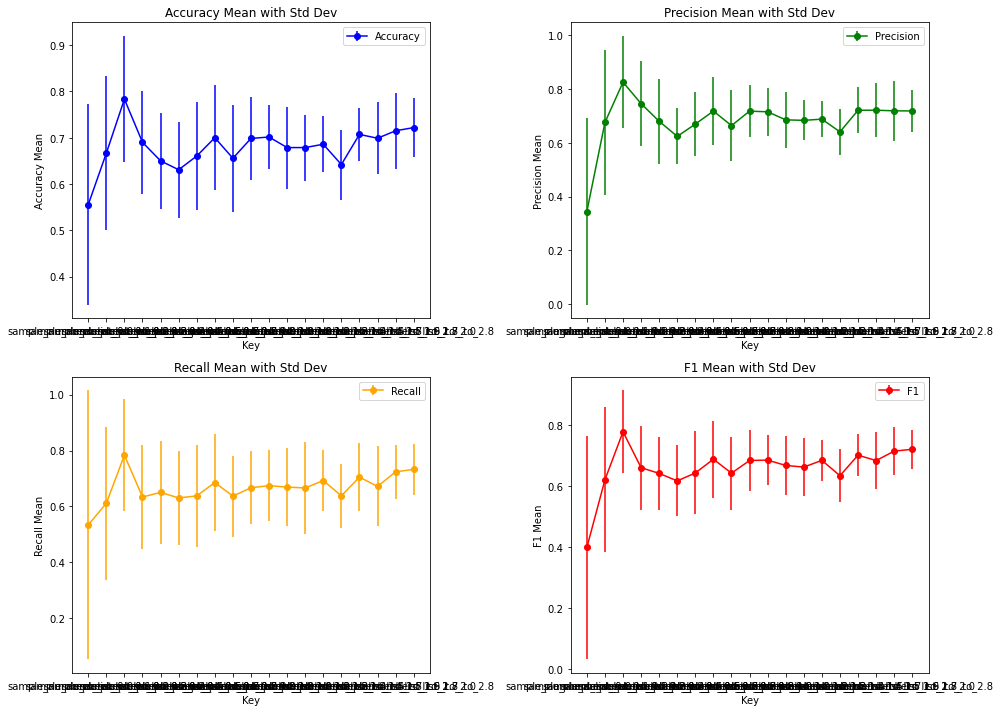

In [55]:
keys = list(classifier_dict.keys())

# Extracting metric values for plotting
acc_means = [classifier_dict[key]['acc_mean'] for key in keys]
acc_std_devs = [classifier_dict[key]['acc_std_dev'] for key in keys]

prec_means = [classifier_dict[key]['prec_mean'] for key in keys]
prec_std_devs = [classifier_dict[key]['prec_std_dev'] for key in keys]

recall_means = [classifier_dict[key]['recall_mean'] for key in keys]
recall_std_devs = [classifier_dict[key]['recall_std_dev'] for key in keys]

f1_means = [classifier_dict[key]['f1_mean'] for key in keys]
f1_std_devs = [classifier_dict[key]['f1_std_dev'] for key in keys]

# Plotting
plt.figure(figsize=(14, 10))

# Accuracy Mean with Std Dev
plt.subplot(2, 2, 1)
plt.errorbar(keys, acc_means, yerr=acc_std_devs, fmt='-o', color='blue', label='Accuracy')
plt.title('Accuracy Mean with Std Dev')
plt.xlabel('Key')
plt.ylabel('Accuracy Mean')
plt.legend()

# Precision Mean with Std Dev
plt.subplot(2, 2, 2)
plt.errorbar(keys, prec_means, yerr=prec_std_devs, fmt='-o', color='green', label='Precision')
plt.title('Precision Mean with Std Dev')
plt.xlabel('Key')
plt.ylabel('Precision Mean')
plt.legend()

# Recall Mean with Std Dev
plt.subplot(2, 2, 3)
plt.errorbar(keys, recall_means, yerr=recall_std_devs, fmt='-o', color='orange', label='Recall')
plt.title('Recall Mean with Std Dev')
plt.xlabel('Key')
plt.ylabel('Recall Mean')
plt.legend()

# F1 Mean with Std Dev
plt.subplot(2, 2, 4)
plt.errorbar(keys, f1_means, yerr=f1_std_devs, fmt='-o', color='red', label='F1')
plt.title('F1 Mean with Std Dev')
plt.xlabel('Key')
plt.ylabel('F1 Mean')
plt.legend()

plt.tight_layout()
plt.show()